#### First import necessary packages

In [120]:
import numpy as np
from modelbase.ode import Model, Simulator
import matplotlib.pyplot as plt
from matplotlib import patches
    
import time

## Create the model

In [121]:
variables = [
        #"B",  #photosystem II protein concentration
        "PQ",  # oxidised plastoquinone
        "PC",  # oxidised plastocyan
        "Fd",  # oxidised ferrodoxin
        "ATP",  # stromal concentration of ATP
        "NADPH",  # stromal concentration of NADPH
        "H",  # lumenal protons
        "LHC",#,  # non-phosphorylated antenna
        "Psbs", # PsBs
        "Vx",  #vioolaxathin relative concentration
        "PGA", 
        'BPGA', 
        'GAP', 
        'DHAP', 
        'FBP', 
        'F6P', 
        'G6P', 
        'G1P', 
        'SBP', 
        'S7P', 
        'E4P', 
        'X5P', 
        'R5P', 
        'RUBP', 
        'RU5P'
]

In [122]:
p = {"convf":3.2*10e-3, #converts ATP and NADPH
    "PSIItot": 2.5, # [mmol/molChl] total concentration of PSII
    "PSItot": 2.5,
    "PQtot": 17.5, # [mmol/molChl]
    "PCtot": 4., # Bohme1987 but other sources give different values - seems to depend greatly on organism and conditions
    "Fdtot": 5., # Bohme1987
    "Ctot": 2.5, #source unclear (Schoettler says 0.4...?, but plausible to assume that complexes (PSII,PSI,b6f) have approx. same abundance)
    "NADPtot": 0.8, # estimate from ~ 0.8 mM, Heineke1991
    "APtot": 2.55, # [mmol/molChl] Bionumbers ~2.55mM (=81mmol/molChl) (FIXME: Soma had 50)
    "Psbstot": 1., # relative pool of PsbS
    "Xtot": 1., # relative pool of carotenoids (V+A+Z)
    #Mara "ATPasetot": 1., # relative pool of ATPase

    # parameters associated with photosystem II
    "kH": 5e9,
    "kH0": 5e8, # base quenching" after calculation with Giovanni
    "kF": 6.25e8, # 6.25e7 fluorescence 16ns
    "k1": 5e9, # excitation of Pheo / charge separation 200ps
    "k1rev": 1e10,
    "k2": 5e9,#Mara was 5e10 # original 5e9 (charge separation limiting step ~ 200ps) - made this faster for higher Fs fluorescence
    "kdeg": 100,    # rate of PSII damage corresponds to p.k2 / .5e8
    "krep": 5.55e-4, # rate of repair fo PSII

    # parameters associated with photosystem I
    "kStt7": 0.0035, # [s-1] fitted to the FM dynamics
    "kPph1": 0.0013, # [s-1] fitted to the FM dynamics
    "KM_ST": 0.2, # Switch point (half-activity of Stt7) for 20% PQ oxidised (80% reduced)
    "n_ST": 2., # Hill coefficient of 4 -> 1/(2.5^4)~1/40 activity at PQox=PQred
    "staticAntI": 0.37,     # corresponds to PSI - LHCI supercomplex, when chlorophyll decreases more relative fixed antennae
    "staticAntII": 0.1,     # corresponds to PSII core
    "prob_attach": 1.,            # probability of antena attaching to PSI


     # ATP and NADPH parameters
    "kActATPase": 0.05,  # on 14.09 increased from 0.01 to saturate between 1-2 min, not 10
                            # paramter relating the rate constant of activation of the ATPase in the light
    "kDeactATPase": 0.002,   # paramter relating the deactivation of the ATPase at night
    "kATPsynth": 20.,    # taken from MATLAB
    "kATPcons": 10.,     # taken from MATLAB
    "ATPcyt": 0.5,       # only relative levels are relevant (normalised to 1) to set equilibrium
    "Pi_mol": 0.01,
    "DeltaG0_ATP": 30.6, # 30.6kJ/mol / RT
    "HPR": 14./3.,  #Vollmar et al. 2009 (after Zhu et al. 2013)
    "kNADPHcons": 15., # taken from MATLAB
    "NADPHcyt": 0.5, # only relatice levels

    # global conversion factor of PFD to excitation rate
    #"cPFD": 4. # [m^2/mmol PSII]

    # pH and protons
    "pHstroma": 7.8,
    "kLeak": 10.,#0.010, # [1/s] leakage rate -- inconsistency with Kathrine
    "bH": 100., # proton buffer: ratio total / free protons

    # rate constants
    "kPQred": 250., # [1/(s*(mmol/molChl))]
    "kCytb6f": 2.5, # a rough estimate: transfer PQ->cytf should be ~10ms
    "kPTOX": .01, # ~ 5 electrons / seconds. This gives a bit more (~20)
    "kPCox": 2500., # a rough estimate: half life of PC->P700 should be ~0.2ms
    "kFdred": 2.5e5, # a rough estimate: half life of PC->P700 should be ~2micro-s
    "kcatFNR": 500., # Carrillo2003 (kcat~500 1/s)
    "kcyc": 1.,

    "O2ext": 8., # corresponds to 250 microM cor to 20%
    "kNDH": .002, # re-introduce e- into PQ pool. Only positive for anaerobic (reducing) condition
    "kNh": 0.05,
    "kNr": 0.004,
    "NPQsw": 5.8,
    "nH": 5.,

    "EFNR": 3., # Bohme1987
    "KM_FNR_F": 1.56, # corresponds to 0.05 mM (Aliverti1990)
    "KM_FNR_N": 0.22, # corresponds to 0.007 mM (Shin1971 Aliverti2004)

    # quencher fitted parameters
    "gamma0": 0.1,          # slow quenching of Vx present despite lack of protonation
    "gamma1": 0.25,         # fast quenching present due to the protonation
    "gamma2": 0.6,          # slow quenching of Zx present despite lack of protonation
    "gamma3": 0.15,         # fastest possible quenching

    # non-photochemical quenching PROTONATION
    "kDeprotonation": 0.0096,
    "kProtonationL": 0.0096,
    "kphSatLHC": 5.8,
    "nH": 5.,
    "NPQsw": 5.8,

    # non-photochemical quenching XANTOPHYLLS
    "kDeepoxV": 0.0024,
    "kEpoxZ": 0.00024,      # 6.e-4        # converted to [1/s]
    "kphSat": 5.8,          # [-] half-saturation pH value for activity de-epoxidase highest activity at ~pH 5.8
    "kHillX": 5.,     # [-] hill-coefficient for activity of de-epoxidase
    "kHillL": 3.,     # [-] hill-coefficient for activity of de-epoxidase
    "kZSat": 0.12,          # [-] half-saturation constant (relative conc. of Z) for quenching of Z

    # standard redox potentials (at pH=0) in V
    "E0_QA": -0.140,
    "E0_PQ": 0.354,
    "E0_cytf": 0.350,
    "E0_PC": 0.380,
    "E0_P700": 0.480,
    "E0_FA": -0.550,
    "E0_Fd": -0.430,
    "E0_NADP": -0.113,

    # physical constants
    "F": 96.485, # Faraday constant
    "R": 8.3e-3, # universal gas constant
    "T": 298., # Temperature in K - for now assumed to be constant at 25 C

    # light
    "pfd": 100.,
    "Ton": 0.,
    "Toff": 1800,
    "dT": 120,

    "ox": True, # 1. means True, switched on
     
    # CBB cycle associated parameter set according to Pettersson and Pettersson 1988
    'CN': 0.5,
    'CO2': 0.2,
    'Cp': 15+2.05,#15.0
    'Ca': 0.5,
    'pHmedium': 7.6,
    'pHstroma': 7.9,
    'Pext': 0.5,

    #Vmaxes of Calvin cycle enzymes
    'V1': 0.34*8,
    'V6': 0.2*8,
    'V9': 0.04*8,
    'V13': 0.9999*8,
    'Vst': 0.04*8,
    'Vx': 0.25*8,
    'V19': 0.059,

    #equilibrium constants of calvin cycle enzymes
    'q2': 3.1 * (10.0 ** (-4.0)),
    'q3': 1.6 * (10.0**7.0),
    'q4': 22.0,
    'q5': (7.1),
    'q7': 0.084,
    'q8': (13.0),
    'q10': 0.85,
    'q11': 0.4,
    'q12': 0.67,
    'q14': 2.3,
    'q15': 0.058,

    #michaelis constants of calvin cycle enzymes
    'Km1': 0.02,
    'KmCO2': 0.0107, #millimol laut witzel
    'Km6': 0.03,
    'Km9': 0.013,
    'Km131': 0.05,
    'Km132': 0.05,
    'Km161': 0.014,
    'Km162': 0.3,
    'Kmst1': 0.08,
    'Kmst2': 0.08,
    'Kmnadph': 0.19,#ausgerechneter wert (ideal wert)
    'Kpga': 0.25,
    'Kgap': 0.075,
    'Kdhap': 0.077,
    'Kpi': 0.63,
    'Kpxt': 0.74,
    'Ki11': 0.04,
    'Ki12': 0.04,
    'Ki13': 0.075,
    'Ki14': 0.9,
    'Ki15': 0.07,
    'Ki61': 0.7,
    'Ki62': 12.0,
    'Ki9': 12.0,
    'Ki131': 2.0,
    'Ki132': 0.7,
    'Ki133': 4.0,
    'Ki134': 2.5,
    'Ki135': 0.4,
    'Kist': 10.0,
    'Kast1': 0.1,
    'Kast2': 0.02,
    'Kast3': 0.02,
    'km19' :0.036,
    'kmnadp': 1.23*10**-5,
    'k': 10.0**8.0*8,
    'oxPPP': 0.,
    #'k19' : 0. #rate constant for G6P-Shunt
    }


In [123]:
p1 = list(p)
print(p1)

['convf', 'PSIItot', 'PSItot', 'PQtot', 'PCtot', 'Fdtot', 'Ctot', 'NADPtot', 'APtot', 'Psbstot', 'Xtot', 'kH', 'kH0', 'kF', 'k1', 'k1rev', 'k2', 'kdeg', 'krep', 'kStt7', 'kPph1', 'KM_ST', 'n_ST', 'staticAntI', 'staticAntII', 'prob_attach', 'kActATPase', 'kDeactATPase', 'kATPsynth', 'kATPcons', 'ATPcyt', 'Pi_mol', 'DeltaG0_ATP', 'HPR', 'kNADPHcons', 'NADPHcyt', 'pHstroma', 'kLeak', 'bH', 'kPQred', 'kCytb6f', 'kPTOX', 'kPCox', 'kFdred', 'kcatFNR', 'kcyc', 'O2ext', 'kNDH', 'kNh', 'kNr', 'NPQsw', 'nH', 'EFNR', 'KM_FNR_F', 'KM_FNR_N', 'gamma0', 'gamma1', 'gamma2', 'gamma3', 'kDeprotonation', 'kProtonationL', 'kphSatLHC', 'kDeepoxV', 'kEpoxZ', 'kphSat', 'kHillX', 'kHillL', 'kZSat', 'E0_QA', 'E0_PQ', 'E0_cytf', 'E0_PC', 'E0_P700', 'E0_FA', 'E0_Fd', 'E0_NADP', 'F', 'R', 'T', 'pfd', 'Ton', 'Toff', 'dT', 'ox', 'CN', 'CO2', 'Cp', 'Ca', 'pHmedium', 'Pext', 'V1', 'V6', 'V9', 'V13', 'Vst', 'Vx', 'V19', 'q2', 'q3', 'q4', 'q5', 'q7', 'q8', 'q10', 'q11', 'q12', 'q14', 'q15', 'Km1', 'KmCO2', 'Km6', 'Km9

## Here we define the model object

In [124]:
# modelbase 1.0
m = Model(parameters=p, compounds=variables)

In [125]:
#check the state variables
m.get_compounds()

['PQ',
 'PC',
 'Fd',
 'ATP',
 'NADPH',
 'H',
 'LHC',
 'Psbs',
 'Vx',
 'PGA',
 'BPGA',
 'GAP',
 'DHAP',
 'FBP',
 'F6P',
 'G6P',
 'G1P',
 'SBP',
 'S7P',
 'E4P',
 'X5P',
 'R5P',
 'RUBP',
 'RU5P']

In [126]:
# ====================================================================== #
# Composed parameters #
m.add_derived_parameter(
    parameter_name="RT", function=lambda r, t: r * t, parameters=["R", "T"]
)

m.add_derived_parameter(
    parameter_name="dG_pH", function=lambda r, t: np.log(10) * r * t, parameters=["R", "T"]
)

m.add_derived_parameter(
    parameter_name="Hstroma", function=lambda pHstroma: 3.2e4*10**(-pHstroma), parameters=["pHstroma"]
)

m.add_derived_parameter(
    parameter_name="kProtonation", function=lambda Hstroma: 4e-3 / Hstroma, parameters=["Hstroma"]
)

# FIX ME: we used two different definitions for H_stroma (!). This one is Nima's
m.add_derived_parameter(
    parameter_name="H_stroma", function=lambda pHstroma: (10.0**((-1.0)*pHstroma))*1000.0, parameters=["pHstroma"]
)

def keq_PQred(E0_QA, F, E0_PQ, pHstroma, dG_pH, RT):
    DG1 = -E0_QA * F
    DG2 = -2 * E0_PQ * F
    DG = -2 * DG1 + DG2 + 2 * pHstroma * dG_pH
    K = np.exp(-DG/RT)
    return K

m.add_derived_parameter(
    parameter_name="Keq_PQred", function=keq_PQred, parameters=["E0_QA", "F", "E0_PQ", "pHstroma", "dG_pH", "RT"]
)

def Keq_cyc(E0_Fd, F, E0_PQ, pHstroma, dG_pH, RT):
    DG1 = -E0_Fd * F
    DG2 = -2 * E0_PQ * F
    DG = -2 * DG1 + DG2 + 2 * dG_pH * pHstroma
    K = np.exp(-DG/RT)
    return K

m.add_derived_parameter(
    parameter_name="Keq_cyc", function=Keq_cyc, parameters=["E0_Fd", "F", "E0_PQ", "pHstroma", "dG_pH", "RT"]
)              

def Keq_FAFd(E0_FA, F, E0_Fd, RT):
    DG1 = -E0_FA * F
    DG2 = -E0_Fd * F
    DG = -DG1 + DG2
    K = np.exp(-DG/RT)
    return K
               
m.add_derived_parameter(
    parameter_name="Keq_FAFd", function=Keq_FAFd, parameters=["E0_FA", "F", "E0_Fd", "RT"]
)               

def Keq_PCP700(E0_PC, F, E0_P700, RT):
    DG1 = -E0_PC * F
    DG2 = -E0_P700 * F
    DG = -DG1 + DG2
    K = np.exp(-DG/RT)
    return K

m.add_derived_parameter(
    parameter_name="Keq_PCP700", function=Keq_PCP700, parameters=["E0_PC", "F", "E0_P700", "RT"]
)               

def Keq_FNR(E0_Fd, F, E0_NADP, pHstroma, dG_pH, RT):
    DG1 = -E0_Fd * F
    DG2 = -2 * E0_NADP * F
    DG = -2 * DG1 + DG2 + dG_pH * pHstroma
    K = np.exp(-DG/RT)
    return K

m.add_derived_parameter(
    parameter_name="Keq_FNR", function=Keq_FNR, parameters=["E0_Fd", "F", "E0_NADP", "pHstroma", "dG_pH", "RT"]
) 

def Keq_ATP(pH, DeltaG0_ATP, dG_pH, HPR, pHstroma, Pi_mol, RT):
    DG = DeltaG0_ATP - dG_pH * HPR * (pHstroma - pH)
    Keq = Pi_mol * np.exp(-DG/RT)
    return Keq

def Keq_cytb6f(pH, F, E0_PQ, E0_PC, pHstroma, RT, dG_pH):
    DG1 = -2 * F * E0_PQ
    DG2 = -F * E0_PC
    DG = - (DG1 + 2*dG_pH * pH) + 2 * DG2 + 2*dG_pH * (pHstroma - pH)
    Keq = np.exp(-DG/RT)
    return Keq


In [127]:
def calculate_pHstroma(x):
    return (-np.log(x*(3.2e-5))/np.log(10))    

def calculate_pHinv(x):
    return (4e3*10**(-x))

def light(pfd):
    '''
    :return: light intensity at certain point of time. 
    Typical PAM light function
    '''
    return pfd

In [128]:
def pqmoiety(PQ, pqtot):
    return pqtot - PQ

m.add_algebraic_module(
    module_name="pq_alm",
    function=pqmoiety,
    compounds=["PQ"],
    derived_compounds=["PQred"],
    modifiers=None,
    parameters=["PQtot"],
)

def pcmoiety(PC, pctot):
    return pctot - PC

m.add_algebraic_module(
    module_name="pc_alm",
    function=pcmoiety,
    compounds=["PC"],
    derived_compounds=["PCred"],
    parameters=["PCtot"],
)

def fdmoiety(Fd, fdtot):
    return fdtot - Fd

m.add_algebraic_module(
    module_name="fd_alm",
    function=fdmoiety,
    compounds=["Fd"],
    derived_compounds=["Fdred"],
    parameters=["Fdtot"],
)

def adpmoiety(ATP, atptot):
    return atptot - ATP

m.add_algebraic_module(
    module_name="adp_alm",
    function=adpmoiety,
    compounds=["ATP"],
    derived_compounds=["ADP"],
    parameters=["APtot"],
)

def nadpmoiety(NADPH, nadptot):
    return nadptot - NADPH

m.add_algebraic_module(
    module_name="nadp_alm",
    function=nadpmoiety,
    compounds=["NADPH"],
    derived_compounds=["NADP"],
    modifiers=None,
    parameters=["NADPtot"],
)

def lhcmoiety(LHC):
    return 1 - LHC

m.add_algebraic_module(
    module_name="lhc_alm",
    function=lhcmoiety,
    compounds=["LHC"],
    derived_compounds=["LHCp"]
)

def xmoiety(Vx, Xtot):
    return Xtot - Vx

m.add_algebraic_module(
    module_name="xantophylls_alm",
    function=xmoiety,
    compounds=["Vx"],
    derived_compounds=["Zx"],
    parameters=['Xtot']
)

def psbsmoiety(Psbs, Psbstot):
    return Psbstot - Psbs

m.add_algebraic_module(
    module_name="psbs_alm",
    function=psbsmoiety,
    compounds=["Psbs"],
    derived_compounds=["Psbsp"],
    parameters=['Psbstot']
)

def ps2crosssection(LHC, staticAntII, staticAntI):
    """ calculates the cross section of PSII """
    cs = staticAntII + (1 - staticAntII - staticAntI) * LHC
    return cs

m.add_algebraic_module(
    module_name="ps2crosssection",
    function=ps2crosssection,
    compounds=["LHC"],
    derived_compounds=["ps2cs"],
    modifiers=None,
    parameters=["staticAntII", "staticAntI"],
)

def quencher(Psbs, Vx, Psbsp, Zx, y0, y1, y2, y3, kZSat):
    """ 
    co-operatiove 4-state quenching mechanism
    
    Comment:
        seems like this can't reach 1, so I've checked the max value and normalized it
        for i in np.linspace(0,1,100):
            for j in np.linspace(0,1,100):
                a = np.hstack((a, vQuencher4states(p, i, j)))
        max(a)
    """
    ZAnt = Zx / (Zx + kZSat)
    Q = (y0 * Vx * Psbs + y1 * Vx * Psbsp + y2 * ZAnt * Psbsp + y3 * ZAnt * Psbs)#/0.5625
    #Q = (y0 * (1-ZAnt) * Psbs + y1 * (1-ZAnt) * Psbsp + y2 * ZAnt * Psbsp + y3 * ZAnt * Psbs)#/0.5625
    return Q

m.add_algebraic_module(
    module_name="quencher",
    function=quencher,
    compounds=["Psbs", "Vx", "Psbsp", "Zx"],
    derived_compounds=["Q"],
    modifiers=None,
    parameters=["gamma0", "gamma1", "gamma2", "gamma3", "kZSat"],
)
    

def ps2states(PQ, PQred, ps2cs, Q, PSIItot, k2, kF, _kH, Keq_PQred, kPQred, pfd, kH0):
    L = ps2cs * light(pfd)
    kH = kH0 + _kH * Q
    k3p = kPQred * PQ
    k3m = kPQred * PQred / Keq_PQred
   
    Bs = []

    
    if isinstance(kH, float) and isinstance(PQ, np.ndarray):
        kH = np.repeat(kH, len(PQ))
      
    
    for L, kH, k3p, k3m in zip(L, kH, k3p, k3m):
        M = np.array(
            [
                [-L - k3m, kH + kF, k3p, 0],
                [L, -(kH + kF + k2), 0, 0],
                [0, 0, L, -(kH + kF)],
                [1, 1, 1, 1],
            ]
        )
        A = np.array([0, 0, 0, PSIItot])
        B0, B1, B2, B3 = np.linalg.solve(M, A)
        Bs.append([B0, B1, B2, B3])
    return np.array(Bs).T


m.add_algebraic_module(
    module_name="ps2states",
    function=ps2states,
    compounds=["PQ", "PQred", "ps2cs", "Q"],
    derived_compounds=["B0", "B1", "B2", "B3"],
    parameters=["PSIItot", "k2", "kF", "kH", "Keq_PQred", "kPQred", "pfd", "kH0"],
)

def ps1states(PC, PCred, Fd, Fdred, LHC, ps2cs, PSItot, kFdred, Keq_FAFd, Keq_PCP700, kPCox, pfd):
    """ 
    QSSA calculates open state of PSI
    depends on reduction states of plastocyanin and ferredoxin
    C = [PC], F = [Fd] (ox. forms)
    accepts: light, y as an array of arrays
    returns: array of PSI open
    """
    L = (1-ps2cs) * light(pfd)

    A1 = PSItot / (1 + L/(kFdred * Fd) + (1 + Fdred/(Keq_FAFd * Fd))
                      * (PC/(Keq_PCP700 * PCred)
                         + L/(kPCox * PCred))
    )
    return A1

m.add_algebraic_module(
    module_name="ps1states",
    function=ps1states,
    compounds=["PC", "PCred", "Fd", "Fdred", "LHC", "ps2cs"],
    derived_compounds=["A1"],
    parameters=["PSItot", "kFdred", "Keq_FAFd", "Keq_PCP700", "kPCox", "pfd"],
)

def fluorescence(Q, B0, B2, ps2cs, k2, kF, kH, kH0):
    fluo = (ps2cs * kF * B0) / (kF + k2 + kH*Q) + (ps2cs * kF * B2) / (kF + kH*Q)
    return fluo

m.add_algebraic_module(
    module_name="fluorescence",
    function=fluorescence,
    compounds=["Q", "B0", "B2", "ps2cs"],
    derived_compounds=["Fluo"],
    modifiers=None,
    parameters=["k2","kF", "kH", "kH0"]
)

def calculate_pH(x):
    return (-np.log(x*(2.5e-4))/np.log(10))

m.add_algebraic_module(
    module_name="calculate_pH",
    function=calculate_pH,
    compounds=["H"],
    derived_compounds=["pH"],
    modifiers=None
)

def Pimoiety(PGA,BPGA,GAP,DHAP,FBP,F6P,G6P,G1P,SBP,S7P,E4P,X5P,R5P,RUBP,RU5P,ATP, Cp):
    return Cp - (PGA + 2*BPGA + GAP + DHAP + 2*FBP + F6P + G6P + G1P + 2*SBP + S7P + E4P + X5P + R5P + 2*RUBP + RU5P + ATP)

m.add_algebraic_module(
    module_name="pi_alm",
    function=Pimoiety,
    compounds=["PGA","BPGA","GAP","DHAP","FBP","F6P","G6P","G1P","SBP","S7P","E4P","X5P","R5P","RUBP","RU5P","ATP"],
    derived_compounds=["Pi"],
    parameters=["Cp"],
    modifiers=None
)

def Nmoiety(Pi, PGA, GAP, DHAP, Kpxt, Pext, Kpi, Kpga, Kgap, Kdhap):
    """Used several times to calculate the rate of vPGA, vGAP and vDHAP"""
    return 1+(1+(Kpxt/Pext))*((Pi/Kpi)
               +(PGA/Kpga)
               +(GAP/Kgap)
               +(DHAP/Kdhap))

m.add_algebraic_module(
    module_name="n_alm",
    function=Nmoiety,
    compounds=["Pi","PGA","GAP","DHAP"],
    derived_compounds=["N"],
    parameters=["Kpxt", "Pext", "Kpi", "Kpga", "Kgap", "Kdhap"],
    modifiers=None
)

I found it critical to introduce each occupation state of PSII as a new variable, and hence algebraic mode

In [129]:
# Rate of electron flow through the photosystems.
# Calling algebraic modules calculating excited states of each photosystem
def vPS2(B1, k2):
    """ reaction rate constant for photochemistry """
    v = 0.5 * k2 * B1
    return v

m.add_reaction(
    rate_name='vPS2',
    function=vPS2,
    stoichiometry= {"PQ":-1, "H": 2/m.get_parameter("bH")},
    dynamic_variables=["B1"],
    parameters=["k2"],
    reversible=True,
)

def vPS1(A, ps2cs, pfd):
    """ reaction rate constant for open PSI """
    L = (1-ps2cs) * light(pfd)
    v = L * A
    return v

m.add_reaction(
    rate_name='vPS1',
    function=vPS1,
    stoichiometry={"Fd": -1, "PC": 1},
    dynamic_variables=["A1", "ps2cs"],
    parameters=["pfd"],
    reversible=True,
)



In [130]:
###############################################################################
# Reaction rates
###############################################################################
def _oxygen(time, ox, O2ext, kNDH, Ton, Toff):
    """ return oxygen and NDH concentration as a function of time
    used to simulate anoxia conditions as in the paper"""
    if ox == True:
        ''' by default we assume constant oxygen supply'''
        return O2ext, kNDH
    else:
        if time<Ton or time>Toff:
            return O2ext, 0
        else:
            return 0, kNDH

##############################################################################
def oxygen(time, ox, O2ext, kNDH, Ton, Toff):
    """ return oxygen and NDH concentration as a function of time
    used to simulate anoxia conditions as in the paper"""
    if isinstance(time, (int, float)):
        return np.array(_oxygen(time, ox, O2ext, kNDH, Ton, Toff))
    else:
        return np.array(
            [
                _oxygen(t, ox, O2ext, kNDH, Ton, Toff)
                for t in time
            ]
        ).T     
        
def vPTOX(Pred, time, kPTOX, ox, O2ext, kNDH, Ton, Toff):
    """ calculates reaction rate of PTOX """
    v = Pred * kPTOX * oxygen(time, ox, O2ext, kNDH, Ton, Toff)[0] 
    return v

m.add_reaction(
    rate_name='vPTOX',
    function=vPTOX,
    stoichiometry= {"PQ": 1},
    modifiers=["PQred", "time"],
    parameters=["kPTOX", "ox", "O2ext", "kNDH", "Ton", "Toff"],
    reversible=False,
)


def vNDH(Pox, time, ox, O2ext, kNDH, Ton, Toff):
    """ 
    calculates reaction rate of PQ reduction under absence of oxygen
    can be mediated by NADH reductase NDH
    """
    v = oxygen(time, ox, O2ext, kNDH, Ton, Toff)[1] * Pox
    return v



m.add_reaction(
    rate_name='vNDH',
    function=vNDH,
    stoichiometry=  {"PQ":-1},
    modifiers=["time"],
    parameters=["ox", "O2ext", "kNDH", "Ton", "Toff"],
    reversible=False,
)


def vB6f(PC, Pox, H, Pred, PCred, pH, kCytb6f, F, E0_PQ, E0_PC, pHstroma, RT, dG_pH):
    """ calculates reaction rate of cytb6f """
    Keq = Keq_cytb6f(pH, F, E0_PQ, E0_PC, pHstroma, RT, dG_pH)
    v = np.maximum(kCytb6f * (Pred * PC**2 - (Pox * PCred**2)/Keq), -kCytb6f)
    return v

m.add_reaction(
    rate_name='vB6f',
    function=vB6f,
    stoichiometry={"PC": -2, "PQ": 1, "H": 4/100},
    modifiers=["PQred", "PCred", "pH"],
    parameters=["kCytb6f", "F", "E0_PQ", "E0_PC", "pHstroma", "RT", "dG_pH"],
    reversible=True,
)

def vCyc(Pox, Fdred, kcyc):
    """
    calculates reaction rate of cyclic electron flow
    considered as practically irreversible
    """
    v = kcyc * ((Fdred**2) * Pox)
    return v

m.add_reaction(
    rate_name='vCyc',
    function=vCyc,
    stoichiometry=  {"PQ": -1, "Fd": 2},
    dynamic_variables=["PQ","Fdred"],
    parameters=["kcyc"],
    reversible=True,
)

def vFNR(Fd, Fdred, NADPH, NADP, KM_FNR_F, KM_FNR_N, EFNR, kcatFNR, Keq_FNR, convf):
    """
    Reaction rate mediated by the Ferredoxin—NADP(+) reductase (FNR)
    Kinetic: convenience kinetics Liebermeister and Klipp, 2006
    Compartment: lumenal side of the thylakoid membrane
    Units:
    Reaction rate: mmol/mol Chl/s
    [F], [Fdred] in mmol/mol Chl/s
    [NADPH] in mM
    """
    fdred = Fdred/KM_FNR_F
    fdox = Fd/KM_FNR_F
    nadph = (NADPH/convf)/KM_FNR_N  # NADPH requires conversion to mmol/mol of chlorophyll 
    nadp = (NADP/convf)/KM_FNR_N # NADP requires conversion to mmol/mol of chlorophyll 
    v = (EFNR * kcatFNR *
        ((fdred**2) * nadp - ((fdox**2) * nadph) / Keq_FNR) /
        ((1+fdred+fdred**2) * (1+nadp) + (1+fdox+fdox**2) * (1+nadph) - 1))
    return v

m.add_reaction(
    rate_name='vFNR',
    function=vFNR,
    stoichiometry=  {"Fd": 2, "NADPH": 1*m.get_parameter('convf')},
    dynamic_variables=["Fd", "Fdred", "NADPH", "NADP"],
    parameters=["KM_FNR_F", "KM_FNR_N", "EFNR", "kcatFNR", "Keq_FNR", "convf"],
    reversible=False,
)
         

def vLeak(H, kLeak, pHstroma):
    """ 
    rate of leak of protons through the membrane
    """
    v = kLeak * (H - calculate_pHinv(pHstroma))
    return v


m.add_reaction(
    rate_name='vLeak',
    function=vLeak,
    stoichiometry= {"H": -1/m.get_parameter("bH")},
    modifiers=None,
    parameters=["kLeak", "pHstroma"],
    reversible=False,
)

def vSt12(Ant, Pox, kStt7, PQtot, KM_ST, n_ST):
    """ 
    reaction rate of state transitions from PSII to PSI
    Ant depending on module used corresponds to non-phosphorylated antennae
    or antennae associated with PSII
    """
    kKin = kStt7 * ( 1 / (1 + ((Pox /PQtot)/KM_ST)**n_ST))
    v = kKin * Ant
    return v

m.add_reaction(
    rate_name='vSt12',
    function=vSt12,
    stoichiometry= {"LHC": -1},
    modifiers=["PQ"],
    parameters=["kStt7", "PQtot", "KM_ST", "n_ST"],
    reversible=False,
)

def vSt21(LHCp, kPph1):
    """
    reaction rate of state transitions from PSI to PSII
    """
    v = kPph1 * LHCp
    return v

m.add_reaction(
    rate_name='vSt21',
    function=vSt21,
    stoichiometry= {"LHC": 1},
    dynamic_variables=["LHCp"],
    parameters=["kPph1"],
    reversible=False,
)

def vATPsynthase(ATP, ADP, pH, kATPsynth, DeltaG0_ATP, dG_pH, HPR, pHstroma,Pi_mol, RT, convf):
    """
    Reaction rate of ATP production
    Kinetic: simple mass action with PH dependant equilibrium
    Compartment: lumenal side of the thylakoid membrane
    Units:
    Reaction rate: mmol/mol Chl/s
    [ATP], [ADP] in mM
    """    
    v = kATPsynth * (ADP/convf - ATP/convf / Keq_ATP(pH, DeltaG0_ATP, dG_pH, HPR, pHstroma, Pi_mol, RT)) #* E
    return v

m.add_reaction(
    rate_name='vATPsynthase',
    function=vATPsynthase,
    stoichiometry= {"ATP": 1*m.get_parameter('convf'), "H": -m.get_parameter('HPR')/m.get_parameter('bH')},
    dynamic_variables=["ATP","ADP","pH"],
    parameters=["kATPsynth","DeltaG0_ATP","dG_pH","HPR","pHstroma","Pi_mol","RT","convf"],
    reversible=True,
)


def vDeepox(Vx, H, nH, kDeepoxV, kphSat):
    """
    activity of xantophyll cycle: de-epoxidation of violaxanthin, modelled by Hill kinetics
    """
    vf = kDeepoxV * ((H ** nH)/ (H ** nH + calculate_pHinv(kphSat) ** nH)) * Vx
    return vf

m.add_reaction(
    rate_name='vDeepox',
    function=vDeepox,
    stoichiometry= {"Vx": -1},
    modifiers=["H"],
    parameters=["kHillX", "kDeepoxV", "kphSat"],
    reversible=False,
)

def vEpox(Zx, kEpoxZ):
    """
    activity of xantophyll cycle: epoxidation
    """
    vr = kEpoxZ * Zx
    return vr

m.add_reaction(
    rate_name='vEpox',
    function=vEpox,
    stoichiometry= {"Vx": 1},
    dynamic_variables=["Zx"],
    parameters=["kEpoxZ"],
    reversible=True,
)

def vLhcprotonation(Psbs, H, nH, kProtonationL, kphSatLHC):
    """
    activity of PsbS protein protonation: protonation modelled by Hill kinetics
    """
    vf = kProtonationL * ((H ** nH)/ (H ** nH + calculate_pHinv(kphSatLHC) ** nH)) * Psbs
    return vf

m.add_reaction(
    rate_name='vLhcprotonation',
    function=vLhcprotonation,
    stoichiometry= {"Psbs": -1},
    modifiers=["H"],
    parameters=["kHillL", "kProtonationL", "kphSatLHC"],
    reversible=False,
)

def vLhcdeprotonation(Psbsp, kDeprotonation):
    """
    activity of PsbS protein protonation: deprotonation
    """
    vr = kDeprotonation * Psbsp
    return vr

m.add_reaction(
    rate_name='vLhcdeprotonation',
    function=vLhcdeprotonation,
    stoichiometry= {"Psbs": 1},
    dynamic_variables=["Psbsp"],
    parameters=["kDeprotonation"],
    reversible=True,
)



In [131]:
###############################################################################
# Reaction rates
###############################################################################


 # rate constants
parameters =["kPQred", # [1/(s*(mmol/molChl))]
    "kCytb6f", # a rough estimate: transfer PQ->cytf should be ~10ms
    "kPTOX", # ~ 5 electrons / seconds. This gives a bit more (~20)
    "kPCox", # a rough estimate: half life of PC->P700 should be ~0.2ms
    "kFdred", # a rough estimate: half life of PC->P700 should be ~2micro-s
    "kcatFNR", # Carrillo2003 (kcat~500 1/s)
    "kcyc",

    "O2ext", # corresponds to 250 microM cor to 20%
    "kNDH", # re-introduce e- into PQ pool. Only positive for anaerobic (reducing) condition
    "kNh",
    "kNr",
    "NPQsw",
    "nH",

    "EFNR", # Bohme1987
    "KM_FNR_F", # corresponds to 0.05 mM (Aliverti1990)
    "KM_FNR_N", # corresponds to 0.007 mM (Shin1971 Aliverti2004)

    # quencher fitted parameters
    "gamma0",          # slow quenching of Vx present despite lack of protonation
    "gamma1",         # fast quenching present due to the protonation
    "gamma2",          # slow quenching of Zx present despite lack of protonation
    "gamma3",         # fastest possible quenching

    # non-photochemical quenching PROTONATION
    "kDeprotonation",
    "kProtonationL",
    "kphSatLHC",
    "nH",
    "NPQsw",

    # non-photochemical quenching XANTOPHYLLS
    "kDeepoxV",
    "kEpoxZ",      # 6.e-4        # converted to [1/s]
    "kphSat",          # [-] half-saturation pH value for activity de-epoxidase highest activity at ~pH 5.8
    "kHillX",     # [-] hill-coefficient for activity of de-epoxidase
    "kHillL",     # [-] hill-coefficient for activity of de-epoxidase
    "kZSat"]         # [-] half-saturation constant (relative conc. of Z) for quenching of Z


In [132]:
""" Calvin-Benson-Bassham Cycle Reaction Rates """
def v1(RUBP, PGA, FBP, SBP, P, NADPH, V1, CO2, Km1, Ki11, Ki12, Ki13, Ki14, Ki15, KmCO2):
    """ rate of RuBisCO
    3 Ribulose-1,5-bisphosphate + 3 CO2
    -- RuBisCO -->
    6 3-Phosphoglycerate
    RuBp + CO2 -> PGA
    """
    return (V1*RUBP*CO2)/((RUBP+Km1*(1+(PGA/Ki11)+(FBP/Ki12)+(SBP/Ki13)+(P/Ki14)+(NADPH/Ki15)))*(CO2+KmCO2))

m.add_reaction(
    rate_name='vRuBisCO',
    function=v1,
    stoichiometry= {"RUBP": -1, "PGA": 2},
    dynamic_variables=["RUBP", "PGA", "FBP", "SBP", "Pi", "NADPH"],
    parameters=["V1", "CO2", "Km1", "Ki11", "Ki12", "Ki13", "Ki14", "Ki15", "KmCO2"],
    reversible=True,
)

def v2(ATP, PGA, BPGA, ADP, k, q2):
    """
    6 3-Phosphoglycerate + 6 ATP
    -- Phosphoglycerate kinase (PGK) -->
    6 1,3-Bisphosphoglycerate + 6 ADP
    PGA + ATP -> BPGA + ADP
    Assumed to be at equilibrium
    """
    return k*((ATP*PGA)-(1/q2)*(ADP*BPGA))

m.add_reaction(
    rate_name='vPGA_kinase',
    function=v2,
    stoichiometry= {"ATP": -1, "PGA": -1, "BPGA": 1},
    modifiers=["ADP"],
    parameters=["k", "q2"],
    reversible=True,
)

def v3(BPGA, NADPH, GAP, NADP, P, k, H_stroma, q3):
    """
    6 1,3-Bisphosphoglycerate + 6 NADPH + 6 H+
    -- Glyceraldehyde 3-phosphate dehydrogenase (GADPH)-->
    1 G3P + 5 Glyceraldehyde 3-phosphate
    BPGA + NADPH -> GAP + NADP
    Assumed to be at equilibrium
    Stroma pH is assumed to be constant
    """

    return k*((NADPH*BPGA*H_stroma)-(1/q3)*(GAP*NADP*P))

m.add_reaction(
    rate_name='vBPGA_dehydrogenase',
    function=v3,
    stoichiometry= {"BPGA": -1, "NADPH": -1, "GAP": 1},
    dynamic_variables=["BPGA", "NADPH", "GAP", "NADP", "Pi"],
    parameters=["k", "H_stroma", "q3"],
    reversible=True,
)

def v4(GAP, DHAP, k, q4):
    """ 
    (5) Glyceraldehyde 3-phosphate
    -- Triose phosphate isomerae (TPI)-->
    (?) Dihydroxyacetone phosphate
    GAP -> DHAP
    Assumed to be at equilibrium
    """
    return k*((GAP)-(1/q4)*(DHAP))

m.add_reaction(
    rate_name='vTPI',
    function=v4,
    stoichiometry= {"GAP": -1, "DHAP": 1},
    parameters=["k", "q4"],
    reversible=True,
)

def v5(GAP, DHAP, FBP, k, q5):
    """
    (5) Glyceraldehyde 3-phosphate + (?) Dihydroxyacetone phosphate
    -- Aldolase (ALD)-->
    Frucose 1,6-bisphosphate
    GAP + DHAP -> FBP
    Assumed to be at equilibrium
    """
    return k*((GAP*DHAP)-(1/q5)*(FBP))

m.add_reaction(
    rate_name='vAldolase',
    function=v5,
    stoichiometry= {"GAP": -1, "DHAP": -1, "FBP": 1},
    parameters=["k", "q5"],
    reversible=True,
)

def v6(FBP, F6P, P, V6, Km6, Ki61, Ki62):
    """
    (?) Fructose 1,6-bisphosphate + (?) H20
    --Fructose 1,6-bisphosphatase (FBPase) -->
    (6) Fructose 6-phosphate + (Pi)
    FBP -> F6P
    """
    return (V6*FBP)/(FBP+Km6*(1+(F6P/Ki61)+(P/Ki62)))

m.add_reaction(
    rate_name='vFBPase',
    function=v6,
    stoichiometry= {"FBP": -1, "F6P": 1},
    modifiers= ["Pi"],
    parameters=["V6", "Km6", "Ki61", "Ki62"],
    reversible=True,
)

def v7(GAP, F6P, X5P, E4P, k, q7):
    """
    (?) Fructose 6-phosphate + (?) Glyceraldehyde 3-phosphate
    -- Transketolase (TK) -->
    (?) Xylulose 5-phosphate + (?) Erythrose 4-phosphate
    GAP + F6P -> X5P + E4P
    Assumed to be at equilibrium
    """
    return k*((GAP*F6P)-(1/q7)*(X5P*E4P))

m.add_reaction(
    rate_name='vF6P_Transketolase',
    function=v7,
    stoichiometry= {"GAP": -1, "F6P": -1, "X5P": 1, "E4P": 1},
    parameters=["k", "q7"],
    reversible=True,
)

def v8(DHAP, E4P, SBP, k, q8):
    """
    (?) Dihydroxyacetone phosphate + (?) Erythrose 4-phosphate
    -- Aldolase (ALD)-->
    (?) Sedoheptulose 1,7-bisphosphate
    DHAP + E4P -> SBP
    Assumed to be at equilibrium
    """
    return k*((DHAP*E4P)-(1/q8)*(SBP))

m.add_reaction(
    rate_name='v8',
    function=v8,
    stoichiometry= {"DHAP": -1, "E4P": -1, "SBP": 1},
    parameters=["k", "q8"],
    reversible=True,
)

def v9(SBP, Pi, V9, Km9, Ki9):
    """
    (?) Sedoheptulose 1,7-bisphosphate + H20
    --Sedoheptulose 1,7-bisphosphatase (SBPase)-->
    (?) Sedoheptulose 7-phosphate + (?) Pi
    SBP -> S7P
    """

    return (V9*SBP)/(SBP+Km9*(1+(Pi/Ki9)))

m.add_reaction(
    rate_name='v9',
    function=v9,
    stoichiometry= {"SBP": -1, "S7P": 1}, #CHECKME
    dynamic_variables=["SBP","Pi"],
    parameters=["V9", "Km9", "Ki9"],
    reversible=True,
)

def v10(GAP, S7P, X5P, R5P, k, q10):
    return k*((GAP*S7P)-(1/q10)*(X5P*R5P))

m.add_reaction(
    rate_name='v10',
    function=v10,
    stoichiometry= {"GAP": -1, "S7P": -1, "X5P": 1, "R5P": 1}, 
    parameters=["k", "q10"],
    reversible=True,
)

def v11(R5P, RU5P, k, q11):
    return k*((R5P)-(1/q11)*(RU5P))

m.add_reaction(
    rate_name='v11',
    function=v11,
    stoichiometry= {"R5P": -1, "RU5P": 1}, 
    parameters=["k", "q11"],
    reversible=True,
)

def v12(X5P, RU5P, k, q12):
    return k*((X5P)-(1/q12)*(RU5P))

m.add_reaction(
    rate_name='v12',
    function=v12,
    stoichiometry= {"X5P": -1, "RU5P": 1}, 
    parameters=["k", "q12"],
    reversible=True,
)

def v13(RU5P, ATP, RUBP, PGA, P, ADP, V13, Km131, Ki131, Ki132, Ki133, Ki134, Km132, Ki135):
    return (V13*RU5P*ATP)/((RU5P+Km131*(1+(PGA/Ki131)+(RUBP/Ki132)+(P/Ki133)))*(ATP*(1+(ADP/Ki134))+Km132*(1+(ADP/Ki135))))

m.add_reaction(
    rate_name='v13',
    function=v13,
    stoichiometry= {"RU5P": -1, "ATP": -1, "RUBP": 1}, 
    modifiers=["PGA", "Pi", "ADP"],
    parameters=["V13", "Km131", "Ki131", "Ki132", "Ki133", "Ki134", "Km132", "Ki135"],
    reversible=True,
)

def v14(F6P, G6P, k, q14):
    return k*((F6P)-(1/q14)*(G6P))

m.add_reaction(
    rate_name='vG6P_isomerase',
    function=v14,
    stoichiometry= {"F6P": -1, "G6P": 1}, 
    parameters=["k", "q14"],
    reversible=True,
)

def v15(G6P, G1P, k, q15):
    return k*((G6P)-(1/q15)*(G1P))

m.add_reaction(
    rate_name='vPhosphoglucomutase',
    function=v15,
    stoichiometry= {"G6P": -1, "G1P": 1}, 
    parameters=["k", "q15"],
    reversible=True,
)

def vpga(PGA, N, Vx, Kpga):
    return (Vx*PGA)/(N*Kpga)

m.add_reaction(
    rate_name='vpga',
    function=vpga,
    stoichiometry= {"PGA": -1}, 
    modifiers=["N"],
    parameters=["Vx", "Kpga"],
    reversible=True,
)

def vgap(GAP, N, Vx, Kgap):
    return (Vx*GAP)/(N*Kgap)

m.add_reaction(
    rate_name='vgap',
    function=vgap,
    stoichiometry= {"GAP": -1}, 
    modifiers=["N"],
    parameters=["Vx", "Kgap"],
    reversible=True,
)

def vdhap(DHAP, N, Vx, Kdhap):
    return (Vx*DHAP)/(N*Kdhap)

m.add_reaction(
    rate_name='vdhap',
    function=vdhap,
    stoichiometry= {"DHAP": -1},
    modifiers=["N"],
    parameters=["Vx", "Kdhap"],
    reversible=True,
)

def vStarch(G1P, ATP, ADP, P, PGA, F6P, FBP, Vst, Kmst1, Kist, Kmst2, Kast1, Kast2, Kast3):
    """G1P -> Gn-1 ; Starch production"""
    return (Vst*G1P*ATP)/((G1P+Kmst1)*((1+(ADP/Kist))*(ATP+Kmst2)+((Kmst2*P)/(Kast1*PGA+Kast2*F6P+Kast3*FBP))))

m.add_reaction(
    rate_name='vStarch',
    function=vStarch,
    stoichiometry= {"G1P": -1, "ATP": -1}, 
    modifiers= ["ADP", "Pi", "PGA", "F6P", "FBP"],
    parameters=["Vst", "Kmst1", "Kist", "Kmst2", "Kast1", "Kast2", "Kast3"],
    reversible=False,
)
#The OPP/G6P-Shunt/E13/G6P_Dehydrogenase:
def v19(G6P, NADP, k19):
  #  G6P + 2NADP -> Ru5P + 2NADPH + CO2 
    return (k19*G6P*(NADP**2))

m.add_reaction(
    rate_name='G6P_dehydrogenase',
    function=v19,
    stoichiometry= {"G6P":-1, "RU5P": 1, "NADPH": 2},
    modifiers=["NADP"],
    parameters=["k19"],
    reversible=False,
)

def v19(G6P, NADP, km19,V19, kmnadp): 
    return((V19*(G6P/km19)*((NADP/kmnadp))**2)/((1+(G6P/km19))*(1+(NADP/kmnadp))**2))

m.add_reaction(
    rate_name='G6P_dehydrogenase',
    function=v19,
    stoichiometry= {"G6P":-1, "RU5P": 1, "NADPH": 2},
    modifiers=["NADP"],
    parameters=["km19", "V19", "kmnadp"],
    reversible=False, 
)

In [133]:
s = Simulator(m)

# Set initial conditions using dictionary
y0 = {
        "PQ":m.get_parameter('PQtot')/2,
        "PC":m.get_parameter('PCtot')/2,
        "Fd":m.get_parameter('Fdtot')/2,
        "ATP":0.12,
        "NADPH":0.281543418344,
        "H":calculate_pHinv(7.2),
        "LHC":0.9,
        "Psbs":0.9,
        "Vx":0.9,
        "PGA":2.15,
        'BPGA':0.000907499521924,
        'GAP':0.011839616887,
        'DHAP':0.260471552645,
        'FBP':0.11,
        'F6P':0.36,
        'G6P':0.46,
        'G1P':0.166166918189,
        'SBP':0.2,
        'S7P':0.56,
        'E4P':0.0330766864679,
        'X5P':0.0374527459593,
        'R5P':0.0627333486958,
        'RUBP':0.45,
        'RU5P':0.02,
}

In [134]:
klist= [0.000001,0.1,1,2,5,10,20]
limly=0
limy=10
limlx=0
limx=1000
def rates_time_k(inrate):
    for i in klist:
        s.model.update_parameter('km19',i)
        s.initialise(y0)
        s.simulate(1000,steps=1000)
        rates=s.get_fluxes_dict()['%s'% inrate]
        plt.plot(s.get_time(),rates, label=i)
        plt.xlabel("time",fontsize=15) 
        plt.ylabel("rate of %s" %inrate,fontsize=15)
        plt.title("%s over time" % inrate,fontsize=20)
        plt.ylim(limly,limy)
        plt.xlim(limlx,limx)
        plt.legend(title="km", loc = "lower right")

    plt.grid()
    plt.show()

#  Figure 16: Rate of G6P Dehydrogenase over time

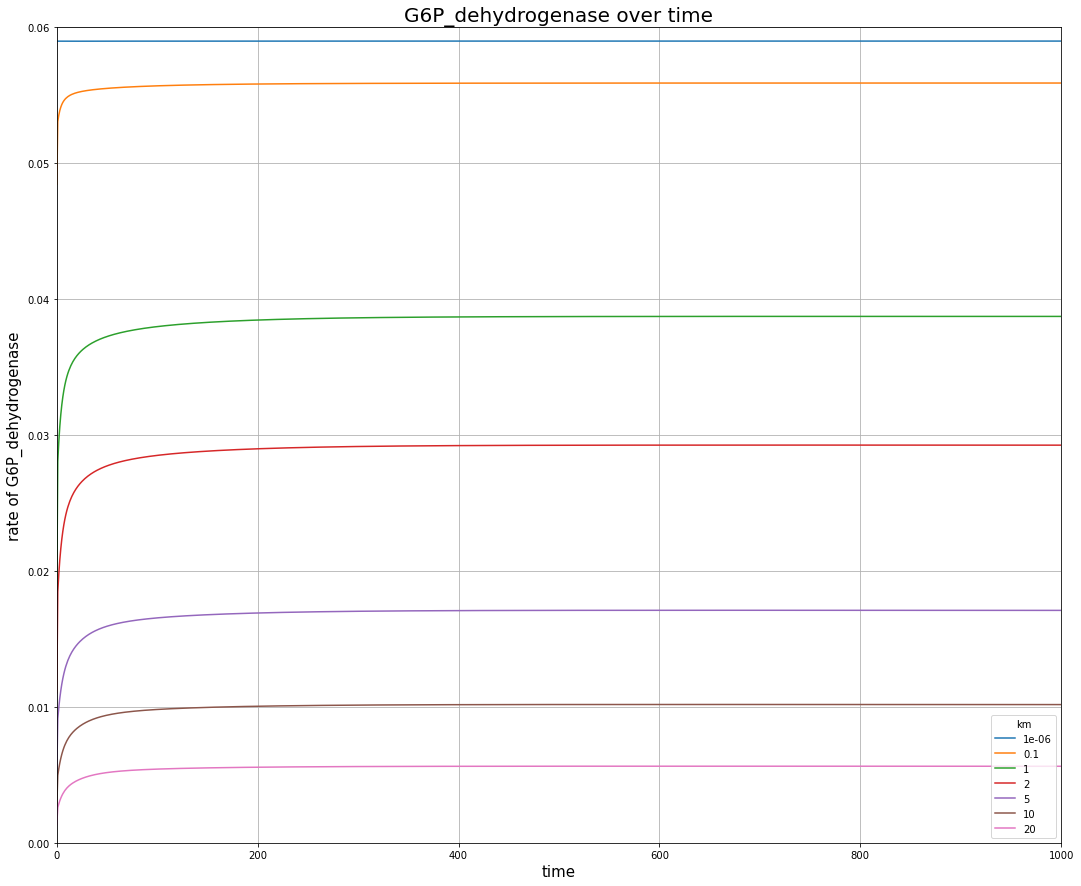

None


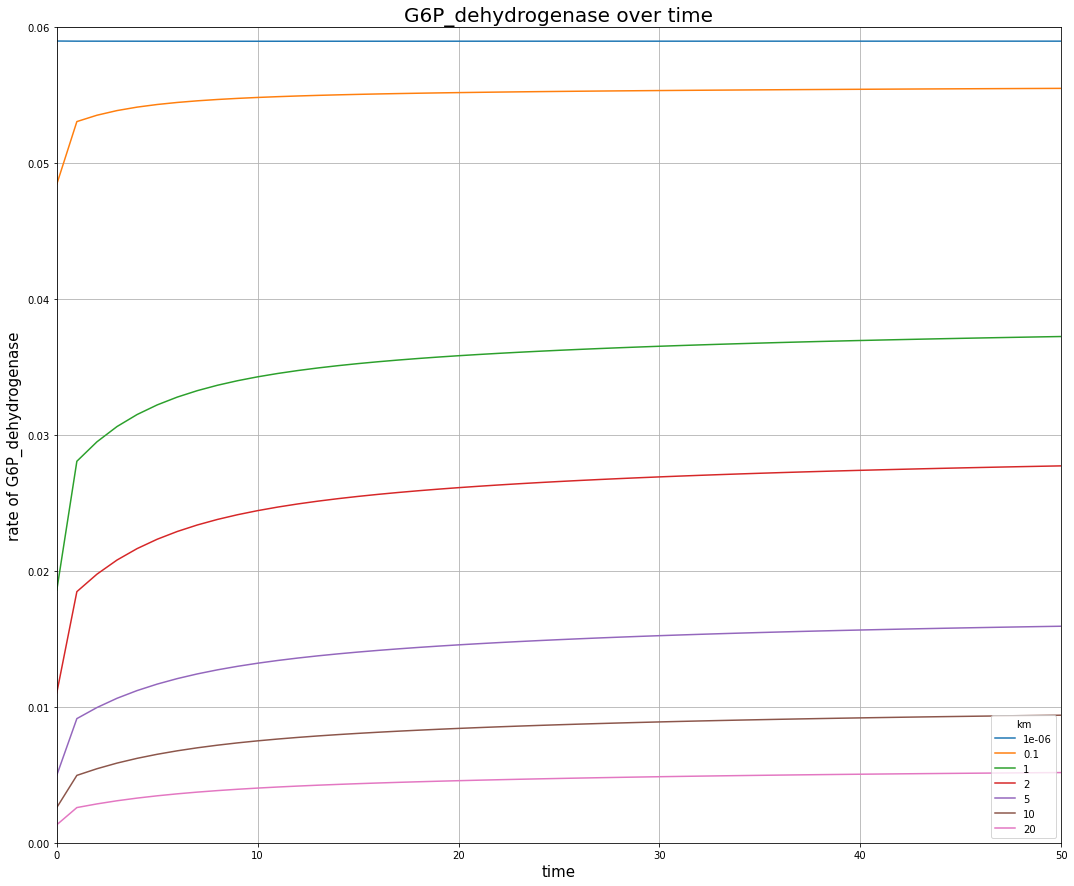

None


In [135]:
#(a) clear 
limy=0.06
limly=0
print(rates_time_k('G6P_dehydrogenase'))

limy=0.06
limly=0
limx=50
limlx=0
print(rates_time_k('G6P_dehydrogenase'))

# Figure 17: Rate of RuBisCo over time

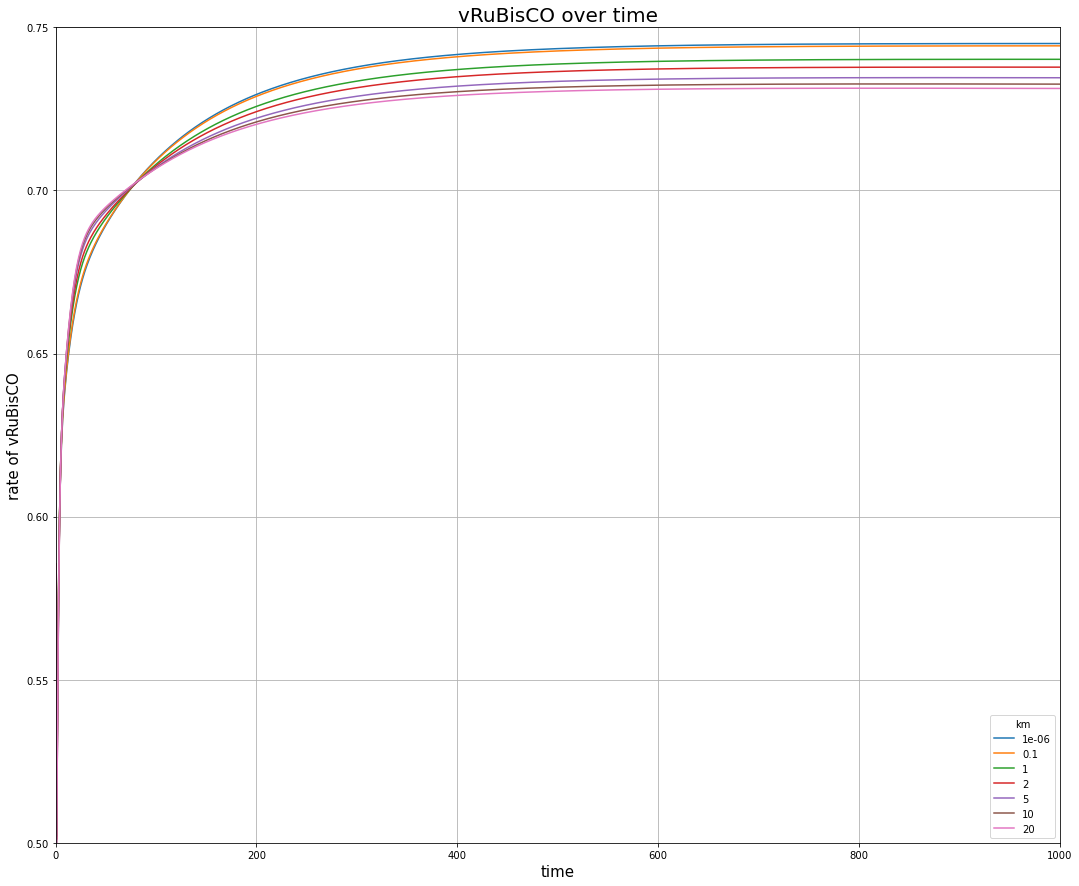

None


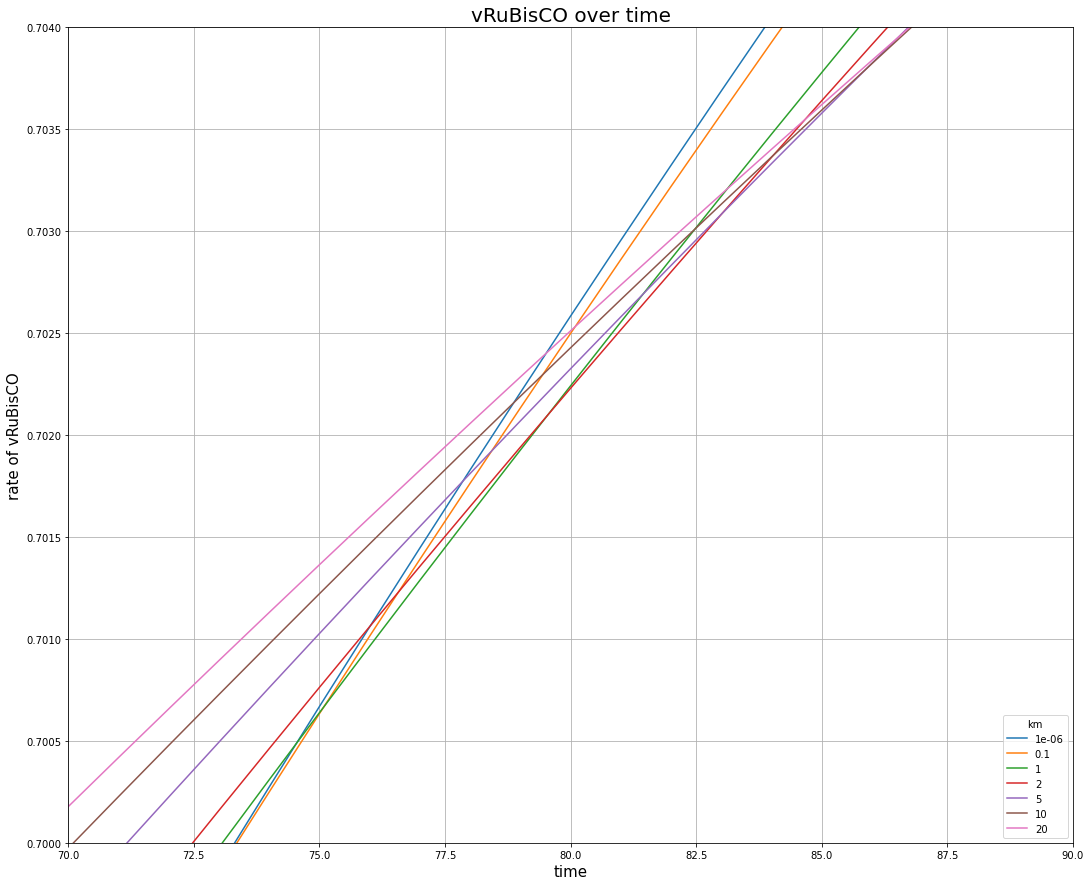

None


In [136]:
#(a) clear 
limly=0.50
limy=0.750
limlx=0
limx=1000
print(rates_time_k('vRuBisCO'))

#(b) zoomed
limly=0.7000
limy=0.7040

limlx=70
limx=90

print(rates_time_k('vRuBisCO'))

# Figure 18 Rate of starch synthesis over time

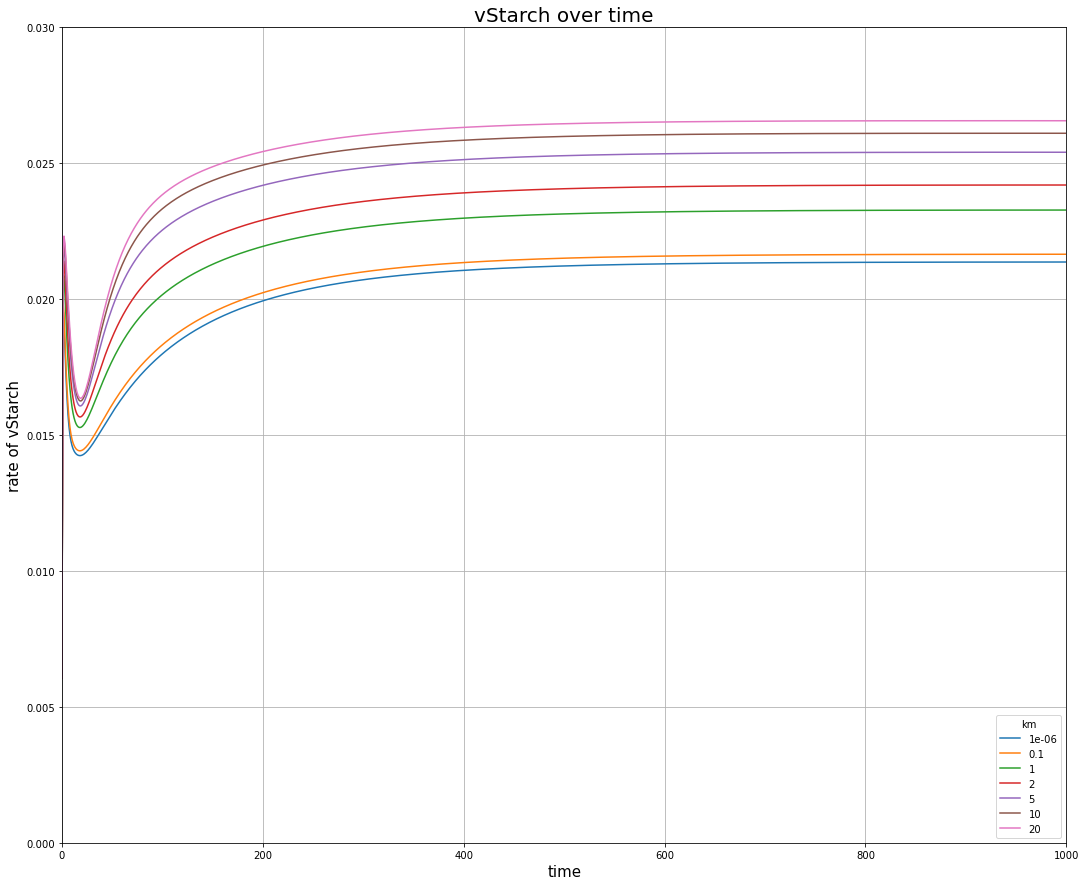

None


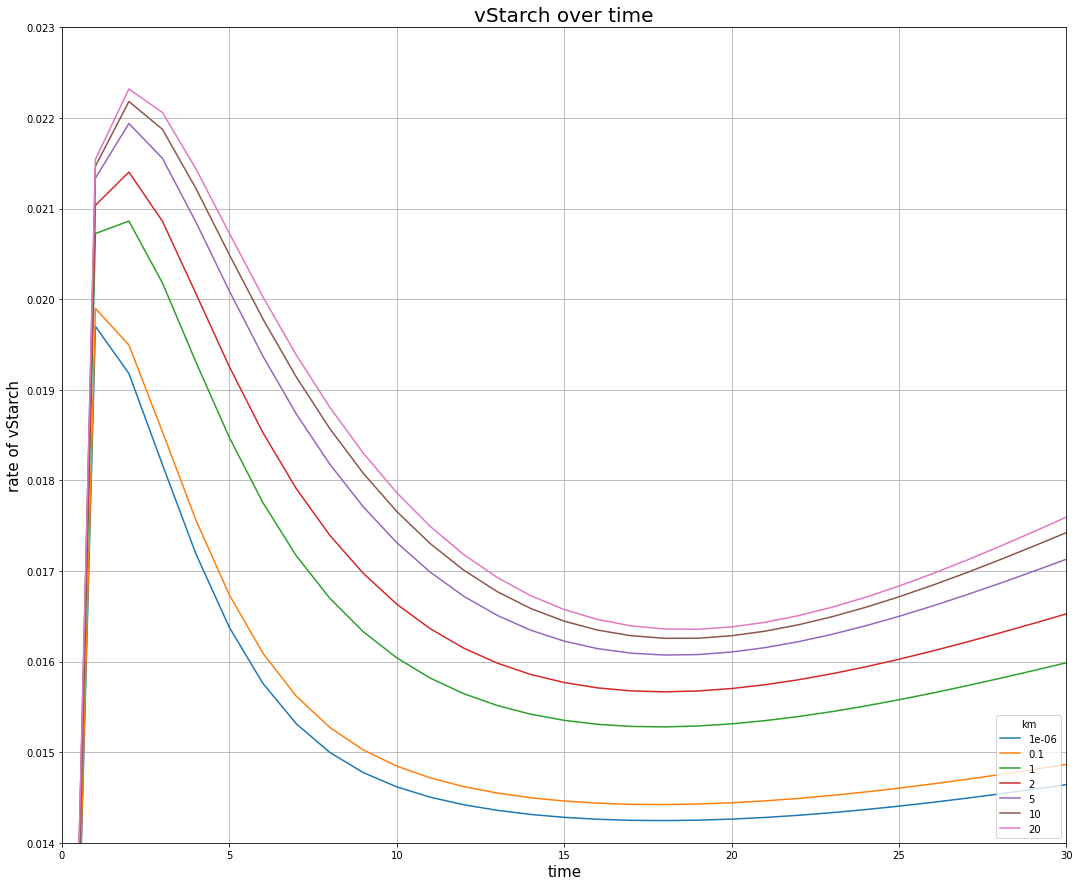

None


In [137]:
#(a) clear 
limy=0.03
limly=0.
limlx=0
limx=1000
print(rates_time_k('vStarch'))

#(b) zoomed
limly=0.014
limy=0.023
limlx=0
limx=30
print(rates_time_k('vStarch'))

# Figure 19 Rates of Triose-Phosphate Transporter over time

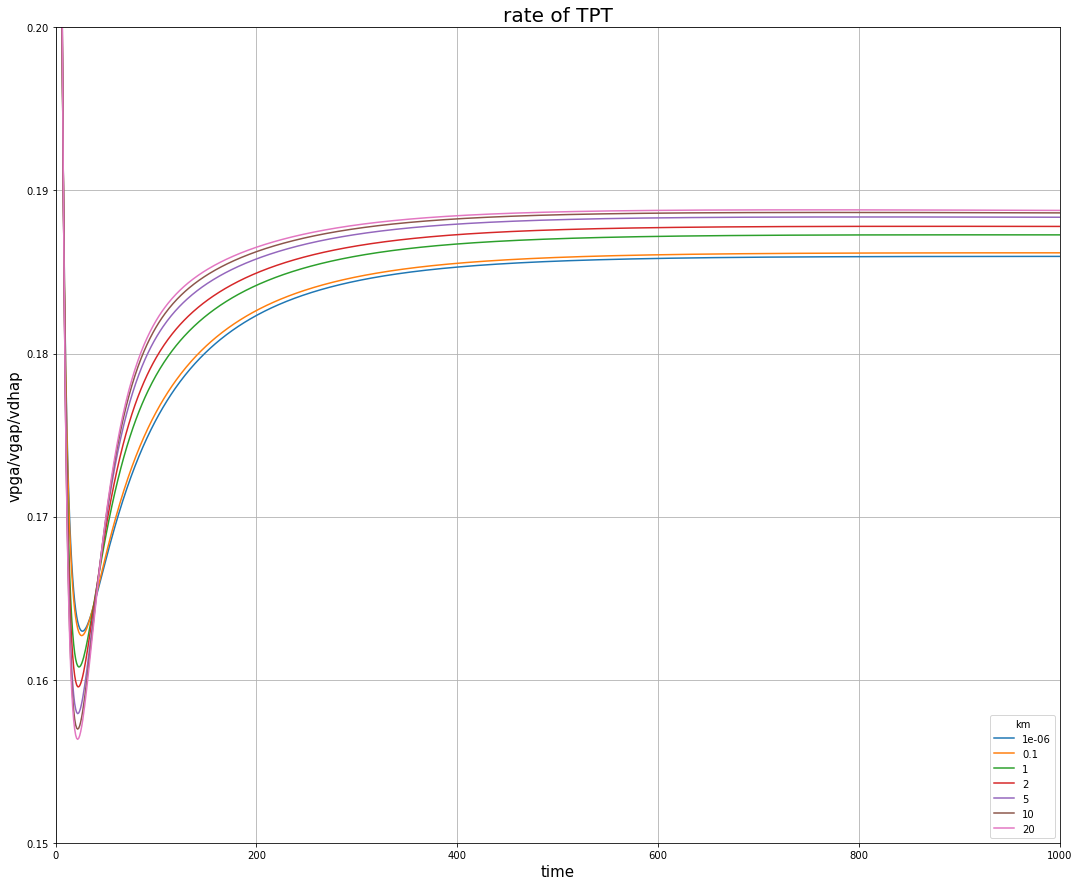

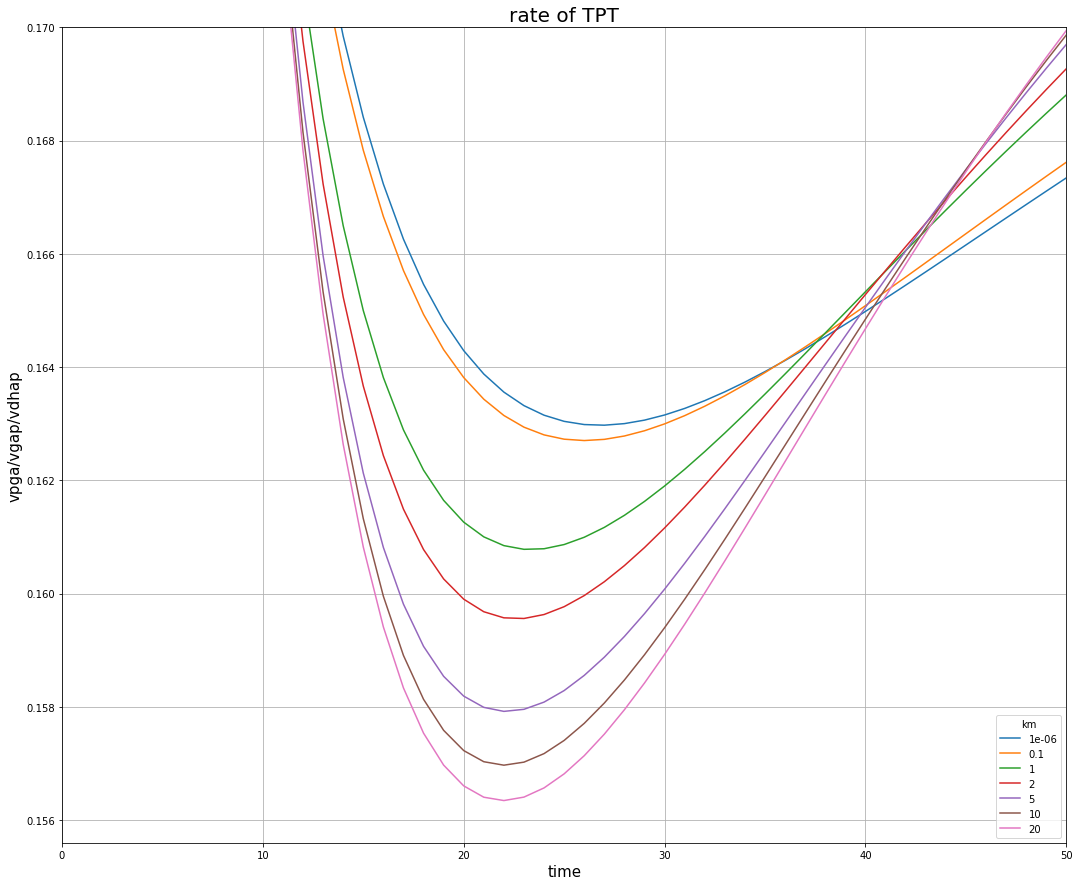

In [138]:
#(a) clear 
for i in klist:
    s.model.update_parameter('km19',i)
    s.initialise(y0)
    s.simulate(1000,steps=1000)
    rates=s.get_fluxes_dict()['vpga']+s.get_fluxes_dict()['vgap']+s.get_fluxes_dict()['vdhap']
    plt.plot(s.get_time(),rates,label=i)
    #instead of 2 x almost the same code, for
    #print('kvalue:',i)
    plt.xlabel("time", fontsize=15) 
    plt.ylabel("vpga/vgap/vdhap",fontsize=15)
    plt.title("rate of TPT", fontsize=20)
    plt.ylim(0.15,0.2)
    plt.xlim(0,1000)
    plt.legend(title="km", loc="lower right")

plt.grid()        
plt.show()

#(b) zoomed
for i in klist:
    s.model.update_parameter('km19',i)
    s.initialise(y0)
    s.simulate(1000,steps=1000)
    rates=s.get_fluxes_dict()['vpga']+s.get_fluxes_dict()['vgap']+s.get_fluxes_dict()['vdhap']
    plt.plot(s.get_time(),rates,label=i)
    #print('kvalue:',i)
    plt.xlabel("time", fontsize=15) 
    plt.ylabel("vpga/vgap/vdhap",fontsize=15)
    plt.title("rate of TPT", fontsize=20)
    plt.ylim(0.1556,0.170)
    plt.xlim(0,50)
    plt.legend(title="km", loc="lower right")

plt.grid()        
plt.show()


using a new model for tests and preparing a list for the future k19-values and a dictionary which contents a list(as value) for each variable(as Key) 

# k19 loop for steady state concentrations

function with a loop for different 'k19' values; outputs steady State concentrations for every variable and every k19 value

"argumentk" to determine the K-values e.g. = range(0,1000,100)
"argumentp=1" to activate Plots for each k

In [139]:
import copy
kloop =  copy.deepcopy(m) 
loop = Simulator(kloop)

dct = {}
klist = []
for i in variables:
    dct['lst_%s' % i] = []
    

In [140]:
from collections import defaultdict

def steady_dict_k(argumentk, argumentp):
    
    for i in argumentk:
        
        klist.append(i)
        loop.model.update_parameter('km19', i)
        loop.initialise(y0)
        loop.simulate(3000, steps=1000)
        if argumentp == 1:
            loop.plot_grid([['G6P', 'RU5P'], ['NADP', 'NADPH'], ['ATP', 'ADP']], sharey=False, xlabels="time [s]", ylabels="concentration [mM]") 
            plt.title("Km19-value= %s" %i)
            loop.plot()
            plt.xlabel("time [s]")
            plt.ylabel("concentration [mM]")
            plt.show()

        for j in variables: 
            stdys = loop.get_variable('%s' % j)
            dct['lst_%s' % j].append(stdys[-1])
        if argumentp == 1:
            for key in dct: 
                print("Steady State concentration for km19=",i,key, ':',((dct[key][-1]))) 
    return(dct)


In [141]:
kloop =  copy.deepcopy(m) 
loop = Simulator(kloop)

dct = {}
klist = []
for i in variables:
    dct['lst_%s' % i] = []
    

calling up my function 

In [142]:
dctsty200 = (steady_dict_k(range(1,200,1), 0))
print(dctsty200)

{'lst_PQ': [10.738762913171527, 10.992201357467836, 11.149544263747194, 11.257767988765746, 11.33709721571407, 11.397869637382435, 11.445972735869923, 11.48502285999624, 11.51737138573146, 11.544615863030293, 11.567881110492406, 11.587983065051505, 11.605527461031203, 11.620975438480771, 11.634681828675328, 11.646926404651252, 11.6579315488439, 11.667876710458414, 11.676908402970382, 11.685147116299106, 11.692692724051833, 11.699629867340922, 11.706028885163681, 11.711950338172528, 11.717445784404536, 11.722559773000512, 11.727330245240507, 11.731791146088698, 11.735971757890525, 11.739897362148783, 11.743590125088668, 11.747072303838996, 11.750358706036614, 11.753467888537285, 11.756412030263112, 11.759204292131317, 11.761856104556797, 11.764378764139334, 11.766780423611792, 11.769070066376907, 11.771255099316019, 11.773342606099582, 11.775339187278503, 11.777250471225537, 11.779081750142014, 11.780838188208532, 11.782524077594953, 11.784143517100233, 11.785700682281576, 11.7871988558

printing the result in a table

df = pd.DataFrame(data=dctsty300, index=klist)
print(df)

In [143]:
print(klist)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]


In [144]:
print(dct)

{'lst_PQ': [10.738762913171527, 10.992201357467836, 11.149544263747194, 11.257767988765746, 11.33709721571407, 11.397869637382435, 11.445972735869923, 11.48502285999624, 11.51737138573146, 11.544615863030293, 11.567881110492406, 11.587983065051505, 11.605527461031203, 11.620975438480771, 11.634681828675328, 11.646926404651252, 11.6579315488439, 11.667876710458414, 11.676908402970382, 11.685147116299106, 11.692692724051833, 11.699629867340922, 11.706028885163681, 11.711950338172528, 11.717445784404536, 11.722559773000512, 11.727330245240507, 11.731791146088698, 11.735971757890525, 11.739897362148783, 11.743590125088668, 11.747072303838996, 11.750358706036614, 11.753467888537285, 11.756412030263112, 11.759204292131317, 11.761856104556797, 11.764378764139334, 11.766780423611792, 11.769070066376907, 11.771255099316019, 11.773342606099582, 11.775339187278503, 11.777250471225537, 11.779081750142014, 11.780838188208532, 11.782524077594953, 11.784143517100233, 11.785700682281576, 11.7871988558

# Figure 20 : Steady state concentrations in dependency of the OPP

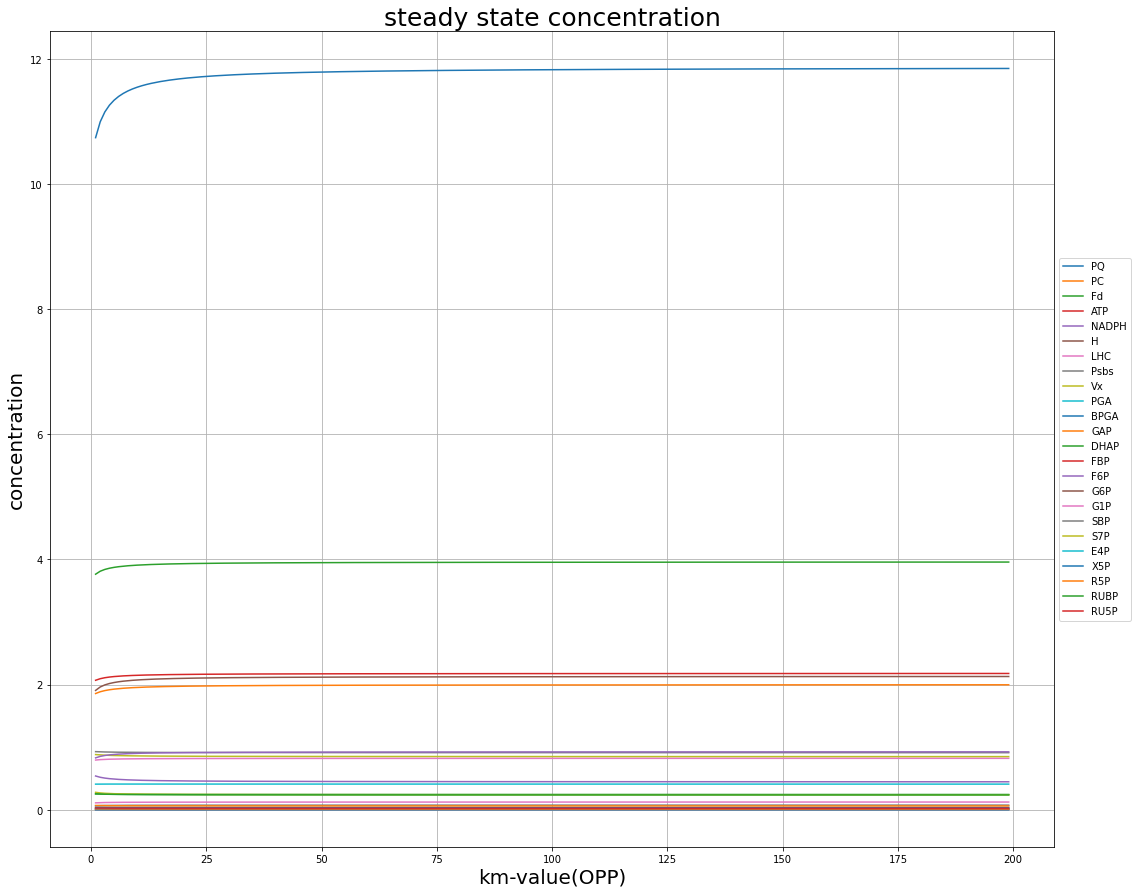

In [145]:
for i in variables:
    plt.plot(klist,dct['lst_%s' % i],label="%s"%i)

plt.xlabel("km-value(OPP)", fontsize = 20) 
plt.ylabel("concentration", fontsize=20)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("steady state concentration", fontsize=25)
plt.grid()
plt.show()


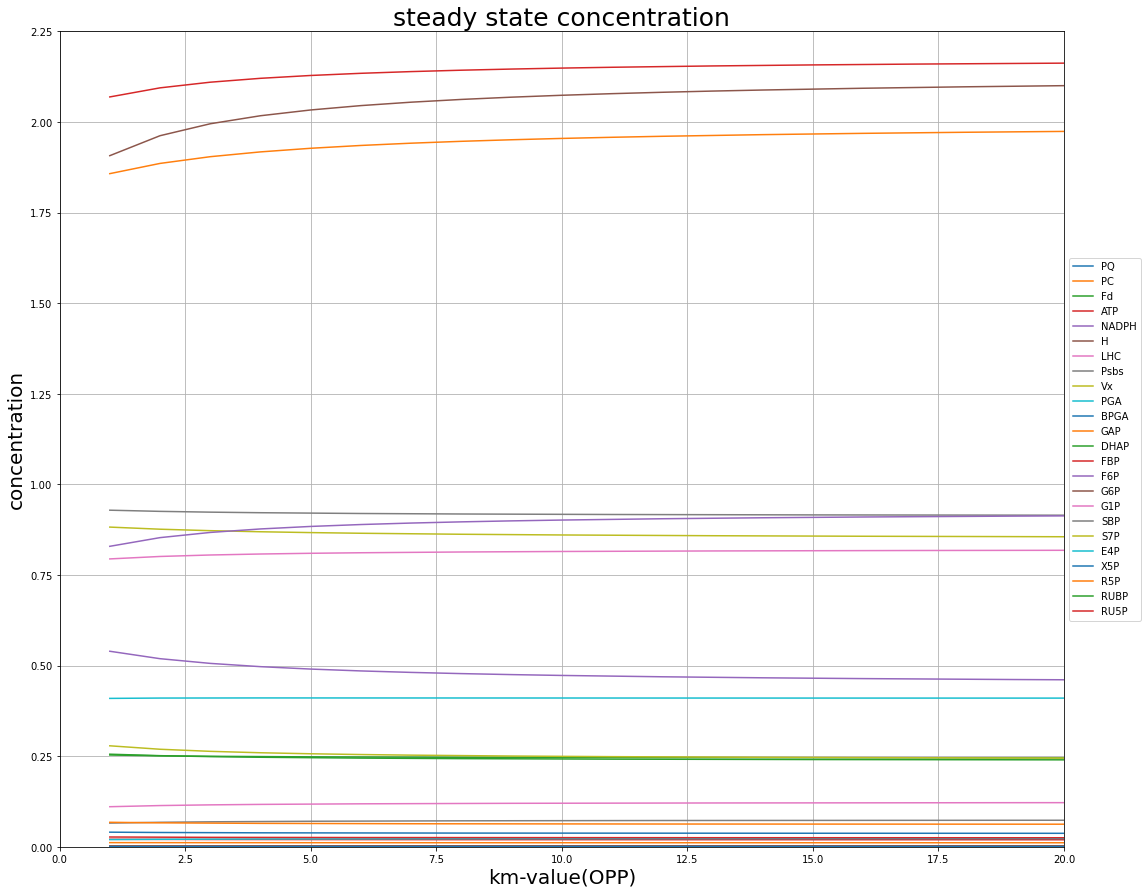

In [147]:
for i in variables:
    plt.plot(klist,dct['lst_%s' % i],label="%s"%i)

plt.xlabel("km-value(OPP)", fontsize = 20) 
plt.ylabel("concentration", fontsize=20)
plt.xlim(0,20)
plt.ylim(0,2.25)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("steady state concentration", fontsize=25)
plt.grid()
plt.show()


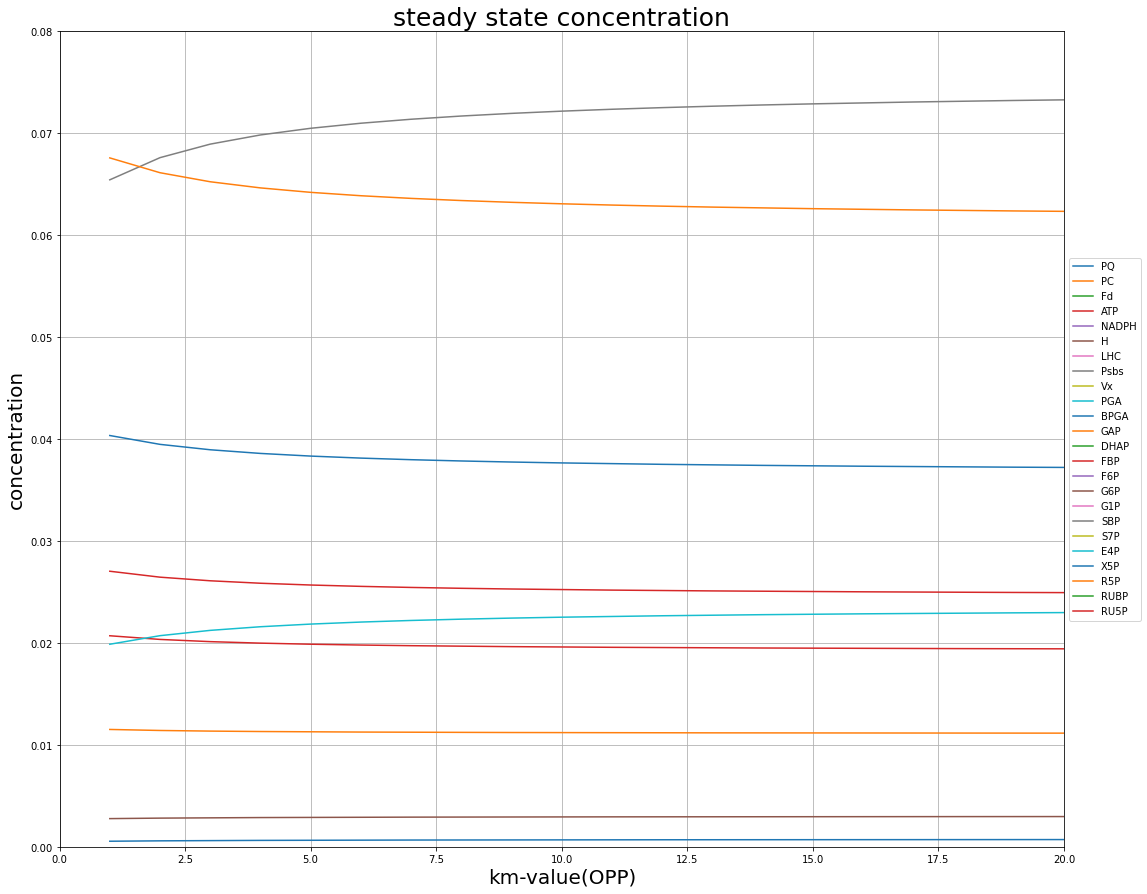

In [148]:
for i in variables:
    plt.plot(klist,dct['lst_%s' % i],label="%s"%i)

plt.xlabel("km-value(OPP)", fontsize = 20) 
plt.ylabel("concentration", fontsize=20)
plt.xlim(0,20)
plt.ylim(0,0.08)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("steady state concentration", fontsize=25)
plt.grid()
plt.show()


# Function for steady state rates

In [149]:
limly=0
limy=10
limlx=0
limx=1000

def steady_rates_k(vinrate, klist):
    dct2 = {}
    lst_vvalues = []

    for i in range(len(klist)):

        for j in variables:
            dct2[j] = dct['lst_%s' % j][i]

        vvalue = loop.model.get_fluxes_dict(dct2)['%s' % vinrate]
        lst_vvalues.append(vvalue)
    #print(lst_vvalues)

    plt.plot(klist,lst_vvalues)
    plt.xlabel("km19-value", fontsize=15)
    plt.ylabel("rate of %s" % vinrate, fontsize=15)
    #plt.legend(loc='center left')
    plt.ylim(limly,limy)
    plt.xlim(limlx,limx)
    plt.title("reaction rate of %s in steady state" % vinrate, fontsize=20)
    plt.grid()
    plt.show()

# Figure 21: Steady state rate of RuBisCO in relation to the OPP


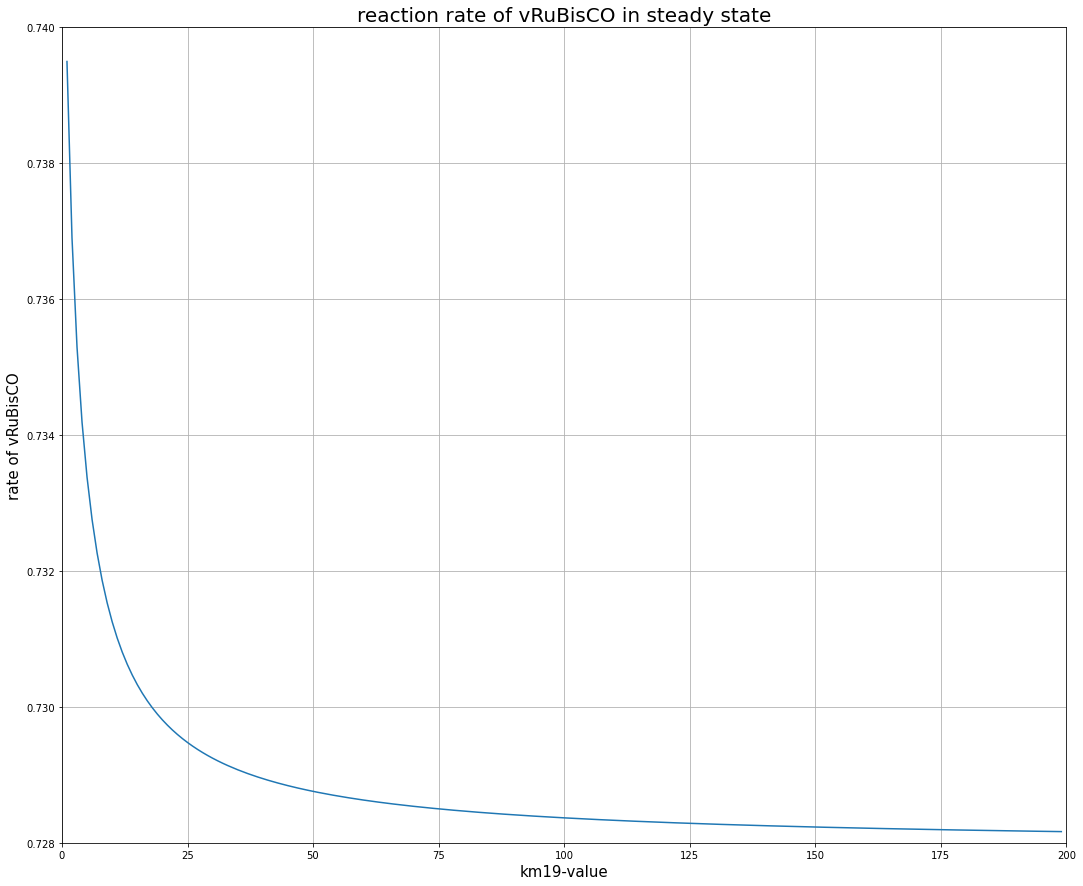

None


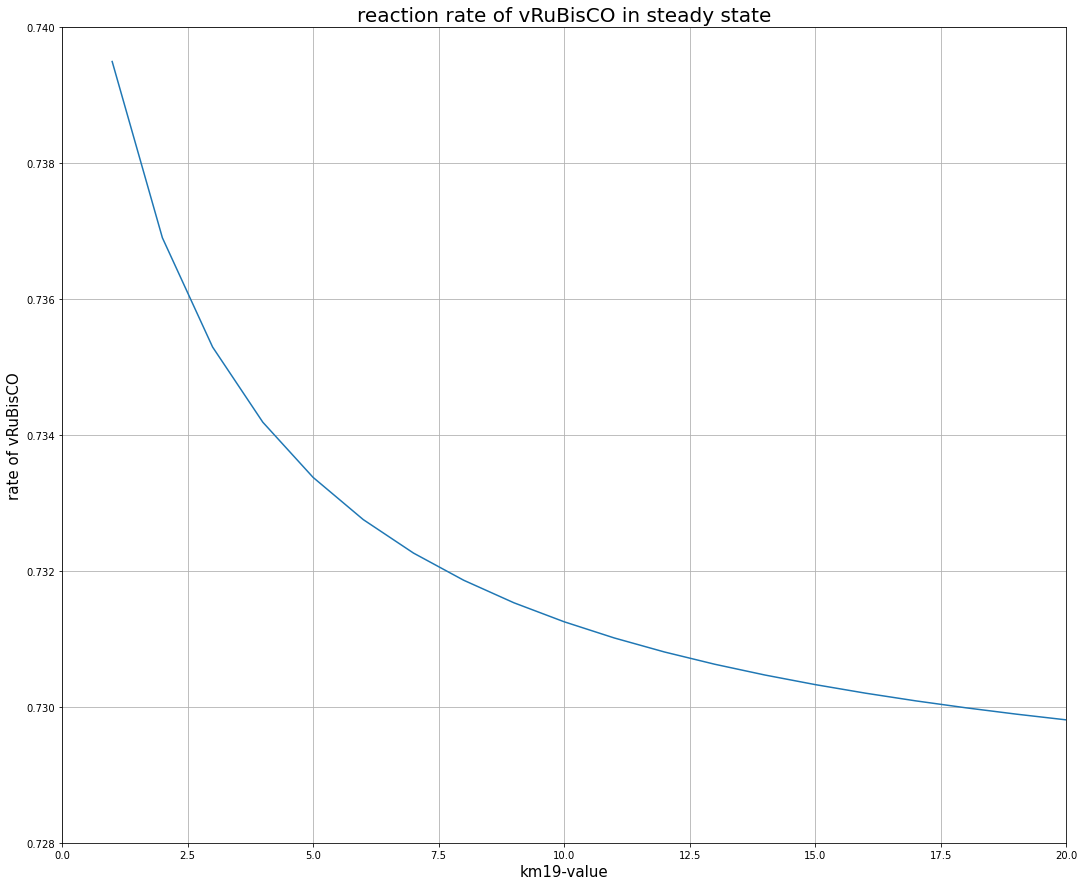

None


In [152]:
limly=0.728
limy=0.740
limlx=0
limx=200

print(steady_rates_k('vRuBisCO', klist))

limly=0.728
limy=0.740
limlx=0
limx=20
print(steady_rates_k('vRuBisCO', klist))


# Figure 22: Steady state rate of starch synthesis in relation to the OPP


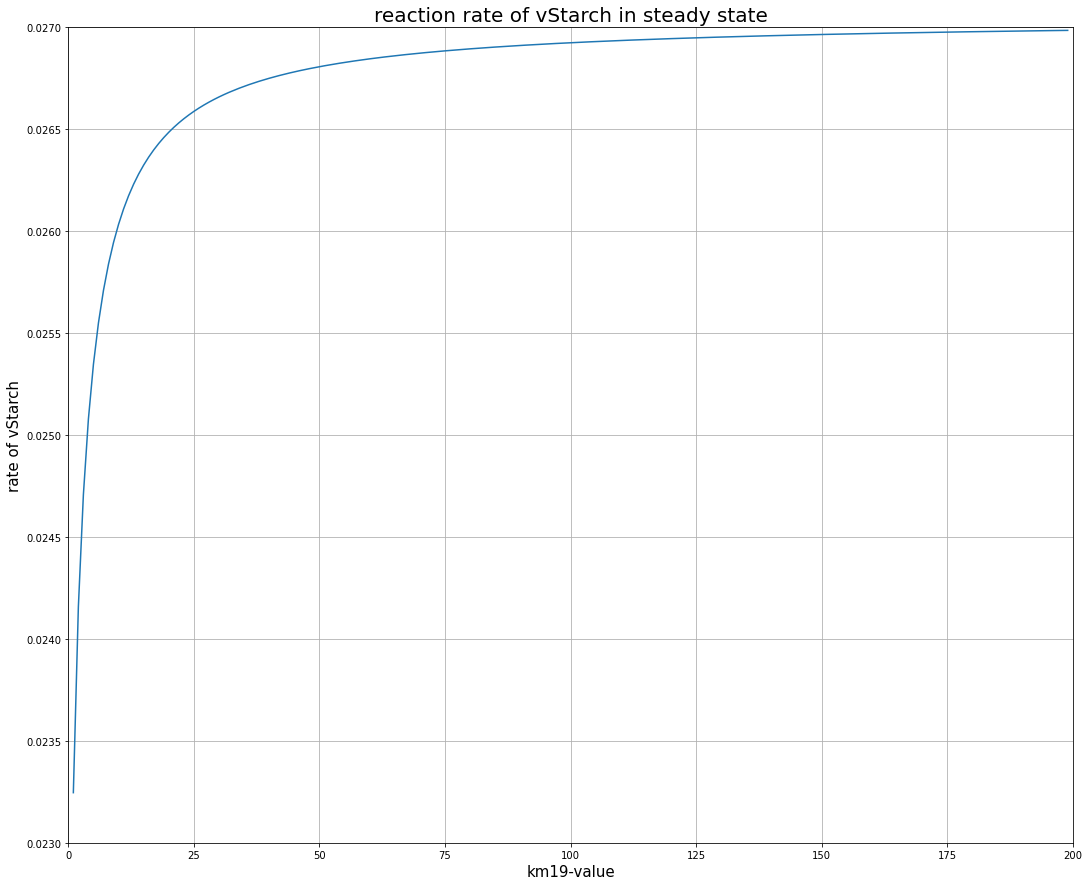

None


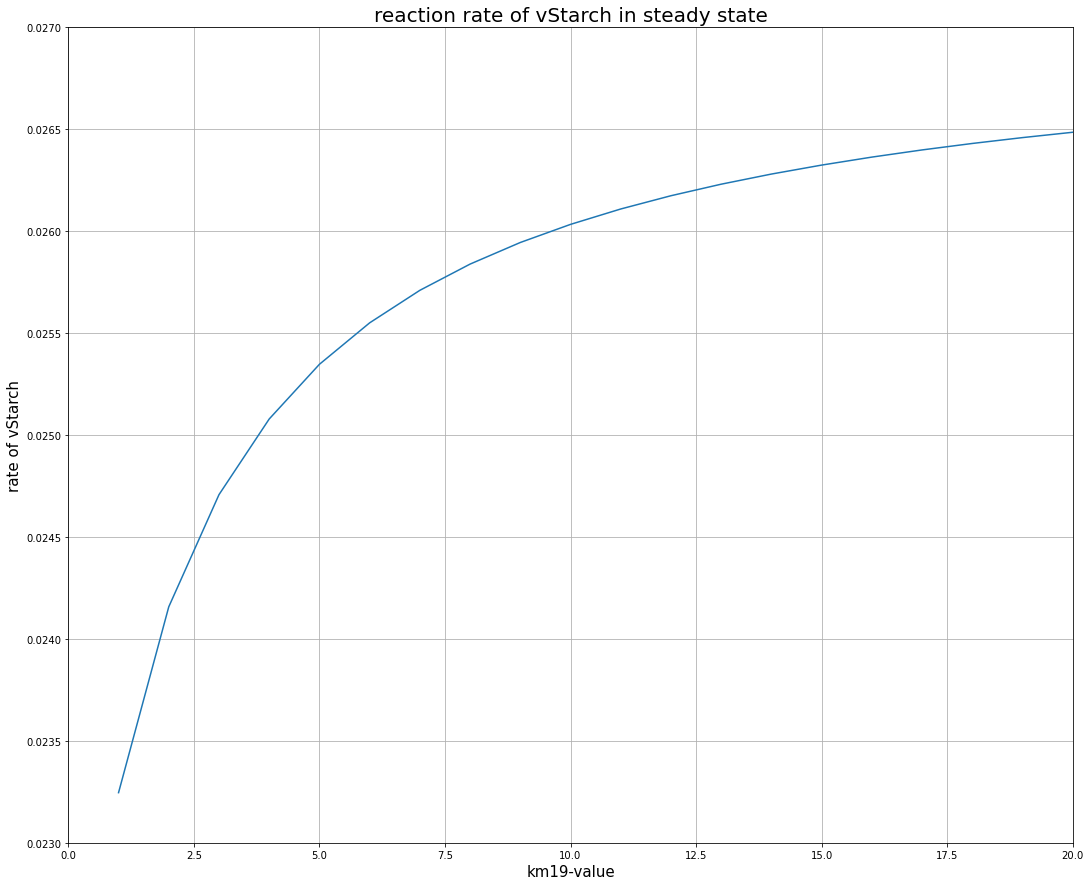

None


In [154]:
limly=0.0230
limy=0.027
limlx=0
limx=200

print(steady_rates_k('vStarch', klist))

limly=0.0230
limy=0.027
limlx=0
limx=20
print(steady_rates_k('vStarch', klist))


# Figure 23: Rate of TPT in relation to OPP


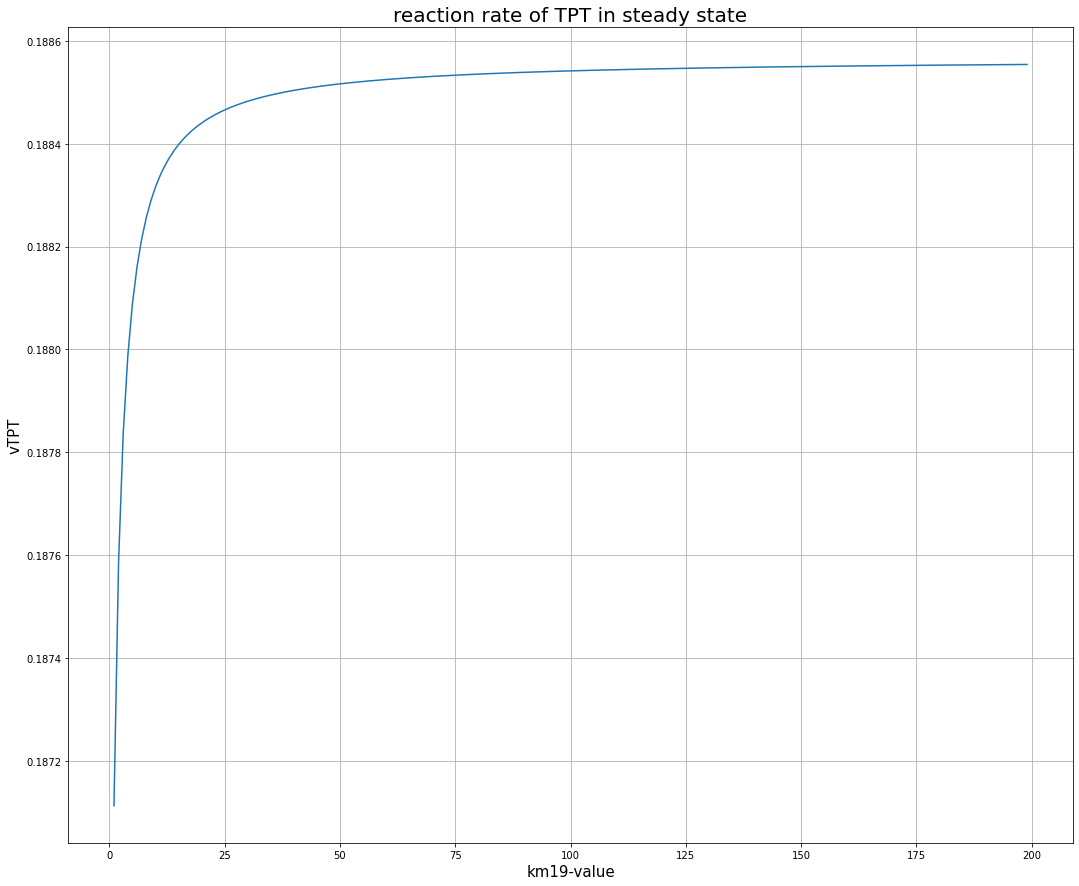

In [155]:
dct2 = {}
lst_vvalues = []

for i in range(len(klist)):

    for j in variables:
        dct2[j] = dct['lst_%s' % j][i]

    vvalue = loop.model.get_fluxes_dict(dct2)['vpga'] + loop.model.get_fluxes_dict(dct2)['vgap']+loop.model.get_fluxes_dict(dct2)['vdhap']
    lst_vvalues.append(vvalue)
#print(lst_vvalues)

#plt.figure(figsize=[15,15])
plt.plot(klist,lst_vvalues)
plt.xlabel("km19-value", fontsize = 15)
plt.ylabel("vTPT", fontsize=15)
#plt.xlim(0,15)
#plt.legend()
plt.title("reaction rate of TPT in steady state", fontsize=20)
plt.grid()
plt.show()



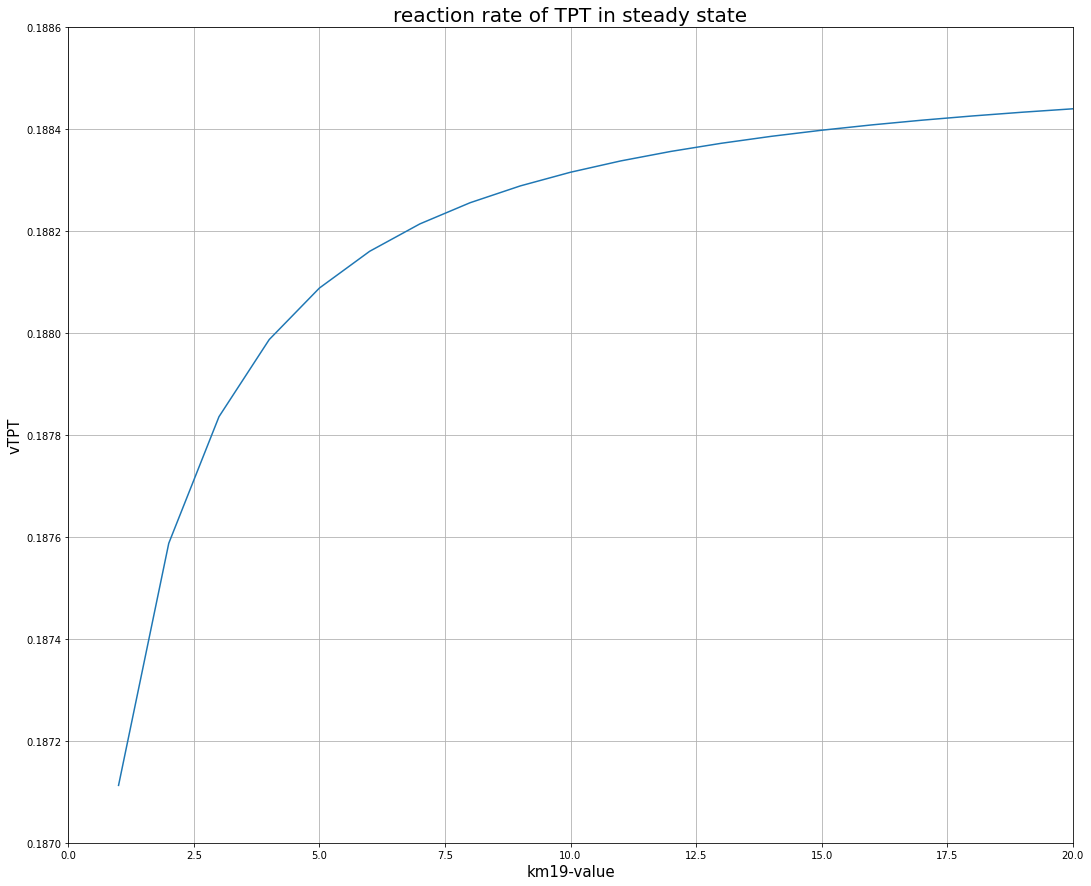

In [159]:
dct2 = {}
lst_vvalues = []
for i in range(len(klist)):

    for j in variables:
        dct2[j] = dct['lst_%s' % j][i]

    vvalue = loop.model.get_fluxes_dict(dct2)['vpga'] + loop.model.get_fluxes_dict(dct2)['vgap']+loop.model.get_fluxes_dict(dct2)['vdhap']
    lst_vvalues.append(vvalue)
#print(lst_vvalues)

#plt.figure(figsize=[15,15])
plt.plot(klist,lst_vvalues)
plt.xlabel("km19-value", fontsize = 15)
plt.ylabel("vTPT", fontsize=15)
plt.xlim(0,20)
plt.ylim(0.1870,0.1886)
#plt.legend()
plt.title("reaction rate of TPT in steady state", fontsize=20)
plt.grid()
plt.show()



just a test to look if the G6P Shunt is actually proportionally changed by changing the k_OPP value

# Light-Dark-Light Simulations

In [162]:
start_time = time.time()


start_time = time.time()

def LDL(s, y0, Tmax, intensity, darkphase, km19value):  
    '''Simple Light-Dark-Light simulation'''
        
    s.initialise(y0)
    s.update_parameters({'pfd': intensity})
    s.update_parameter('km19', 200.)
    s.simulate(300, steps=600, **{'atol':1.e-14}) #FIXME: this part I hate. I needed to fix integration steps to match Nimas previous work, otherwise doesn't converge
    s.update_parameter('pfd', 5.)
    s.update_parameter('km19', km19value)
    s.simulate(500, steps=200, **{'atol':1.e-14})  #I needed to make it smaller from the default, otherwise integration problems  
    s.update_parameter('pfd', intensity)
    s.update_parameter('km19', 200.)

    s.simulate(800, steps=300, **{'atol':1.e-14})
        
    return s, s.model


print (time.time() - start_time, 's')


def LDL_PAM(s, y0, Tmax, intensity, darkphase, Tflash=60.):  
    '''Simple Light-Dark-Light simulation with saturating pulses of light every Tflash seconds'''
        
    s.initialise(y0)
    s.update_parameters({'pfd': intensity, 'Ton': 300, 'Toff':300+darkphase, 'dT': Tflash})

    t=0
    Tmax=1800
    while t < Tmax :   
        #turn on the saturating pulse of light of Tflash length
        if t%s.model.get_parameter('dT') == 0:
            s.update_parameter('pfd', 5000)
            s.simulate(t+0.8)
        else:
            #switch on the light except for the dark period
            #t+dT-Tflash is the time to the next flash
            if t> s.model.get_parameter('Ton') or t<s.model.get_parameter('Toff'):
                s.update_parameter('pfd', 5.)
            else:
                #put the actinic light
                s.update_parameter('pfd', intensity)
            new_t = t+s.model.get_parameter('dT')-0.8
            s.simulate(new_t)  #I needed to make it smaller from the default, otherwise integration problems  
        t = s.get_time()[-1]  
        
    return s, s.model

print (time.time() - start_time, 's')

0.0 s
0.0 s


# Figure: 24 (a) Light-dark-light simulations with and without the OPP

20
50
100
150
200


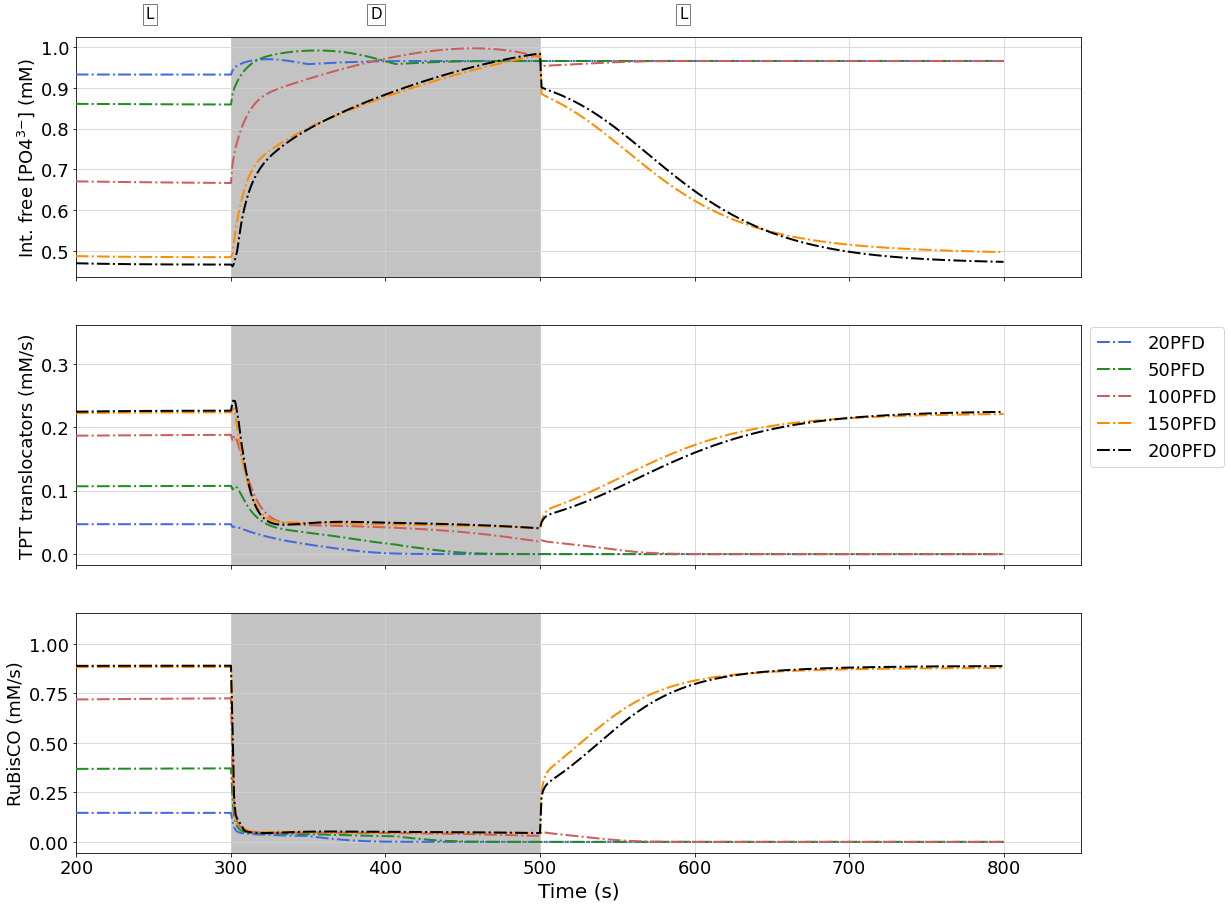

In [163]:
#Shunt slow always Km =200
PhosphoMAX=15

fig, ax = plt.subplots(3,1, sharex=True)
plt.rcParams["figure.figsize"] = (18, 15)
for (aa), subplot in np.ndenumerate(ax):
    subplot.set_xlim(200,850)
    subplot.axvspan(300,500,alpha=0.4,color='dimgray')
    subplot.set_facecolor('white')
    subplot.grid(color='lightgrey')
    subplot.tick_params(axis='both', which='major', labelsize=18)


ax[0].set_ylabel('Int. free [PO4$^{3−}$] (mM)',fontsize=18.)
ax[0].text(245,1.07, 'L', fontsize=15,bbox={'facecolor':'w', 'alpha':0.5, 'pad':3})
ax[0].text(390, 1.07, 'D', fontsize=15,bbox={'facecolor':'w', 'alpha':0.5, 'pad':3})
ax[0].text(590, 1.07, 'L', fontsize=15,bbox={'facecolor':'w', 'alpha':0.5, 'pad':3})
ax[1].set_ylabel('TPT translocators (mM/s)',fontsize=18.)
ax[2].set_ylabel('RuBisCO (mM/s)',fontsize=18.)

ax[2].set_xlabel('Time (s)',fontsize=20.)

col = {20:'royalblue',50:'forestgreen',100:'indianred', 150: 'darkorange', 200:'black'}

for i in [20, 50, 100, 150, 200]: 
    print(i)

    s = Simulator(m)
    s.initialise(y0)
    s, m = LDL(s, y0, Tmax=500, intensity=i,darkphase=200., km19value=200)

    yvex1=s.get_fluxes_dict()['vpga']+s.get_fluxes_dict()['vgap']+s.get_fluxes_dict()['vdhap']
    yrub1=s.get_fluxes_dict()['vRuBisCO']

    ax[0].plot(s.get_time(),s.get_variable('Pi')/PhosphoMAX,color=col[i],linestyle='-.',linewidth=2.,label=str(i)+'PFD',zorder=10.)
    ax[1].plot(s.get_time(),yvex1, color=col[i],linestyle='-.',linewidth=2.,label=str(i)+'PFD',zorder=10.)
    ax[2].plot(s.get_time(),yrub1, color=col[i],linestyle='-.',linewidth=2.,zorder=10.)

ax[1].legend(loc='center left',bbox_to_anchor=(1., 0.7), prop={'size': 18})
#plt.legend()
plt.show()

# Figure: 24 (b) Light-dark-light simulations with and without the OPP

In [164]:
#LDL light: Km = 200 Dark: Km = 0.0000001

start_time = time.time()

def LDL(s, y0, Tmax, intensity, darkphase, km19value):  
    '''Simple Light-Dark-Light simulation'''
        
    s.initialise(y0)
    s.update_parameters({'pfd': intensity})
    s.update_parameter('km19', 200)
    s.simulate(300, steps=600, **{'atol':1.e-14}) #FIXME: this part I hate. I needed to fix integration steps to match Nimas previous work, otherwise doesn't converge
    s.update_parameter('pfd', 5.)
    s.update_parameter('km19', km19value)
    s.simulate(500, steps=200, **{'atol':1.e-14})  #I needed to make it smaller from the default, otherwise integration problems  
    s.update_parameter('pfd', intensity)
    s.update_parameter('km19', 200)

    s.simulate(800, steps=300, **{'atol':1.e-14})
        
    return s, s.model


print (time.time() - start_time, 's')

0.0 s


20
50
100
150
200


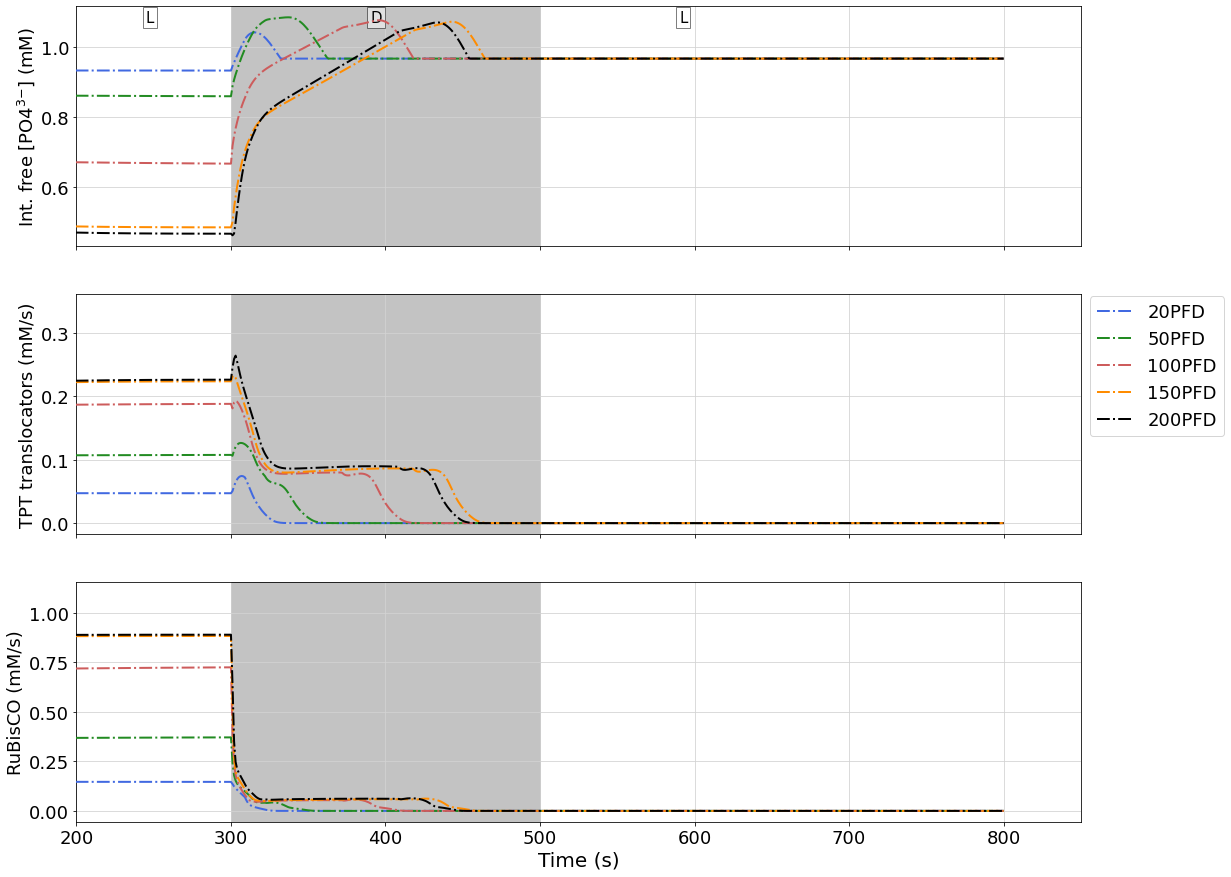

In [165]:
PhosphoMAX=15

fig, ax = plt.subplots(3,1, sharex=True)
plt.rcParams["figure.figsize"] = (18, 15)
for (aa), subplot in np.ndenumerate(ax):
    subplot.set_xlim(200,850)
    subplot.axvspan(300,500,alpha=0.4,color='dimgray')
    subplot.set_facecolor('white')
    subplot.grid(color='lightgrey')
    subplot.tick_params(axis='both', which='major', labelsize=18)


ax[0].set_ylabel('Int. free [PO4$^{3−}$] (mM)',fontsize=18.)
ax[0].text(245,1.07, 'L', fontsize=15,bbox={'facecolor':'w', 'alpha':0.5, 'pad':3})
ax[0].text(390, 1.07, 'D', fontsize=15,bbox={'facecolor':'w', 'alpha':0.5, 'pad':3})
ax[0].text(590, 1.07, 'L', fontsize=15,bbox={'facecolor':'w', 'alpha':0.5, 'pad':3})
ax[1].set_ylabel('TPT translocators (mM/s)',fontsize=18.)
ax[2].set_ylabel('RuBisCO (mM/s)',fontsize=18.)

ax[2].set_xlabel('Time (s)',fontsize=20.)

col = {20:'royalblue',50:'forestgreen',100:'indianred', 150: 'darkorange', 200:'black'}

for i in [20, 50, 100, 150, 200]: 
    print(i)

    s = Simulator(m)
    s.initialise(y0)
    s, m = LDL(s, y0, Tmax=500, intensity=i,darkphase=200., km19value=0.0000001)

    yvex1=s.get_fluxes_dict()['vpga']+s.get_fluxes_dict()['vgap']+s.get_fluxes_dict()['vdhap']
    yrub1=s.get_fluxes_dict()['vRuBisCO']

    ax[0].plot(s.get_time(),s.get_variable('Pi')/PhosphoMAX,color=col[i],linestyle='-.',linewidth=2.,label=str(i)+'PFD',zorder=10.)
    ax[1].plot(s.get_time(),yvex1, color=col[i],linestyle='-.',linewidth=2.,label=str(i)+'PFD',zorder=10.)
    ax[2].plot(s.get_time(),yrub1, color=col[i],linestyle='-.',linewidth=2.,zorder=10.)

ax[1].legend(loc='center left',bbox_to_anchor=(1., 0.7), prop={'size': 18})
#plt.legend()
plt.show()

In [166]:
#Shunt always on KM = 0.0000001 

start_time = time.time()

def LDL(s, y0, Tmax, intensity, darkphase, km19value):  
    '''Simple Light-Dark-Light simulation'''
        
    s.initialise(y0)
    s.update_parameters({'pfd': intensity})
    s.update_parameter('km19', 0.0000001)
    s.simulate(300, steps=600, **{'atol':1.e-14}) #FIXME: this part I hate. I needed to fix integration steps to match Nimas previous work, otherwise doesn't converge
    s.update_parameter('pfd', 5.)
    s.update_parameter('km19', km19value)
    s.simulate(500, steps=200, **{'atol':1.e-14})  #I needed to make it smaller from the default, otherwise integration problems  
    s.update_parameter('pfd', intensity)
    s.update_parameter('km19', 0.0000001)

    s.simulate(800, steps=300, **{'atol':1.e-14})
        
    return s, s.model


print (time.time() - start_time, 's')

0.0 s


20
50
100
150
200


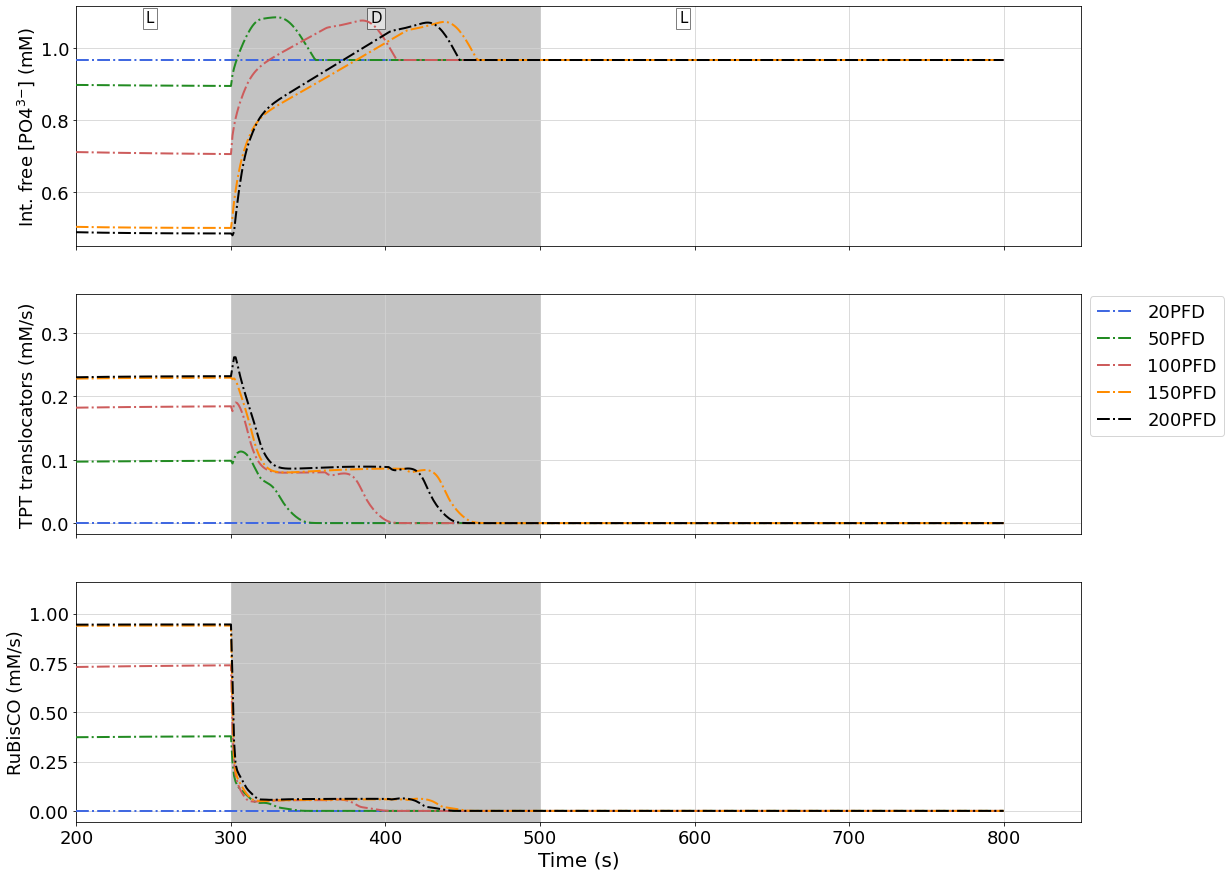

In [167]:
PhosphoMAX=15

fig, ax = plt.subplots(3,1, sharex=True)
plt.rcParams["figure.figsize"] = (18, 15)
for (aa), subplot in np.ndenumerate(ax):
    subplot.set_xlim(200,850)
    subplot.axvspan(300,500,alpha=0.4,color='dimgray')
    subplot.set_facecolor('white')
    subplot.grid(color='lightgrey')
    subplot.tick_params(axis='both', which='major', labelsize=18)


ax[0].set_ylabel('Int. free [PO4$^{3−}$] (mM)',fontsize=18.)
ax[0].text(245,1.07, 'L', fontsize=15,bbox={'facecolor':'w', 'alpha':0.5, 'pad':3})
ax[0].text(390, 1.07, 'D', fontsize=15,bbox={'facecolor':'w', 'alpha':0.5, 'pad':3})
ax[0].text(590, 1.07, 'L', fontsize=15,bbox={'facecolor':'w', 'alpha':0.5, 'pad':3})
ax[1].set_ylabel('TPT translocators (mM/s)',fontsize=18.)
ax[2].set_ylabel('RuBisCO (mM/s)',fontsize=18.)

ax[2].set_xlabel('Time (s)',fontsize=20.)

col = {20:'royalblue',50:'forestgreen',100:'indianred', 150: 'darkorange', 200:'black'}

for i in [20, 50, 100, 150, 200]: 
    print(i)

    s = Simulator(m)
    s.initialise(y0)
    s, m = LDL(s, y0, Tmax=500, intensity=i,darkphase=200., km19value=0.0000001)

    yvex1=s.get_fluxes_dict()['vpga']+s.get_fluxes_dict()['vgap']+s.get_fluxes_dict()['vdhap']
    yrub1=s.get_fluxes_dict()['vRuBisCO']

    ax[0].plot(s.get_time(),s.get_variable('Pi')/PhosphoMAX,color=col[i],linestyle='-.',linewidth=2.,label=str(i)+'PFD',zorder=10.)
    ax[1].plot(s.get_time(),yvex1, color=col[i],linestyle='-.',linewidth=2.,label=str(i)+'PFD',zorder=10.)
    ax[2].plot(s.get_time(),yrub1, color=col[i],linestyle='-.',linewidth=2.,zorder=10.)

ax[1].legend(loc='center left',bbox_to_anchor=(1., 0.7), prop={'size': 18})
#plt.legend()
plt.show()

# Figure 25: Photosynthetic electron transport chain metabolites with and without the OPP


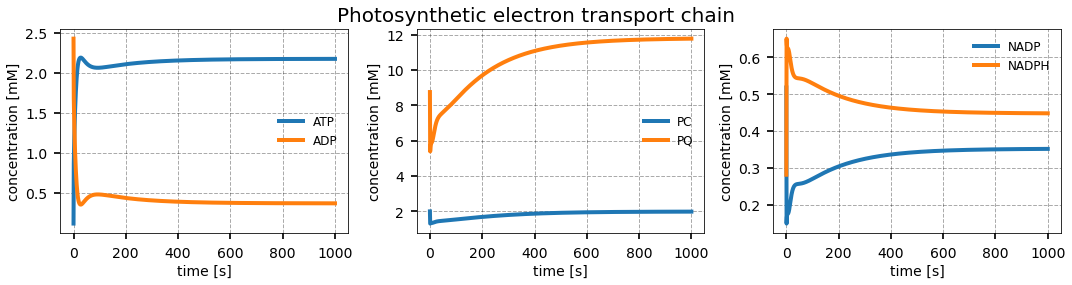

In [168]:
#(a) PETC metabolites without OPP activity (km = 300)
s = Simulator(m)
s.model.update_parameter('pfd',100)
s.model.update_parameter('km19', 300)
s.initialise(y0)
s.simulate(1000, steps=1000)
s.plot_grid([['ATP', 'ADP'], ['PC', 'PQ'], ['NADP', 'NADPH']], sharey=False, xlabels="time [s]", ylabels="concentration [mM]" )
plt.tight_layout()
plt.suptitle("Photosynthetic electron transport chain",fontsize=20)
plt.subplots_adjust(top = 0.9)


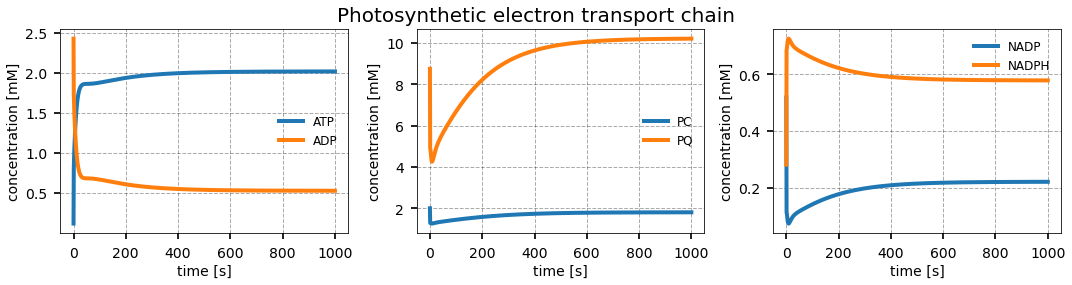

In [169]:
#(b) PETC metabolites with a fast OPP (km=0.0000001)


s = Simulator(m)
s.model.update_parameter('pfd',100)
s.model.update_parameter('km19', 0.0000001)
s.initialise(y0)
s.simulate(1000, steps=1000)
s.plot_grid([['ATP', 'ADP'], ['PC', 'PQ'], ['NADP', 'NADPH']], sharey=False, xlabels="time [s]", ylabels="concentration [mM]" )
plt.tight_layout()
plt.suptitle("Photosynthetic electron transport chain",fontsize=20)
plt.subplots_adjust(top = 0.9)


# Figure 26 : Steady state rate of cyclic and linear electron flow

In [192]:
def steady_rates_k(vinrate, klist):
    dct2 = {}
    lst_vvalues = []

    for i in range(len(klist)):

        for j in variables:
            dct2[j] = dct['lst_%s' % j][i]

        vvalue = loop.model.get_fluxes_dict(dct2)['%s' % vinrate]
        lst_vvalues.append(vvalue)
    print(lst_vvalues)

    #plt.figure(figsize=[15,15])
    plt.plot(klist,lst_vvalues)
    plt.xlabel("km19-value", fontsize=15)
    plt.ylabel("rate of %s" % vinrate, fontsize=15)
   
    #plt.xlim(0,20)
    #plt.ylim(0,8)
    plt.title("reaction rate of %s in steady state" % vinrate, fontsize=20)
    plt.grid() 
    #plt.legend()
    plt.show()

In [195]:
#was calculated before
klist= [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]

dct={'lst_PQ': [10.738762913171527, 10.992201357467836, 11.149544263747194, 11.257767988765746, 11.33709721571407, 11.397869637382435, 11.445972735869923, 11.48502285999624, 11.51737138573146, 11.544615863030293, 11.567881110492406, 11.587983065051505, 11.605527461031203, 11.620975438480771, 11.634681828675328, 11.646926404651252, 11.6579315488439, 11.667876710458414, 11.676908402970382, 11.685147116299106, 11.692692724051833, 11.699629867340922, 11.706028885163681, 11.711950338172528, 11.717445784404536, 11.722559773000512, 11.727330245240507, 11.731791146088698, 11.735971757890525, 11.739897362148783, 11.743590125088668, 11.747072303838996, 11.750358706036614, 11.753467888537285, 11.756412030263112, 11.759204292131317, 11.761856104556797, 11.764378764139334, 11.766780423611792, 11.769070066376907, 11.771255099316019, 11.773342606099582, 11.775339187278503, 11.777250471225537, 11.779081750142014, 11.780838188208532, 11.782524077594953, 11.784143517100233, 11.785700682281576, 11.787198855824261, 11.78864134226693, 11.790031190712895, 11.791371217491985, 11.792663975214463, 11.793912575778757, 11.795118210052127, 11.796283975969837, 11.79741118435792, 11.798501976933085, 11.799557940631958, 11.800581044748549, 11.801572448682737, 11.802533829385746, 11.803466418409426, 11.804371612296157, 11.805250282874894, 11.806103942865773, 11.806933448332748, 11.807739902227615, 11.808524226693706, 11.809287284982359, 11.81002997229448, 11.810753083830713, 11.811457393901831, 11.812143583325398, 11.812812395510187, 11.813464409340245, 11.81409961598314, 11.814720677680883, 11.815326091415143, 11.815917044545072, 11.81649412731566, 11.81705758861826, 11.817608328434181, 11.818146400436142, 11.818672543465535, 11.819186594791768, 11.819689567533059, 11.820181596692843, 11.8206628106378, 11.82113415782694, 11.821595361086448, 11.822046635763773, 11.822489250772513, 11.822922429105386, 11.823346867973392, 11.823762817010325, 11.82417057547081, 11.824570279261915, 11.824962206518965, 11.82534646605508, 11.825723670170245, 11.826093630639688, 11.82645651980597, 11.8268128545545, 11.827162583222982, 11.827506027137145, 11.827842936794278, 11.82817433873784, 11.828499487347461, 11.828819135796415, 11.82913327990685, 11.829441755679845, 11.829745103216236, 11.830043290858834, 11.830336306506712, 11.830624799552272, 11.83090812256566, 11.83118678828456, 11.831461175470672, 11.831731046114914, 11.83199658612995, 11.832257906726761, 11.832515156655603, 11.832768274305629, 11.83301729879773, 11.833262910860908, 11.833504576437585, 11.833742513059146, 11.833977001741756, 11.834207330583174, 11.834435324209654, 11.834659443813894, 11.834880260928589, 11.835097992698431, 11.835312513780556, 11.835524050481544, 11.835732575910393, 11.835937886570273, 11.8361407046364, 11.836340386917152, 11.836537540676131, 11.83673181708687, 11.83692363788641, 11.837112584842806, 11.837299024003437, 11.83748334993992, 11.837664814367221, 11.83784424974939, 11.838021511676146, 11.83819581305433, 11.838368109502637, 11.838538011972354, 11.838706240718123, 11.838872010800927, 11.839035964484115, 11.839197525978546, 11.839357249749565, 11.8395150527061, 11.83967070787975, 11.839824669954274, 11.839976684503489, 11.840126853845584, 11.840275209782588, 11.84042193470816, 11.840566762566437, 11.840709920497048, 11.840851486898751, 11.840991306102781, 11.841129284048131, 11.841266244709134, 11.841401314845793, 11.841534734544206, 11.841666758997206, 11.841797482549783, 11.841926516826987, 11.842054188874608, 11.84218044715354, 11.842305311717448, 11.8424288115588, 11.842550792083399, 11.842671774438456, 11.842791336257084, 11.842909642800901, 11.843026550836674, 11.843142324275597, 11.843256685091811, 11.843370153911062, 11.843482272137798, 11.843593293820984, 11.843703502145186, 11.84381188014509, 11.843919473920709, 11.844025973113713, 11.84413143874537, 11.844235674142103, 11.844338839753503, 11.844441445197306, 11.844542717655651], 'lst_PC': [1.8574950504663688, 1.885708375674943, 1.9042592154633067, 1.9175066114062984, 1.9274798329662202, 1.9352749123393282, 1.941542333813877, 1.9466946568829078, 1.9510071323704625, 1.9546707405575032, 1.95782233774734, 1.960562704336506, 1.962967593050454, 1.965095381151408, 1.966991355298793, 1.968691581703287, 1.9702249314635458, 1.9716148639399638, 1.9728806610132184, 1.9740382630546889, 1.9751009375111068, 1.9760800198506223, 1.9769849277055942, 1.9778238228527358, 1.9786036819978567, 1.979330552691976, 1.9800095759731626, 1.9806454073074748, 1.9812420557559125, 1.9818029759890745, 1.9823311982667853, 1.982829881670687, 1.9833009520157827, 1.9837470859095583, 1.9841698974197142, 1.9845712308327002, 1.9849526768114345, 1.9853158502734451, 1.985661841695465, 1.9859919319877106, 1.986307142887924, 1.986608474236996, 1.9868968627073185, 1.9871730896464124, 1.9874378965083441, 1.9876920224794865, 1.987936064347377, 1.9881705967642789, 1.9883962243373619, 1.9886134010936307, 1.9888225935576547, 1.9890242399518565, 1.9892187339081302, 1.9894064213503126, 1.9895878138321368, 1.989762995456107, 1.9899324533965645, 1.9900963679298798, 1.9902550290910084, 1.9904086726166408, 1.9905575883009246, 1.990701928041544, 1.9908419402470081, 1.9909777965349782, 1.9911097017900599, 1.9912377677574227, 1.9913622233941388, 1.99148319094591, 1.9916008227652955, 1.99171525685568, 1.9918266117024304, 1.9919350185190414, 1.9920405908043541, 1.9921434407346026, 1.992243664768918, 1.9923413706082231, 1.9924366407883995, 1.9925294488722607, 1.992620254258356, 1.9927087654226334, 1.9927951769177519, 1.9928795769276384, 1.9929619935429046, 1.9930425706876225, 1.9931213029985013, 1.9931983077263127, 1.9932735426353299, 1.9933471744771718, 1.9934192149326058, 1.9934896757933382, 1.9935587135638257, 1.9936262682347416, 1.9936923673829252, 1.9937572293107115, 1.993820703656228, 1.9938829057079912, 1.9939438716295887, 1.994003645744548, 1.9940622456546302, 1.9941197114608311, 1.994176055622037, 1.994231380467403, 1.994285637553894, 1.9943388737847503, 1.9943911478387026, 1.994442465027759, 1.9944928599263507, 1.9945423031537046, 1.9945909434478142, 1.99463866603255, 1.9946855929510807, 1.994731711253726, 1.9947770024839149, 1.9948215463696592, 1.9948653360270556, 1.9949083647375323, 1.9949507455796083, 1.9949923580094577, 1.9950332882616473, 1.9950736011442116, 1.9951132535591625, 1.9951522702100275, 1.9951906711779652, 1.9952284776685707, 1.9952656757363203, 1.995302271576326, 1.9953383812580665, 1.9953739068473912, 1.9954088844362974, 1.9954433627886803, 1.995477224174386, 1.9955107576506834, 1.9955437088598185, 1.995576181893338, 1.9956082062426737, 1.9956397589321735, 1.9956708767630595, 1.9957015537943967, 1.9957317506107006, 1.9957615943329865, 1.9957909691851219, 1.9958199806585333, 1.9958485646992257, 1.9958767962892638, 1.9959045967242208, 1.9959320301678203, 1.9959591672545565, 1.995985870206015, 1.9960122874071986, 1.996038392200034, 1.9960640407462953, 1.9960894047631308, 1.996114410487123, 1.9961391873638388, 1.9961635928689296, 1.996187740720445, 1.9962115267574212, 1.996235048579813, 1.9962582895694043, 1.996281209687203, 1.996303886942349, 1.9963262779977702, 1.9963483971860314, 1.996370249002752, 1.9963918684084232, 1.9964131999540191, 1.9964342893146056, 1.9964551480464396, 1.9964757468962697, 1.9964960685123472, 1.9965162588926089, 1.996536161341765, 1.9965558169880582, 1.9965752733834243, 1.9965945424115559, 1.9966135574251322, 1.9966323743733592, 1.9966509831822659, 1.9966693875687933, 1.9966875890684148, 1.9967055660950497, 1.9967234048107971, 1.9967410305830129, 1.9967584736617148, 1.9967757058530449, 1.9967927750411716, 1.9968096296930702, 1.9968263643776631, 1.996842894644399, 1.9968592654366517, 1.9968755268843217, 1.9968914976046868, 1.9969073634189873, 1.9969230686794717, 1.9969386229477968, 1.9969539904753042, 1.996969205847077, 1.996984343221509, 1.9969992790730773], 'lst_Fd': [3.7639892972967344, 3.8115278024737105, 3.8400664787305554, 3.859278913797179, 3.8731515383518738, 3.8836610202549853, 3.8919080202544607, 3.8985570150515154, 3.9040340592975564, 3.9086253896151946, 3.912530663478469, 3.915893521788965, 3.918819968644469, 3.921390051709511, 3.9236652608366334, 3.92569371580263, 3.9275135686187617, 3.9291554826298074, 3.9306443880900246, 3.9320007517595768, 3.933241528880884, 3.9343809348249144, 3.9354308984717097, 3.9364015751853603, 3.9373016261963736, 3.9381385011943952, 3.9389186131453062, 3.9396475697624225, 3.9403302502318516, 3.940970914419931, 3.9415733073183508, 3.9421408489203826, 3.9426763686911355, 3.9431826070594043, 3.943661828016944, 3.9441161545430052, 3.944547477133438, 3.94495753981444, 3.9453478336948575, 3.945719774708038, 3.946074618027937, 3.946413519527944, 3.9467375384320658, 3.947047626862194, 3.9473446627728377, 3.947629463026886, 3.9479027595745477, 3.9481652341163627, 3.9484175295538138, 3.948660217259524, 3.9488938367005084, 3.9491188861726094, 3.949335828980342, 3.949545094494674, 3.9497471036505956, 3.9499421911125743, 3.950130742459135, 3.9503130543848366, 3.9504894426369983, 3.950660184989062, 3.9508255622316186, 3.9509858085270513, 3.951141168544608, 3.951291857707335, 3.9514380884465563, 3.9515800429989243, 3.95171792118, 3.951851887402947, 3.951982110858292, 3.952108743934869, 3.952231932397235, 3.952351816569521, 3.9524685272995876, 3.9525821892393, 3.952692918196841, 3.9528008292474826, 3.952906024518855, 3.9530085802929174, 3.953108677365139, 3.9532063222744043, 3.9533016288482354, 3.9533946835043454, 3.9534855548744723, 3.953574337023332, 3.9536610856170644, 3.953745882448966, 3.9538287694342658, 3.95390983558402, 3.9539891313205646, 3.954066704017115, 3.954142634835989, 3.9542169508957348, 3.954289698915588, 3.954360966875751, 3.9544307574031006, 3.954499132696638, 3.954566135161169, 3.9546318075277274, 3.9546961838180525, 3.9547593047966445, 3.954821201608252, 3.95488192584562, 3.954941495208947, 3.9549999390037986, 3.955057304731001, 3.9551136095299997, 3.95516889086033, 3.955223157943923, 3.9552764732853225, 3.9553288253269554, 3.9553802643163, 3.9554308081937144, 3.9554804664627294, 3.955529279187341, 3.955577260900855, 3.9556244269085123, 3.9556708188836014, 3.955716424812986, 3.9557612800056052, 3.955805414264645, 3.955848829945711, 3.955891548893694, 3.9559335868831647, 3.9559749627900054, 3.9560156856279827, 3.956055767447947, 3.9560952483614846, 3.956134116544005, 3.9561723914947695, 3.956210094162742, 3.9562472041728247, 3.956283809615281, 3.956319851770858, 3.9563553652845473, 3.956390367557949, 3.9564248614472177, 3.956458864578346, 3.9564923830415664, 3.956525416881691, 3.9565580035024426, 3.9565901223495428, 3.956621806816722, 3.956653048409625, 3.956683871817025, 3.956714265209354, 3.9567442510670277, 3.9567738516601056, 3.956803041661425, 3.956831861396103, 3.9568603104837794, 3.956888362132174, 3.956916060363036, 3.956943395501235, 3.956970401574751, 3.9569970513964905, 3.9570233761833395, 3.957049356860657, 3.9570750210817014, 3.957100370219095, 3.957125398082972, 3.9571501289082924, 3.9571745555491704, 3.957198686219024, 3.957222527235969, 3.957246089309285, 3.957269364869011, 3.957292367658657, 3.9573151041038543, 3.957337571364029, 3.957359768946217, 3.957381734302229, 3.9574034346736147, 3.957424883322292, 3.957446093097686, 3.957467072382626, 3.957487806419365, 3.9575083129238995, 3.95752859232361, 3.957548647788371, 3.957568484013762, 3.957588096481422, 3.957607509860167, 3.9576267092351762, 3.957645703176879, 3.9576644894687463, 3.957683080749966, 3.957701467886192, 3.9577196743048995, 3.9577376838002527, 3.9577555092342664, 3.957773164988708, 3.9577906089905524, 3.9578078883956453, 3.9578249917004635, 3.957841923926875, 3.9578586786043695, 3.957875263464565, 3.957891703588898, 3.9579079670774746], 'lst_ATP': [2.069168144216879, 2.0942203784556024, 2.109823266763439, 2.12054048327375, 2.1283771805191445, 2.134365349445413, 2.139093753330637, 2.142923928177039, 2.1460906112039915, 2.1487530246207776, 2.151023069493937, 2.152981746625917, 2.154689128923367, 2.156190776203096, 2.1575218036533714, 2.1587097765010013, 2.1597766108777443, 2.1607399568650583, 2.1616141987843966, 2.162411163093481, 2.1631406621948006, 2.16381094127688, 2.1644289188980395, 2.165000499120035, 2.1655307203261476, 2.166023921081588, 2.166483836030573, 2.166913740089409, 2.1673164800695974, 2.1676945435828054, 2.168050117744988, 2.1683852144307263, 2.1687014739319324, 2.1690005145610187, 2.169283654347379, 2.1695521385549204, 2.1698070757252026, 2.1700494944856454, 2.170280264637728, 2.1705002191964002, 2.1707100952476583, 2.1709105706764444, 2.171102269944862, 2.171285753022137, 2.1714615332874367, 2.1716300948690352, 2.171791865453218, 2.1719472486602287, 2.172096621388146, 2.1722403207358707, 2.1723786646142895, 2.172511945239561, 2.1726404372050863, 2.1727643934517666, 2.172884060713875, 2.1729996358945622, 2.173111350864844, 2.1732193747044772, 2.173323897098655, 2.173425080199604, 2.1735230923386983, 2.17361806845404, 2.1737101550810025, 2.1737994782655012, 2.173886164924862, 2.1739703196078497, 2.1740520640833765, 2.1741314927711954, 2.1742087070529514, 2.174283795339896, 2.174356845227394, 2.1744279393276775, 2.1744971543762435, 2.1745645651675134, 2.174630238746302, 2.174694243847065, 2.174756641462703, 2.1748174717480273, 2.174876853235829, 2.1749347789818767, 2.174991319325357, 2.1750465257188796, 2.1751004391371778, 2.175153115058101, 2.1752045861244578, 2.1752549016905003, 2.1753040836881468, 2.1753521881259172, 2.1753992431701574, 2.1754452769884343, 2.1754903386156696, 2.175534442547992, 2.175577615679418, 2.1756199154763873, 2.1756613365754536, 2.17570191969871, 2.175741688675533, 2.175780669767223, 2.1758188823326106, 2.175856350483072, 2.1758930923096447, 2.175929140397436, 2.1759645038386397, 2.1759991978523057, 2.1760332548113377, 2.176066680985471, 2.1760995015598663, 2.1761317177407875, 2.17616337372394, 2.176194455937375, 2.1762249979377635, 2.1762550100325777, 2.176284493656546, 2.1763134776270654, 2.1763419683984813, 2.176369974842689, 2.176397524229222, 2.1764246057688164, 2.176451240618368, 2.17647744941682, 2.1765032322254023, 2.1765286007467433, 2.1765535658239212, 2.176578137922954, 2.176602322924184, 2.1766261267881846, 2.176649575423834, 2.176672659398439, 2.176695391860794, 2.176717785104836, 2.1767398210412434, 2.1767615680298604, 2.1767829750175216, 2.1768040689696906, 2.1768248594421005, 2.1768453481052794, 2.1768655461531052, 2.176885456346264, 2.1769050774930507, 2.1769244350162604, 2.1769435140685474, 2.176962336339351, 2.1769808935875563, 2.176999205996664, 2.177017259048413, 2.1770350721310043, 2.177052657069285, 2.1770699972209453, 2.177087119355564, 2.177104021641108, 2.1771206860103214, 2.1771371411323517, 2.1771533797942286, 2.177169425118003, 2.1771852580317903, 2.1772008987559612, 2.1772163338318284, 2.177231581762483, 2.177246642281201, 2.1772615123561447, 2.1772762066466558, 2.1772907198664257, 2.1773050571014867, 2.1773192223249374, 2.1773332234103573, 2.177347052223459, 2.177360719749451, 2.1773742301231267, 2.1773875796687157, 2.177400768112906, 2.1774138212185363, 2.177426715763564, 2.1774394597918483, 2.177452063272675, 2.177464530400887, 2.177476850684024, 2.177489036440905, 2.1775010871854086, 2.1775130049559293, 2.177524792922461, 2.177536446546812, 2.177547983246245, 2.1775593926750925, 2.177570680809135, 2.177581844355545, 2.177592892845085, 2.1776038185488202, 2.1776146389935933, 2.1776253417995135, 2.177635935056678, 2.177646430309545, 2.1776567942056073, 2.1776670633173225, 2.177677228136994, 2.1776872918990744, 2.1776972482450123, 2.177707103566266, 2.1777168757246512, 2.177726541030394], 'lst_NADPH': [0.5395923560621967, 0.5190793750038599, 0.5060999999543572, 0.49707753964141693, 0.4904195518349165, 0.48529554060715463, 0.481226224132007, 0.47791441814219604, 0.4751655750980265, 0.4728468052302685, 0.47086414860301395, 0.46914923782140994, 0.46765113463276714, 0.4663310561493673, 0.4651589990790684, 0.4641113371338657, 0.46316923440103686, 0.4623174792440495, 0.4615436491354833, 0.4608375058191215, 0.4601905374747652, 0.45959558440886705, 0.45904662110924493, 0.45853850386519046, 0.4580668346639204, 0.45762782195352214, 0.45721819542784675, 0.45683508898112296, 0.4564760049151834, 0.4561387585091248, 0.45582142590078295, 0.4555222477911373, 0.455239766544701, 0.45497256872519465, 0.4547194842453838, 0.4544794157240417, 0.45425138450799435, 0.4540344867295189, 0.4538279486489387, 0.45363103514864617, 0.45344309375637815, 0.45326352341686516, 0.4530917724136118, 0.4529273445604693, 0.4527697825470365, 0.4526186597791754, 0.45247359399300346, 0.45233422905929693, 0.4522002290089335, 0.4520712947184874, 0.4519471438208891, 0.4518275153257522, 0.45171216638588413, 0.4516008724098725, 0.4514934116033361, 0.4513896090846131, 0.45128926209910913, 0.45119221485489797, 0.4510983013283654, 0.4510073754519596, 0.45091928970130574, 0.45083392076534884, 0.450751139878914, 0.45067083357522, 0.45059288983924156, 0.45051721278346996, 0.4504436969651966, 0.4503722556619645, 0.4503027998362877, 0.4502352490073419, 0.4501695261007529, 0.4501055571431012, 0.4500432731060309, 0.44998260795981465, 0.44992350051795854, 0.44986589019865353, 0.44980972249510576, 0.4497549574059272, 0.4497014997908833, 0.44964934547799534, 0.4495984344510829, 0.44954872112648836, 0.44950016864335984, 0.44945272788723756, 0.44940636891789487, 0.4493610486893173, 0.4493167445346114, 0.44927340974715335, 0.44923101756667727, 0.449189542396483, 0.44914894205337075, 0.4491092014742746, 0.44907029591061415, 0.44903217904341547, 0.4489948492376676, 0.4489582733569956, 0.4489224291187915, 0.44888729394661336, 0.4488528493429898, 0.44881907405165666, 0.4487859513052639, 0.4487534539731405, 0.4487215723793049, 0.44869029090950174, 0.4486595847109828, 0.44862944411818995, 0.44859984978130135, 0.44857079646018305, 0.448542250973789, 0.4485142193226144, 0.44848667512553847, 0.4484596086476601, 0.4484330149025705, 0.44840687251421263, 0.44838117374761055, 0.4483559103919381, 0.4483310604918459, 0.4483066299590993, 0.448282600498718, 0.4482589562987411, 0.4482356956049601, 0.4482128073645858, 0.4481902826564742, 0.44816811179156657, 0.4481462897218743, 0.44812480983411523, 0.44810365152464215, 0.4480828205377729, 0.44806230649223955, 0.44804209834554276, 0.4480222065562677, 0.4480025852447192, 0.447983264540162, 0.4479642264176269, 0.4479454618305007, 0.4479269689796235, 0.44790873856956687, 0.4478907671931598, 0.4478730548385618, 0.4478555821082658, 0.4478383589857981, 0.4478213684987301, 0.44780461485246914, 0.4477880848192538, 0.4477717847105908, 0.44775570253391356, 0.4477398269690227, 0.44772417061560565, 0.4477087126125777, 0.4476934531647699, 0.4476784057496974, 0.4476635475628267, 0.44764888375296125, 0.447634396339573, 0.44762009930823177, 0.44760597650441714, 0.4475920375152374, 0.4475782681177666, 0.4475646676169348, 0.44755123856476553, 0.44753796882306546, 0.44752486183566964, 0.44751191319278666, 0.44749911981155627, 0.4474864757719353, 0.44747398506372793, 0.44746164047342013, 0.44744943849810703, 0.4474373806283435, 0.4474254669908598, 0.44741367815091304, 0.4474020309919495, 0.4473905186880807, 0.44737913412377034, 0.44736787344256984, 0.44735674370970235, 0.44734573599783817, 0.447334850010608, 0.44732408386833367, 0.44731343524611233, 0.4473029063623525, 0.4472924844155309, 0.4472821770786445, 0.4472719796120257, 0.44726189341786293, 0.4472519118288531, 0.44724203955378283, 0.4472322641583031, 0.4472225941726435, 0.447213023022738, 0.4472035431279568, 0.44719417606361966, 0.44718489741991124, 0.4471757130503513, 0.44716662044647143, 0.44715762305255824, 0.4471487164510907, 0.4471398880090096, 0.44713115398810127], 'lst_H': [0.0027652278718463975, 0.002813476553611863, 0.0028454440135606326, 0.002868350893962795, 0.002885628250640034, 0.0028991475168669693, 0.002910025390217279, 0.002918972571507134, 0.0029264641918661486, 0.0029328304677594132, 0.0029383082972771375, 0.002943072215830854, 0.002947253650836543, 0.002950953632100306, 0.0029542509388461465, 0.0029572080724593174, 0.002959875192860601, 0.0029622930378036274, 0.0029644950655191094, 0.0029665089743515765, 0.0029683578901823398, 0.0029700613661115278, 0.0029716358888166997, 0.0029730956020640287, 0.0029744526313159212, 0.0029757174619197205, 0.002976899151902824, 0.002978005680367802, 0.0029790440038913843, 0.0029800202195643206, 0.0029809397034693576, 0.002981807430375375, 0.0029826274397416305, 0.002983403759000282, 0.0029841396537958168, 0.002984838228010435, 0.00298550224903357, 0.0029861342956086887, 0.002986736542180265, 0.0029873110831579214, 0.002987859771850494, 0.002988384316631463, 0.002988886295231002, 0.0029893671226375023, 0.002989828097656697, 0.0029902704494722235, 0.002990695263509062, 0.0029911035652362005, 0.002991496315389745, 0.0029918743723605346, 0.002992238547382049, 0.002992589587163342, 0.002992928193740084, 0.0029932550141629067, 0.002993570684007821, 0.002993875703425158, 0.002994170672831519, 0.0029944560218701107, 0.0029947322419308143, 0.0029949997486898522, 0.0029952589775524823, 0.0029955102747755893, 0.002995754019669811, 0.002995990537218476, 0.002996220156197221, 0.002996443145314743, 0.002996659821888325, 0.002996870428840301, 0.0029970752296847687, 0.0029972744536542026, 0.002997468327873249, 0.0029976570669734116, 0.0029978408701471964, 0.0029980199321411522, 0.0029981944270198943, 0.002998364533702219, 0.002998530411265938, 0.0029986921612014353, 0.0029988501006591333, 0.002999004203696663, 0.0029991546562419973, 0.002999301592746721, 0.0029994451198954546, 0.0029995853834670684, 0.002999722467914558, 0.00299985650311518, 0.0029999875445944823, 0.0030001157410626763, 0.0030002411652564013, 0.003000363890625384, 0.0030004840470654946, 0.0030006016709735557, 0.0030007168324153676, 0.0030008296856235735, 0.003000940212508788, 0.003001048521777603, 0.0030011546756808947, 0.0030012587433317934, 0.0030013607755473427, 0.003001460835477721, 0.0030015589704645326, 0.003001655267454886, 0.0030017497490594097, 0.003001842455398325, 0.0030019334725738997, 0.0030020228157090793, 0.0030021105534525057, 0.003002196684529861, 0.0030022813319510347, 0.0030023644543793132, 0.003002446142935693, 0.0030025264242129414, 0.0030026053007975216, 0.0030026828504636483, 0.0030027590895055985, 0.003002834040908541, 0.0030029077783913878, 0.0030029802712261892, 0.003003051575743682, 0.003003121747574167, 0.003003190786985331, 0.003003258723517634, 0.003003325586793981, 0.0030033914042651095, 0.0030034561911773446, 0.0030035199633722154, 0.0030035827905483077, 0.003003644646192667, 0.003003705565609266, 0.0030037655818543046, 0.0030038246440831245, 0.003003882939058328, 0.0030039403284885485, 0.0030039968825837943, 0.003004052627903989, 0.003004107568564163, 0.0030041617346436384, 0.0030042151332916175, 0.0030042677603664206, 0.0030043196851103396, 0.003004370866656596, 0.0030044213636099054, 0.003004471152897286, 0.003004520289663654, 0.003004568733414398, 0.003004616536995141, 0.0030046637321974098, 0.003004710273171518, 0.0030047562330443645, 0.0030048016060686654, 0.0030048463424432897, 0.0030048905207666126, 0.0030049341200334046, 0.0030049772042754774, 0.003005019720345838, 0.0030050617235287866, 0.003005103176507276, 0.003005144129748679, 0.0030051845820421486, 0.0030052245252905887, 0.0030052639985518443, 0.00300530298850447, 0.003005341507600125, 0.0030053795665712616, 0.003005417187346094, 0.003005454346568702, 0.003005491074730218, 0.003005527382867803, 0.0030055632605342554, 0.003005598706733995, 0.003005633792238867, 0.0030056684527628276, 0.003005702710128772, 0.00300573659199391, 0.0030057701091251595, 0.0030058032329419904, 0.0030058359968108505, 0.0030058683991945594, 0.003005900445737891, 0.003005932144921187, 0.0030059634836076318, 0.0030059945101499693, 0.003006025195589976, 0.0030060555565299524, 0.003006085583352857, 0.00300611530210086, 0.0030061446916935437, 0.003006173800145621, 0.003006202593087479, 0.0030062310925937845, 0.00300625933018118, 0.0030062872142334125, 0.0030063148451964406, 0.0030063421968139436, 0.0030063692777030234, 0.003006396070075666, 0.0030064225917925537, 0.0030064488916075817, 0.0030064749042130684], 'lst_LHC': [0.7943806469751419, 0.8011492738780353, 0.8052036178757536, 0.8079289948501667, 0.8098948035258444, 0.8113828436569431, 0.8125497991496257, 0.8134901568055957, 0.8142644396882717, 0.814913279271418, 0.8154650009622281, 0.8159399660102505, 0.8163532037360168, 0.8167160388341967, 0.8170371913595414, 0.8173234676974199, 0.8175802665978916, 0.8178119283724757, 0.8180219755224843, 0.8182133030912665, 0.8183883127317504, 0.8185490041904014, 0.8186970721478531, 0.8188339475256546, 0.8189608548109213, 0.8190788435645224, 0.8191888285204479, 0.8192915930459933, 0.8193878262918924, 0.8194781350500216, 0.8195630544774357, 0.8196430348046635, 0.819718518995154, 0.8197898551425103, 0.819857389672159, 0.8199214168531973, 0.8199822037028472, 0.8200399818379447, 0.8200949778696431, 0.8201473847609488, 0.8201973826535005, 0.8202451344896836, 0.8202907854932623, 0.820334472667289, 0.8203763223825818, 0.8204164446305807, 0.8204549465932595, 0.8204919245353752, 0.8205274651860096, 0.8205616523759643, 0.820594561798267, 0.8206262642042746, 0.8206568242268779, 0.8206863043263443, 0.8207147546867813, 0.820742237224418, 0.8207687923459708, 0.8207944713649113, 0.820819315610366, 0.820843365641904, 0.8208666567324878, 0.8208892271526925, 0.8209111078831712, 0.8209323310093914, 0.8209529242290247, 0.8209729186672909, 0.8209923362896864, 0.8210112034203622, 0.8210295429099199, 0.8210473768450316, 0.8210647255310646, 0.8210816085558207, 0.8210980447731901, 0.821114050988048, 0.8211296442272092, 0.8211448407014825, 0.8211596541658849, 0.8211741062059162, 0.8211881921739993, 0.8212019422930739, 0.8212153633423162, 0.8212284668049205, 0.821241264235635, 0.8212537644634815, 0.8212659799760497, 0.8212779181656814, 0.8212895922801716, 0.8213010067393003, 0.8213121721428595, 0.8213230970107734, 0.821333786285098, 0.8213442507327494, 0.8213544985675036, 0.8213645283748383, 0.8213743560430522, 0.8213839835091288, 0.821393417792548, 0.8214026643836683, 0.8214117283000558, 0.8214206159561073, 0.8214293327602019, 0.8214378807659559, 0.8214462673834909, 0.8214544979414461, 0.8214625738887078, 0.8214705012751489, 0.8214782842136209, 0.8214859285389071, 0.8214934314493055, 0.8215008039555949, 0.8215080449806689, 0.8215151586236071, 0.8215221521732049, 0.8215290240275871, 0.8215357790120422, 0.821542421310225, 0.8215489493745618, 0.8215553716979301, 0.8215616891726388, 0.8215679015306013, 0.8215740134978305, 0.8215800282746748, 0.821585946442948, 0.8215917710598343, 0.8215975049600927, 0.8216031503808855, 0.8216087059892911, 0.8216141780624009, 0.8216195673416236, 0.8216248741016109, 0.8216301073175212, 0.8216352524433719, 0.8216403270890321, 0.8216453270355228, 0.8216502538216135, 0.8216551101002904, 0.8216598960588621, 0.8216646134707257, 0.8216692666404019, 0.8216738523403369, 0.8216783753035514, 0.821682834609399, 0.8216872341416205, 0.8216915717639645, 0.8216958526516666, 0.8217000754124733, 0.8217042399012445, 0.8217083515111282, 0.8217124060824917, 0.8217164066288756, 0.8217203595254582, 0.8217242591905144, 0.8217281108447146, 0.8217319092409444, 0.8217356618440464, 0.8217393652216486, 0.8217430244837678, 0.821746637101748, 0.8217502053549129, 0.8217537299154147, 0.8217572101933946, 0.8217606490118897, 0.8217640457421314, 0.8217674025791902, 0.8217707179714007, 0.8217739952606843, 0.8217772337871659, 0.8217804334653074, 0.8217835967011835, 0.8217867249507412, 0.8217898127353829, 0.8217928677308698, 0.821795889198505, 0.8217988746328366, 0.8218018259922889, 0.821804745108528, 0.8218076315415607, 0.821810486259244, 0.8218133091179017, 0.8218161014135403, 0.8218188645032349, 0.8218215953661154, 0.8218242978599842, 0.8218269703593926, 0.8218296159325787, 0.8218322327377359, 0.8218348236849442, 0.8218373843863235, 0.8218399196993678, 0.8218424288882247, 0.8218449096432672, 0.8218473697256727, 0.8218498021756243, 0.8218522094909346, 0.821854592260203, 0.8218569529675687, 0.8218592900580395, 0.8218615998580976, 0.8218638897059091], 'lst_Psbs': [0.9288265845663006, 0.9255999799350266, 0.9234279275870656, 0.9218551057297187, 0.9206599142801078, 0.9197194285841855, 0.9189593718706496, 0.9183320158535658, 0.9178052027234802, 0.917356443567455, 0.9169695219367211, 0.916632433422358, 0.9163361123290897, 0.9160735540967134, 0.9158392952049349, 0.915628983165223, 0.9154391179919134, 0.9152668523633088, 0.9151098414780412, 0.914966142620356, 0.9148341343890618, 0.9147124355171469, 0.9145998906916832, 0.9144954989297437, 0.9143984055163606, 0.914307868569023, 0.9142232528448477, 0.9141439877926877, 0.9140695807491642, 0.9139996033188679, 0.9139336771604493, 0.9138714319895509, 0.913812603833176, 0.9137568854199035, 0.9137040601534315, 0.9136539053236976, 0.9136062217514328, 0.9135608190969371, 0.913517551170486, 0.9134762646539948, 0.9134368298998591, 0.9133991248877213, 0.913363034404995, 0.9133284589430453, 0.9132953075794156, 0.9132634892318992, 0.913232928709374, 0.9132035526757829, 0.9131752907788648, 0.91314808325355, 0.9131218715173236, 0.9130966035145964, 0.9130722273797075, 0.9130486981404323, 0.9130259652831696, 0.9130040015611246, 0.9129827559857298, 0.912962203072258, 0.9129423059512759, 0.9129230357660963, 0.9129043585293313, 0.9128862525998817, 0.912868688428586, 0.9128516441281855, 0.9128350946972503, 0.9128190245230441, 0.9128034062163798, 0.9127882253928433, 0.9127734604011473, 0.9127590984295906, 0.9127451210242943, 0.9127315125572523, 0.9127182591222739, 0.9127053464895258, 0.9126927629702233, 0.912680494800975, 0.9126685314664525, 0.9126568706305054, 0.9126454733955434, 0.9126343567573408, 0.9126235042201436, 0.9126129036015873, 0.9126025502591886, 0.9125924296519964, 0.912582539146486, 0.9125728658770528, 0.9125634129204804, 0.9125541621540039, 0.9125451111106411, 0.9125362560063541, 0.9125275830861027, 0.9125190938739671, 0.9125107855235612, 0.9125026360245581, 0.9124946594677292, 0.9124868416632786, 0.9124791794361599, 0.9124716667034357, 0.9124643014533573, 0.9124570781583681, 0.9124499943365789, 0.9124430412348659, 0.912436218864339, 0.9124295272488454, 0.9124229555294162, 0.9124165042089699, 0.9124101684862718, 0.9124039512266091, 0.9123978369320207, 0.9123918357681203, 0.9123859375389536, 0.9123801366075446, 0.9123744418952533, 0.9123688409662266, 0.9123633346513877, 0.9123579227128985, 0.9123525936402814, 0.9123473598706918, 0.9123422114228134, 0.912337142238981, 0.912332155471637, 0.9123272478150616, 0.9123224185368952, 0.9123176638672178, 0.9123129837628141, 0.9123083789911219, 0.9123038387782969, 0.912299370134069, 0.9122949692779465, 0.9122906329658739, 0.9122863709485003, 0.9122821539658668, 0.9122780089812892, 0.9122739232935793, 0.9122698950774073, 0.9122659256119728, 0.9122620107516771, 0.9122581520158688, 0.9122543512822531, 0.912250597111617, 0.9122469009768495, 0.9122432505881121, 0.9122396542083236, 0.9122361014358786, 0.9122326032369908, 0.9122291496901618, 0.912225737539882, 0.9122223754639759, 0.9122190527588686, 0.9122157690377657, 0.9122125401224217, 0.9122093480590698, 0.9122061991614921, 0.9122030831837074, 0.9122000112587197, 0.9121969730131848, 0.9121939791436761, 0.9121910187731969, 0.9121880943429138, 0.9121852085577477, 0.9121823545475504, 0.9121795366328797, 0.9121767529605673, 0.9121740024274704, 0.9121712816486454, 0.9121685967806524, 0.9121659421486104, 0.9121633163904315, 0.9121607235490128, 0.9121581634899757, 0.9121556245303177, 0.9121531192134245, 0.9121506442340498, 0.9121481951005567, 0.9121457701970875, 0.9121433766658217, 0.9121410077143689, 0.9121386651019409, 0.9121363486641607, 0.9121340566507178, 0.9121317926512447, 0.9121295485127058, 0.912127329592074, 0.9121251330706841, 0.9121229639307029, 0.9121208146946058, 0.9121186918898261, 0.9121165863360112, 0.9121145048167161, 0.9121124441832119, 0.9121103974294317, 0.9121083862059298, 0.9121063886632853, 0.9121044110260864, 0.9121024521616932, 0.9121005166467285, 0.912098600571766, 0.9120966961794478, 0.9120948155996798], 'lst_Vx': [0.8821803206112502, 0.8763668366377194, 0.8723221118380312, 0.86932749065244, 0.8670149461366862, 0.8651728205687325, 0.8636696732824799, 0.8624192489342952, 0.8613624320205813, 0.8604573138184437, 0.8596732972083942, 0.8589875350314369, 0.8583826014321945, 0.8578449725477136, 0.8573639818717596, 0.8569311107836499, 0.8565394860697955, 0.8561834515654484, 0.8558583719810742, 0.8555603733751459, 0.8552862033841596, 0.8550331158672186, 0.8547987563389935, 0.8545811234502337, 0.8543784850367957, 0.854189361345501, 0.8540124105397806, 0.8538465202033547, 0.853690669990259, 0.8535439752310894, 0.8534056561075352, 0.8532750212843064, 0.8531514319339657, 0.8530343337694738, 0.8529232503471114, 0.8528177103747866, 0.8527173079232298, 0.8526216827653997, 0.8525305055196387, 0.8524434658627988, 0.8523602942388878, 0.8522807259191445, 0.8522045443334277, 0.8521315459190434, 0.8520615046516637, 0.8519942704113957, 0.8519296680509952, 0.8518675540587582, 0.8518077750683781, 0.8517502107141095, 0.8516947407997986, 0.8516412465709836, 0.851589635414279, 0.851539786880696, 0.851491637757814, 0.8514450829103509, 0.8514000572227786, 0.8513564889412641, 0.8513142970569134, 0.8512734257027064, 0.8512338098268816, 0.8511953898498169, 0.851158115561477, 0.8511219355852516, 0.8510868108111553, 0.8510526800831255, 0.8510195178481098, 0.8509872781050107, 0.8509559128993666, 0.8509253987539224, 0.8508956971556353, 0.8508667759507205, 0.8508385996580344, 0.8508111508192331, 0.8507843993705462, 0.8507583053809599, 0.8507328746844754, 0.8507080494887272, 0.8506838247407692, 0.8506601759212987, 0.8506370808711097, 0.8506145165920417, 0.8505924871257197, 0.8505709467661046, 0.8505498932190454, 0.8505293060637955, 0.8505091758732342, 0.8504894813856694, 0.8504702034135834, 0.8504513507712533, 0.8504328755235807, 0.8504147911865347, 0.8503970789160009, 0.8503797356184558, 0.8503627320734578, 0.8503460786104025, 0.8503297496362957, 0.8503137344170197, 0.8502980416917448, 0.8502826438609276, 0.8502675416981906, 0.8502527203851646, 0.8502381778777522, 0.8502239090955005, 0.8502098978344288, 0.8501961470581604, 0.8501826294627105, 0.8501693607565044, 0.8501563268244514, 0.8501435266512296, 0.8501309432451861, 0.8501185841459479, 0.8501064255154558, 0.8500944757610079, 0.8500827271645072, 0.8500711739117613, 0.8500598160915782, 0.8500486487438657, 0.8500376542432273, 0.8500268333454378, 0.8500161960779621, 0.8500057131800375, 0.8499954057124959, 0.8499852535724824, 0.8499752652845346, 0.8499654385087779, 0.8499557463773486, 0.8499462027717123, 0.8499368066297268, 0.8499275498168739, 0.8499184310097022, 0.8499094464302717, 0.8499005902791775, 0.849891868924692, 0.8498832642082114, 0.8498747826016454, 0.8498664234702206, 0.8498581869414653, 0.8498500640242761, 0.8498420411028939, 0.8498341470968578, 0.8498263539056305, 0.8498186595996117, 0.8498110806921491, 0.8498035999613729, 0.8497962256923016, 0.8497889288609883, 0.8497817437082212, 0.8497746489950978, 0.8497676405525222, 0.8497607327689929, 0.8497539149833708, 0.8497471750346908, 0.8497405201392051, 0.8497339533901207, 0.8497274641876887, 0.8497210609741387, 0.8497147331552939, 0.8497084704653228, 0.8497023076625471, 0.8496962098436246, 0.8496901856980601, 0.8496842395567269, 0.8496783542271317, 0.8496725401219655, 0.849666799831336, 0.8496611211721984, 0.8496555131342016, 0.8496499670356437, 0.8496444879440754, 0.8496390668236794, 0.8496337085955694, 0.8496284047919639, 0.8496231753614363, 0.8496179887994753, 0.8496128727768116, 0.8496078094411946, 0.8496027964613972, 0.8495978482695962, 0.8495929436980412, 0.8495880973062512, 0.8495832972502393, 0.8495785476768825, 0.8495738623116191, 0.8495692175740694, 0.8495646191910581, 0.8495600689803434, 0.8495555723411468, 0.849551123827788, 0.8495467091201537, 0.849542340235418, 0.8495380215422819, 0.8495337482392593, 0.849529524571857, 0.8495253432515395, 0.8495211898951478, 0.8495170876800087, 0.8495130186009856, 0.8495089884853143], 'lst_PGA': [0.4095327421761577, 0.4104351183593851, 0.41070121564792084, 0.41076955547114946, 0.41076554369611185, 0.41073360119906643, 0.41069151067402343, 0.4106468954836104, 0.4106031040756246, 0.4105615653234074, 0.41052281188955225, 0.4104869479390409, 0.410453879530863, 0.4104234234386556, 0.41039536573332014, 0.41036949122979177, 0.4103455902910274, 0.4103234732576544, 0.41030296432790486, 0.41028390892103433, 0.41026616876282773, 0.41024961678475147, 0.4102341464972982, 0.410219657763124, 0.41020606356379563, 0.4101932865098502, 0.4101812579167578, 0.41016991403118475, 0.4101592007002719, 0.4101490677881308, 0.4101394711765913, 0.4101303654312414, 0.410121721025251, 0.4101134986749778, 0.41010567186614044, 0.4100982131686132, 0.41009109759643403, 0.4100842998042284, 0.41007780118020304, 0.41007158235487434, 0.41006562521263434, 0.41005991494403876, 0.41005443586854273, 0.41004917344842584, 0.4100441173366615, 0.41003925340708686, 0.41003457321510234, 0.41003006401922537, 0.4100257191074512, 0.41002152844050666, 0.4100174838508595, 0.41001357911324426, 0.4100098056951945, 0.410006156061791, 0.4100026291131139, 0.40999921491010494, 0.4099959067464174, 0.40999270403496435, 0.40998959865409723, 0.409986588061666, 0.4099836658405253, 0.40998083054203843, 0.40997807684196347, 0.4099754021138969, 0.40997280198365016, 0.4099702753277103, 0.40996781645800984, 0.4099654249678817, 0.409963096516222, 0.4099608304072811, 0.4099586227065802, 0.40995647143401887, 0.4099543749462309, 0.40995233026840605, 0.40995033688235627, 0.40994839187997456, 0.409946493466957, 0.4099446425832017, 0.4099428313370064, 0.4099410639664456, 0.4099393376714744, 0.40993765066249277, 0.40993600122822677, 0.409934388725628, 0.4099328115040106, 0.40993126807240043, 0.40992975928955433, 0.40992828175002693, 0.40992683552952913, 0.40992541950798933, 0.40992403238965486, 0.4099226739858131, 0.40992134391466345, 0.4099200381216501, 0.4099187601999778, 0.409917506789319, 0.4099162781294773, 0.4099150723399711, 0.4099138900696405, 0.40991273013060225, 0.4099115922778093, 0.40991047457384716, 0.4099093770758403, 0.4099083014837666, 0.4099072432310176, 0.40990620590839716, 0.40990518530911596, 0.4099041851679555, 0.40990319931197067, 0.409902232248896, 0.4099012808050038, 0.4099003448422759, 0.40989942707059546, 0.4098985231650516, 0.40989763455889844, 0.40989676063868347, 0.4098958997250167, 0.409895053566925, 0.4098942223221435, 0.4098934030430577, 0.40989259641714565, 0.4098918029949213, 0.4098910217066584, 0.4098902525948397, 0.40988949461823715, 0.4098887489586205, 0.40988801384934404, 0.4098872904530733, 0.4098865770858958, 0.4098858743105837, 0.4098851865480548, 0.40988449982768843, 0.4098838277909903, 0.40988316487809745, 0.4098825115731697, 0.40988186742293575, 0.40988123184935893, 0.40988060554828537, 0.4098799887228236, 0.4098793789341915, 0.4098787782096535, 0.40987818477690185, 0.4098776011718031, 0.40987702232953754, 0.40987645506498976, 0.40987589331722907, 0.4098753388530102, 0.4098747920205081, 0.4098742512233274, 0.40987371739685724, 0.4098731912615337, 0.4098726718676774, 0.4098721592717873, 0.40987165223953215, 0.4098711517439514, 0.40987065713996684, 0.40987016951006894, 0.4098696872973283, 0.4098692111225157, 0.4098687404700744, 0.40986827521801994, 0.4098678157128629, 0.4098673622099838, 0.4098669136969541, 0.40986646914615665, 0.40986603204948546, 0.4098655991602655, 0.40986517043316106, 0.409864747457859, 0.4098643298679653, 0.4098639155942013, 0.4098635064656006, 0.4098631026055487, 0.4098627025718293, 0.409862306354959, 0.40986191572618036, 0.4098615287272703, 0.4098611459872236, 0.4098607675829836, 0.4098603926314557, 0.40986002298954255, 0.4098596565597916, 0.4098592938217818, 0.4098589345160758, 0.40985857992999847, 0.4098582283767735, 0.409857881585627, 0.4098575371484202, 0.4098571965842179, 0.4098568595997759, 0.40985652372093767, 0.4098561960000634, 0.4098558690891331, 0.40985554529338863, 0.4098552241420302, 0.4098549076263158, 0.4098545946027349, 0.4098542826187553, 0.40985397490967856], 'lst_BPGA': [0.0005463272629900371, 0.000584620021204705, 0.0006102484368376244, 0.0006287590917249103, 0.0006428063898526903, 0.0006538512239814416, 0.0006627725220300268, 0.0006701336345507708, 0.0006763134546124702, 0.0006815766644122584, 0.0006861139845583935, 0.0006900664592424248, 0.0006935406493564983, 0.00069661870484491, 0.0006993648472324749, 0.0007018301482658785, 0.0007040556708850567, 0.0007060748328129916, 0.000707915118887384, 0.0007095993220733194, 0.0007111464980870642, 0.0007125727727077645, 0.0007138917687914483, 0.000715115176965548, 0.0007162530326053295, 0.0007173140217335509, 0.0007183056557334226, 0.0007192345518240745, 0.0007201064890364061, 0.0007209265329329608, 0.0007216991552722054, 0.0007224284860993126, 0.0007231179002350725, 0.0007237707418770266, 0.0007243897381120435, 0.0007249774767682825, 0.0007255362661467104, 0.000726068253691176, 0.0007265752580571239, 0.0007270590284279733, 0.000727521111490621, 0.0007279629378480317, 0.0007283858246937037, 0.0007287909537299723, 0.0007291794159206463, 0.0007295522350485093, 0.0007299103245032775, 0.0007302545372291483, 0.000730585683068615, 0.0007309044784578345, 0.0007312116028025057, 0.0007315076847590373, 0.0007317933095033519, 0.0007320690171612611, 0.0007323353530220232, 0.0007325927256780053, 0.0007328416374935033, 0.0007330824571043868, 0.0007333155911658585, 0.0007335413915718335, 0.0007337602202020971, 0.0007339723722376537, 0.0007341781633953839, 0.0007343778682247115, 0.0007345717609534054, 0.0007347600711235812, 0.0007349430602718041, 0.0007351209372201684, 0.0007352939201747344, 0.0007354622052973785, 0.0007356259806328068, 0.000735785427268186, 0.0007359407136885882, 0.0007360920018750876, 0.0007362394408516701, 0.0007363831794164443, 0.0007365233509340263, 0.0007366600459805283, 0.000736793519945158, 0.0007369237613847509, 0.0007370509243638388, 0.0007371751214381869, 0.0007372964414106905, 0.0007374150084862155, 0.0007375308929121333, 0.0007376442034071496, 0.0007377549902275201, 0.0007378633744782658, 0.0007379694195139768, 0.0007380731866111235, 0.0007381747850541022, 0.0007382742464008677, 0.000738371630650075, 0.000738467061905128, 0.000738560532893052, 0.0007386521304660951, 0.0007387419090082998, 0.0007388299246572633, 0.0007389162223045482, 0.0007390008545814155, 0.0007390838619418788, 0.0007391653153394657, 0.0007392452346883122, 0.0007393236586450576, 0.0007394006513014561, 0.000739476234705984, 0.0007395504584261903, 0.0007396233296422856, 0.0007396949416927873, 0.000739765268774301, 0.000739834382617703, 0.0007399023058489693, 0.0007399690474787894, 0.00074003466497747, 0.0007400991756301451, 0.0007401625984474846, 0.0007402249931802759, 0.0007402863375478339, 0.0007403466803365572, 0.0007404060636094233, 0.000740464489196195, 0.0007405219839217714, 0.0007405785710358777, 0.0007406342745230807, 0.0007406891056876389, 0.0007407430806526961, 0.0007407962556406106, 0.0007408486106829298, 0.0007409001729867068, 0.0007409509719200149, 0.0007410009736263717, 0.0007410503088070185, 0.0007410988881725765, 0.0007411467602014425, 0.0007411939488530452, 0.0007412404571128271, 0.0007412863095673135, 0.000741331513793961, 0.0007413760671717563, 0.0007414200242485503, 0.000741463353918173, 0.0007415061033627582, 0.0007415482577363892, 0.000741589854826737, 0.0007416308727009587, 0.0007416713455584007, 0.0007417113041817359, 0.0007417507099011274, 0.000741789622259571, 0.0007418280385200004, 0.000741865917693841, 0.0007419033250511734, 0.0007419402432591661, 0.0007419767241072186, 0.000742012724798464, 0.000742048291121999, 0.0007420833936313058, 0.0007421180724491205, 0.0007421523280084078, 0.0007421861522185402, 0.0007422195785222156, 0.0007422525962673935, 0.0007422852165768542, 0.0007423174471585017, 0.0007423493047586179, 0.0007423807757239784, 0.0007424118805645187, 0.0007424426285065164, 0.0007424730137973974, 0.0007425030351035423, 0.000742532748503726, 0.000742562103327082, 0.0007425911183462725, 0.0007426198142731256, 0.0007426482005343448, 0.0007426762560763901, 0.0007427040059439842, 0.0007427314500595828, 0.0007427585932770874, 0.0007427854414622027, 0.0007428119870739663, 0.0007428382671237691, 0.0007428642582168182, 0.0007428899737877588, 0.0007429154084311866, 0.0007429405811940968, 0.000742965477424046, 0.0007429901333275707, 0.0007430145228417268, 0.0007430386644608581, 0.0007430625799306127, 0.0007430862049120202, 0.0007431096110916358, 0.0007431327804552743, 0.0007431557196170932, 0.0007431784174607997, 0.0007432008874393828, 0.0007432231644420968, 0.0007432452013863179], 'lst_GAP': [0.011513421708513471, 0.011412924812527377, 0.011351841143558493, 0.011310379974218921, 0.011280264550959571, 0.011257347217442957, 0.011239299751615642, 0.011224707533644646, 0.011212658820131206, 0.011202538398878616, 0.011193915537462493, 0.01118647942899771, 0.011179999982995278, 0.01117430320619009, 0.011169254948759678, 0.011164750161692445, 0.011160705391944737, 0.011157053431993351, 0.011153739621306424, 0.011150718990531893, 0.011147954211152236, 0.011145414073449522, 0.01114307220804644, 0.011140906256499135, 0.0111388970888669, 0.011137028274128045, 0.01113528555299008, 0.011133656598977835, 0.011132130606738264, 0.011130698095353959, 0.011129350708167974, 0.011128081149260552, 0.01112688275732914, 0.011125749789328234, 0.011124676985344582, 0.011123659673239878, 0.011122693649356221, 0.011121775164129264, 0.011120900761809209, 0.01112006734760214, 0.011119272106164431, 0.011118512460237049, 0.011117786090446788, 0.011117090854564401, 0.011116424769160398, 0.011115786063766333, 0.011115173069007089, 0.01111458426875703, 0.011114018257761062, 0.011113473736317245, 0.011112949505285402, 0.01111244444311261, 0.011111957527422204, 0.011111487787492607, 0.011111034339296173, 0.011110596331455188, 0.011110173021204976, 0.011109763651370666, 0.0111093675567126, 0.011108984097682016, 0.011108612685922599, 0.011108252750553996, 0.011107903776472776, 0.011107565266202102, 0.011107236766037403, 0.01110691781792604, 0.011106608033629308, 0.011106307011982544, 0.01110601438812629, 0.0111057298099024, 0.0111054529588554, 0.011105183520426316, 0.011104921197057735, 0.011104665718583309, 0.0111044168178071, 0.011104174236806265, 0.011103937755743752, 0.01110370710398796, 0.01110348214405202, 0.01110326260265437, 0.01110304830663112, 0.011102839067120254, 0.01110263471799905, 0.01110243508228801, 0.011102239997481467, 0.011102049315151854, 0.011101862878324435, 0.011101680557748295, 0.011101502208833849, 0.01110132771229125, 0.01110115693827409, 0.011100989768628331, 0.0111008260839043, 0.011100665807911938, 0.011100508795242733, 0.011100354972327926, 0.011100204231935291, 0.011100056481375103, 0.01109991164468864, 0.011099769622779157, 0.011099630337831845, 0.011099493719311767, 0.01109935968955102, 0.01109922815836652, 0.011099099081753062, 0.01109897237582484, 0.011098847976032892, 0.01109872581204119, 0.011098605861452, 0.011098488025470414, 0.011098372267338806, 0.011098258537527498, 0.011098146749387803, 0.011098036888481044, 0.0110979288941811, 0.011097822714653134, 0.011097718321311893, 0.011097615653312434, 0.011097514662697271, 0.011097415325243994, 0.011097317596784471, 0.011097221425313527, 0.011097126792657914, 0.011097033650753652, 0.011096941967806383, 0.011096851710525171, 0.011096762848866973, 0.011096675340404757, 0.011096589161418119, 0.011096504285601246, 0.011096420646924992, 0.011096338308311872, 0.011096257153635434, 0.011096177189480763, 0.011096098384082417, 0.011096020712547746, 0.011095944156368739, 0.011095868692872218, 0.011095794284567742, 0.011095720920131962, 0.011095648583193878, 0.011095577244574006, 0.011095506877331015, 0.011095437480720454, 0.011095369014970692, 0.011095301475555529, 0.011095234834306512, 0.011095169076317194, 0.011095104194601338, 0.011095040160378555, 0.01109497695145351, 0.011094914566404277, 0.011094852970183398, 0.011094792175102862, 0.011094732144228263, 0.011094672873612054, 0.011094614341082857, 0.011094556537928846, 0.011094499442289935, 0.011094443059280076, 0.011094387366011297, 0.011094332343620632, 0.011094277991696018, 0.011094224283141302, 0.011094171222108002, 0.011094118785909931, 0.01109406696667273, 0.01109401575925527, 0.01109396514447132, 0.011093915110634326, 0.01109386566742429, 0.011093816781102803, 0.011093768443709105, 0.01109372066665954, 0.011093673421650574, 0.011093626709168504, 0.011093580514556936, 0.0110935348282733, 0.011093489649452575, 0.011093444962669537, 0.01109340075681834, 0.01109335703635555, 0.011093313782377958, 0.011093271001166721, 0.011093228667669817, 0.011093186783902203, 0.011093145333646491, 0.011093104333320438, 0.011093063756320666, 0.011093023593621878, 0.011092983855038303, 0.01109294451023288, 0.011092905577012117, 0.011092867044085986, 0.0110928289007807, 0.011092791128984762, 0.011092753734529986, 0.011092716733155523, 0.01109268008265088], 'lst_DHAP': [0.25329525970464545, 0.2510843281057795, 0.24974048745675162, 0.2488283417775392, 0.24816580249939776, 0.24766162118755922, 0.24726457695945397, 0.24694354818033723, 0.2466784764964536, 0.24645582724016146, 0.24626612429860453, 0.24610252992065612, 0.24595998211581474, 0.24583465303244156, 0.24572359137459182, 0.24562448606412723, 0.24553550113418018, 0.24545515801931514, 0.2453822541878919, 0.24531580031421504, 0.24525497517094072, 0.24519909214430913, 0.24514757110804872, 0.24509992017641966, 0.24505571849074761, 0.24501460456857374, 0.24497626470547906, 0.24494042771902358, 0.24490685589145236, 0.24487534064259284, 0.24484569812600174, 0.2448177678314523, 0.24479140321029588, 0.2447664779155377, 0.2447428762290922, 0.2447204953639217, 0.24469924283955719, 0.24467903616558714, 0.24465979931551984, 0.2446414642038926, 0.24462396889314877, 0.2446072566835925, 0.24459127654901586, 0.24457598136037775, 0.24456132748223167, 0.24454727596427367, 0.24453379008025322, 0.24452083647540773, 0.24450838423412694, 0.2444964047629696, 0.24448487168085303, 0.24447376031361417, 0.24446304816896772, 0.24445271389103998, 0.24444273803122352, 0.24443310185920983, 0.24442378903417683, 0.24441478289827798, 0.24440606881624183, 0.24439763271799614, 0.24438946165970277, 0.24438154308199453, 0.24437386565259647, 0.2443664184270188, 0.24435919142376142, 0.24435217456566674, 0.24434535931148382, 0.2443387368355904, 0.24433229911107884, 0.24432603839047032, 0.24431994766774479, 0.24431402002260516, 0.24430824890878863, 0.24430262838263592, 0.24429715256583662, 0.24429181578408857, 0.24428661320097675, 0.24428153886260637, 0.2442765897442663, 0.24427175983376262, 0.24426704532148988, 0.24426244205248404, 0.2442579463720452, 0.24425355438662477, 0.24424926252109821, 0.24424506751005917, 0.24424096590006372, 0.2442369548475918, 0.24423303117167272, 0.24422919224792997, 0.24422543521974274, 0.24422175748772235, 0.24421815642397604, 0.24421463035232263, 0.24421117607377515, 0.2442077919698208, 0.24420447568135076, 0.2442012251691913, 0.24419803876225046, 0.24419491428040013, 0.24419185001171448, 0.244188844404425, 0.24418589574983796, 0.24418300206392551, 0.2441801623785732, 0.24417737484829355, 0.24417463805300937, 0.24417195044532802, 0.24416931153249952, 0.24416671914103594, 0.24416417246226954, 0.2441616704065475, 0.24415921106759883, 0.24415679412777253, 0.24415441825329415, 0.2441520823037972, 0.24414978565040624, 0.24414752695453243, 0.24414530516111155, 0.24414311973725009, 0.2441409697112495, 0.24413885393899593, 0.2441367720206779, 0.2441347228988879, 0.24413270587415017, 0.24413072021406412, 0.2441287652576828, 0.24412684007161156, 0.24412494413400157, 0.24412307686612492, 0.24412123681534087, 0.24411942536594358, 0.24411763996315253, 0.24411588075183882, 0.24411414703316306, 0.24411243825948675, 0.24411075402363402, 0.24410909382679466, 0.2441074568441791, 0.24410584282667366, 0.24410425141411646, 0.24410268196455878, 0.2441011338852914, 0.2440996071599364, 0.2440981009135179, 0.24409661504645963, 0.2440951489390555, 0.2440937022633638, 0.2440922748656873, 0.2440908661128574, 0.24408947551657686, 0.24408810304556325, 0.24408674792877258, 0.24408541043706855, 0.24408408975789425, 0.24408278580440373, 0.2440814980888266, 0.2440802264195028, 0.24407897031551037, 0.24407772988935636, 0.24407650463750524, 0.24407529414497198, 0.24407409840269106, 0.24407291681454713, 0.24407174947187382, 0.24407059587557461, 0.24406945585241385, 0.24406832928928685, 0.24406721576409632, 0.24406611501973827, 0.2440650272691726, 0.2440639517701543, 0.24406288834754686, 0.24406183725250968, 0.24406079786236504, 0.24405977018781158, 0.24405875390640858, 0.24405774880821948, 0.24405675487421388, 0.24405577176503687, 0.2440547992363598, 0.24405383738622713, 0.24405288579876833, 0.2440519446121688, 0.2440510132752841, 0.24405009183244328, 0.2440491799268638, 0.24404827791973635, 0.2440473852257865, 0.24404650164645814, 0.24404562739766358, 0.2440447618119882, 0.24404390528117476, 0.24404305755684286, 0.2440422184041691, 0.24404138742470055, 0.24404056474673702, 0.2440397507165402, 0.24403894440547888], 'lst_FBP': [0.02070569288345607, 0.020345803996515005, 0.02012859928522706, 0.019981833455094362, 0.0198755664279004, 0.019794888838018956, 0.019731470484976484, 0.019680268184161017, 0.019638040866614824, 0.01960260671057467, 0.019572441135719914, 0.019546445861670612, 0.01952380898824626, 0.01950391731674029, 0.019486298580065568, 0.019470583310807595, 0.01945647824665902, 0.019443747393132094, 0.019432198944624713, 0.019421675200793916, 0.01941204533065785, 0.019403200003366722, 0.019395046890693438, 0.019387507740357787, 0.01938051562702008, 0.019374013088349056, 0.019367950275322912, 0.019362284108529255, 0.01935697683693076, 0.019351995346525614, 0.019347310455067566, 0.01934289669373516, 0.019338730814139938, 0.019334792775410305, 0.019331064228063, 0.019327528875804707, 0.019324172059051594, 0.019320980703680393, 0.019317942763223107, 0.019315047450076905, 0.01931228495311912, 0.019309646291503675, 0.01930712338486796, 0.019304708770126574, 0.019302395539173386, 0.01930017752618676, 0.019298048916474193, 0.019296004433022082, 0.019294039182277373, 0.01929214864002288, 0.019290328632050203, 0.019288575255343485, 0.01928688495157912, 0.019285254343172804, 0.019283680352729628, 0.0192821600196188, 0.01928069075797758, 0.019279269937947048, 0.01927789524029525, 0.019276564443507397, 0.019275275500633914, 0.01927402642640778, 0.019272815429496822, 0.019271640780044508, 0.019270500900459304, 0.019269394198285175, 0.019268319323094855, 0.019267274881689427, 0.01926625960466182, 0.019265272268018083, 0.019264311764870035, 0.019263377001941, 0.01926246694508551, 0.019261580655314952, 0.01926071720405063, 0.019259875695167746, 0.019259055364498717, 0.01925825527199625, 0.019257474939460152, 0.019256713417774247, 0.019255970105119268, 0.019255244345667555, 0.019254535561889535, 0.01925384313925561, 0.01925316651305439, 0.01925250516768874, 0.019251858558142057, 0.019251226235210816, 0.01925060769684466, 0.019250002528657058, 0.019249410279666587, 0.01924883053959107, 0.019248262893606143, 0.019247707076907494, 0.019247162584931848, 0.01924662916184929, 0.01924610643520578, 0.0192455940834893, 0.019245091842877766, 0.019244599369197306, 0.019244116392263748, 0.019243642667244428, 0.01924317792338111, 0.019242721850693756, 0.019242274293759885, 0.019241834961586827, 0.01924140362906953, 0.01924098005744707, 0.01924056416003555, 0.019240155600652963, 0.01923975425049695, 0.01923935993544385, 0.019238972357860415, 0.019238591465362442, 0.019238217048135588, 0.0192378489262768, 0.01923748700054907, 0.019237131059978655, 0.019236780937627318, 0.01923643655022805, 0.019236097743153574, 0.019235764337230645, 0.019235436268890203, 0.019235113371308697, 0.019234795534120885, 0.019234482641986867, 0.019234174590437716, 0.019233871232349355, 0.019233572485280664, 0.019233278258226245, 0.019232988324218644, 0.019232702895784944, 0.019232421573138193, 0.019232144380792935, 0.019231871207107055, 0.019231601965948884, 0.019231336592796574, 0.019231075009085333, 0.01923081708486146, 0.019230562780687917, 0.019230312039838608, 0.01923006476094093, 0.019229820850756103, 0.0192295803064448, 0.019229342990253005, 0.019229108886406967, 0.019228877897064532, 0.019228649970676574, 0.019228425082826923, 0.019228203133843273, 0.01922798404668818, 0.01922776781625406, 0.01922755432124766, 0.019227343604213076, 0.019227135537035638, 0.01922693010600758, 0.019226727234254, 0.01922652689153448, 0.01922632900205688, 0.01922613358335331, 0.01922594055664981, 0.01922574985564896, 0.01922556147947972, 0.01922537533404046, 0.0192251914340614, 0.01922500969972012, 0.01922483010499203, 0.019224652631457808, 0.019224477212664452, 0.019224303808067104, 0.01922413245122978, 0.019223963025171976, 0.019223795502264333, 0.01922362992200598, 0.019223466186426414, 0.01922330429706323, 0.019223144203113905, 0.01922298587151903, 0.019222829299089174, 0.019222674432265118, 0.019222521233670704, 0.01922236971730651, 0.019222219818170353, 0.019222071558008164, 0.019221924849945837, 0.019221779701190385, 0.019221636055042898, 0.019221493968788812, 0.01922135334994103, 0.0192212141670885, 0.019221076455252444, 0.019220940108201596, 0.019220805187887716, 0.019220671655232172, 0.019220539473081184, 0.01922040857904166, 0.019220278992428966, 0.019220150769617788, 0.01922002376248894], 'lst_F6P': [0.829164749897384, 0.85311695486102, 0.867451353080227, 0.877071995295788, 0.8840002739369989, 0.8892370427731549, 0.8933385010803736, 0.8966397569277517, 0.8993552430478146, 0.9016287636169588, 0.9035604524846343, 0.9052222334808657, 0.906667122525868, 0.9079350770407708, 0.9090567821122189, 0.910056205535136, 0.9109523442977671, 0.9117604408844491, 0.9124928811767671, 0.9131598271331264, 0.91376969696736, 0.9143295243200618, 0.9148452306091561, 0.9153218385845968, 0.9157636354296189, 0.9161743060284027, 0.9165570258605916, 0.9169145597892602, 0.9172493145879788, 0.9175634008641793, 0.9178586762707982, 0.9181367868452059, 0.918399181424053, 0.9186471590029027, 0.9188818779872195, 0.9191043722514409, 0.9193155726553446, 0.9195163199158455, 0.9197073710014454, 0.9198894114643301, 0.9200630653886013, 0.9202288972487713, 0.9203874266120569, 0.9205391256193876, 0.9206844230950776, 0.9208237193557394, 0.920957377337176, 0.9210857333161213, 0.9212090963272762, 0.9213277524266799, 0.9214419661755182, 0.9215519818590999, 0.9216580281121115, 0.9217603132917561, 0.9218590368009355, 0.921954379359381, 0.9220465137774783, 0.9221355988434028, 0.9222217826344116, 0.9223052058030415, 0.922385997496308, 0.9224642809139771, 0.922540171040916, 0.9226137760725723, 0.9226851986549341, 0.922754532602838, 0.9228218700472812, 0.9228872956305102, 0.9229508881191089, 0.923012724911351, 0.9230728775370625, 0.9231314135500709, 0.9231883966429293, 0.9232438890156919, 0.9232979488369252, 0.9233506285850728, 0.9234019844154445, 0.9234520609727048, 0.9235009085918154, 0.9235485703240992, 0.9235950895649957, 0.9236405059546391, 0.9236848611184896, 0.9237281887159113, 0.9237705254343911, 0.9238119043148576, 0.9238523586461818, 0.9238919181453624, 0.9239306112914061, 0.9239684692053958, 0.924005514294204, 0.9240417755126926, 0.9240772764139679, 0.9241120424325286, 0.9241460938286609, 0.9241794540835313, 0.924212143235677, 0.9242441797120786, 0.9242755868997649, 0.9243063796628068, 0.9243365772109043, 0.9243661961640814, 0.9243952535502599, 0.9244237651957211, 0.9244517455688599, 0.924479210952952, 0.924506172364178, 0.9245326463242122, 0.9245586454603378, 0.9245841825703737, 0.9246092688797682, 0.9246339175760352, 0.9246581377868155, 0.9246819423895922, 0.9247053417194406, 0.9247283457398853, 0.9247509648166868, 0.9247732095417647, 0.9247950865584893, 0.924816605819278, 0.924837777525524, 0.9248586070716577, 0.92487910603106, 0.9248992800773027, 0.9249191378225011, 0.9249386874733818, 0.9249579338954305, 0.9249768847036931, 0.9249955479517898, 0.9250139292499276, 0.9250320335129494, 0.9250498714876284, 0.9250674443738316, 0.9250847603943457, 0.9251018233815721, 0.9251186398297705, 0.9251352150665575, 0.9251515555769821, 0.9251676643203085, 0.9251835449418072, 0.9251992072251303, 0.9252146505739104, 0.9252298820928666, 0.9252449053284698, 0.9252597263152728, 0.9252743475750461, 0.925288770608665, 0.9253030037865133, 0.9253170487056666, 0.9253309083942305, 0.9253445886240117, 0.92535809242323, 0.9253714207758061, 0.9253845791183727, 0.925397570564694, 0.9254103975290162, 0.9254230645227468, 0.9254355729071362, 0.9254479246131596, 0.9254601273966863, 0.9254721797466431, 0.9254840851650681, 0.9254958481749993, 0.9255074680006421, 0.925518949265179, 0.9255302949908258, 0.9255415060543437, 0.9255525859176235, 0.9255635364982888, 0.9255743602551365, 0.9255850590448395, 0.9255956349182958, 0.9256060896140672, 0.9256164276195752, 0.925626646746405, 0.9256367539034693, 0.9256467473459734, 0.9256566293024443, 0.9256664035275849, 0.9256760696894086, 0.9256856308377456, 0.9256950879523707, 0.92570444241405, 0.925713698497862, 0.9257228549027827, 0.925731913611883, 0.9257408763926904, 0.9257497465090546, 0.9257585238359498, 0.9257672083399899, 0.9257758019762417, 0.9257843102214183, 0.9257927304916324, 0.9258010659523987, 0.9258093163036408, 0.9258174826597295, 0.9258255671720693, 0.9258335719385066, 0.9258414961532194], 'lst_G6P': [1.9070789245858903, 1.9621689960269035, 1.9951381119457485, 2.0172655890513562, 2.0332006299331984, 2.045245198261688, 2.0546785523724624, 2.0622714408247886, 2.068517058903693, 2.073746156215035, 2.078189040612652, 2.0820111369056726, 2.0853343817106453, 2.0882506770962097, 2.0908305987616806, 2.0931292726354047, 2.0951903917903665, 2.097049013940556, 2.0987336266136314, 2.1002676023139353, 2.101670302933292, 2.102957905845075, 2.1041440303105157, 2.1052402286545138, 2.106256361398513, 2.1072009037761332, 2.1080811593905566, 2.1089034874268577, 2.1096734234642502, 2.1103958218998313, 2.1110749553353543, 2.111714609656775, 2.1123181171883894, 2.1128884656199958, 2.113428319284163, 2.1139400560920985, 2.1144258170212913, 2.114887535720648, 2.1153269532177212, 2.1157456462825412, 2.1161450503085413, 2.116526463587101, 2.1168910811228185, 2.117239988839833, 2.1175741730340683, 2.117894554433732, 2.118201967791172, 2.1184971865428768, 2.1187809214686584, 2.119053830497407, 2.1193165221198513, 2.119569558192201, 2.1198134645742357, 2.120048720487523, 2.120275784558735, 2.1204950724432567, 2.120706981604975, 2.1209118772566913, 2.121110099976099, 2.1213019732640324, 2.1214877941586274, 2.121667846019346, 2.1218423933113826, 2.1220116848842667, 2.122175956823772, 2.1223354249040214, 2.122490301026309, 2.122640779867802, 2.1227870425916433, 2.122929267213863, 2.1230676182530606, 2.1232022510830397, 2.123333312196672, 2.123460944654082, 2.123585282242974, 2.1237064456637667, 2.123824564073674, 2.1239397401554236, 2.124052089679428, 2.124161711663729, 2.124268705917838, 2.1243731636140644, 2.124475180490965, 2.1245748339650796, 2.124672208417626, 2.1247673798427407, 2.1248604248048273, 2.124951411652983, 2.125040405888923, 2.125127479091138, 2.1252126827954343, 2.1252960835979953, 2.1253777356709644, 2.1254576975136894, 2.1255360157248275, 2.125612744311064, 2.1256879293610322, 2.1257616132567887, 2.125833849788499, 2.1259046731435265, 2.1259741275041817, 2.126042251096519, 2.1261090830847595, 2.126174659869349, 2.126239014727598, 2.1263021851110366, 2.1263641963568833, 2.126425086464988, 2.126484884478104, 2.126543619831213, 2.126601318342846, 2.126658010344285, 2.1267137168291046, 2.126768467415515, 2.1268222858741903, 2.126875195121236, 2.126927218997903, 2.126978381865604, 2.1270286990040934, 2.1270781933039276, 2.1271268882283163, 2.127174796184445, 2.1272219437910915, 2.12726834409747, 2.1273140169114466, 2.127358981108492, 2.1274032478792235, 2.127446834738247, 2.1274897602088885, 2.127532037194624, 2.1275736769995914, 2.1276147043413713, 2.1276551219796573, 2.1276949488268575, 2.127734193697495, 2.1277728715283684, 2.1278109945729957, 2.127848577746989, 2.127885627856656, 2.1279221532861192, 2.1279581765377786, 2.1279936962399884, 2.1280287287336033, 2.1280632821755057, 2.128097370445168, 2.1281309993426616, 2.1281641723199987, 2.128196908629065, 2.1282292119431316, 2.1282610892268425, 2.128292553755353, 2.1283236124935696, 2.128354267704508, 2.1283845318924244, 2.1284144122189765, 2.128443914236931, 2.128473048322524, 2.128501817606632, 2.128530226530499, 2.1285582929326226, 2.1285860133375354, 2.128613395799925, 2.128640450722779, 2.128667176321769, 2.1286935832302176, 2.128719678399215, 2.128745463845317, 2.128770947530872, 2.1287961338664134, 2.1288210285071743, 2.128845635723502, 2.128869960232462, 2.128894006032747, 2.128917783445426, 2.128941287437145, 2.128964533898403, 2.1289875188161727, 2.129010247316066, 2.1290327280338994, 2.1290549602061035, 2.1290769508472884, 2.1290987022109356, 2.1291202174728077, 2.1291415064655848, 2.1291625661969116, 2.129183401227851, 2.129204015623717, 2.1292244168913643, 2.1292446047432314, 2.129264579102533, 2.1292843444659217, 2.1293039134298355, 2.1293232800513366, 2.129342451611108, 2.129361427418973, 2.1293802100379855, 2.1293988044163714, 2.129417215379189, 2.1294354410730363], 'lst_G1P': [0.11061057762429634, 0.11380580176780901, 0.11571801049106213, 0.11700140416316046, 0.1179256365342879, 0.1186242214973255, 0.11917135603573885, 0.11961174356596443, 0.11997398941453322, 0.12027727705858463, 0.1205349643536409, 0.12075664593863139, 0.12094939413731572, 0.12111853926967484, 0.12126817472626893, 0.12140149781094213, 0.12152104272192735, 0.12162884280663606, 0.12172655034167235, 0.12181552093228808, 0.12189687756820904, 0.12197155853709085, 0.12204035375608496, 0.12210393326003546, 0.12216286895918618, 0.12221765241708696, 0.12226870724272243, 0.12231640226882684, 0.12236105855899469, 0.12240295766825746, 0.12244234740751699, 0.12247944735815855, 0.12251445079499146, 0.12254753100402394, 0.12257884251654497, 0.12260852325140456, 0.12263669738529716, 0.12266347706985921, 0.12268896328468899, 0.122713247482448, 0.12273641291595551, 0.1227585348861115, 0.12277968270318268, 0.1227999193507691, 0.1228193020340343, 0.12283788415521442, 0.12285571412994556, 0.12287283681754403, 0.12288929344323903, 0.12290512216690613, 0.12292035828100757, 0.12293503437320355, 0.12294918094336126, 0.12296282578633157, 0.12297599550246163, 0.1229887141997636, 0.12300100493114298, 0.1230128888789423, 0.12302438579666769, 0.1230355144473676, 0.12304629205925387, 0.12305673506717534, 0.12306685881011324, 0.12307667772134032, 0.1230862054938314, 0.12309545464248564, 0.12310443745757815, 0.12311316523038457, 0.12312164846836719, 0.12312989749645575, 0.12313792185672903, 0.12314573056086767, 0.12315333210545815, 0.1231607347879878, 0.12316794636814338, 0.1231749738465492, 0.12318182471432366, 0.12318850492706501, 0.1231950211994571, 0.12320137927454644, 0.1232075849412846, 0.12321364348766561, 0.12321956046652577, 0.12322534036802427, 0.12323098808627182, 0.12323650802892837, 0.12324190463672927, 0.12324718187392221, 0.1232523435396066, 0.12325739378533496, 0.12326233560018404, 0.12326717284673246, 0.12327190866696458, 0.12327654645384253, 0.12328108891008846, 0.12328553916809007, 0.12328989990098814, 0.1232941735669419, 0.12329836328578103, 0.12330247104037255, 0.12330649939329043, 0.12331045056164593, 0.12331432681696378, 0.12331813027046991, 0.12332186285224819, 0.12332552673448761, 0.12332912338674669, 0.12333265501301678, 0.12333612329777732, 0.12333952994825753, 0.12334287646193219, 0.12334616459801559, 0.12334939557413502, 0.12335257110814678, 0.12335569257874987, 0.12335876131507847, 0.1233617786999251, 0.12336474614625165, 0.12336766454028399, 0.12337053520967431, 0.12337335951528881, 0.12337613817674421, 0.12337887273792965, 0.12338156395569955, 0.12338421297891014, 0.12338682090233871, 0.12338938837504108, 0.12339191641286439, 0.12339440609016153, 0.12339685815533413, 0.12339927326402265, 0.12340165284984547, 0.12340399707286595, 0.1234063070300035, 0.12340858323250044, 0.12341082654669103, 0.12341303768327937, 0.12341521750737094, 0.12341736641373158, 0.1234194848886404, 0.12342157423723658, 0.1234236343799647, 0.12342566626459434, 0.12342767036422468, 0.12342964748386497, 0.12343159795991958, 0.12343352199260513, 0.1234354206985309, 0.12343729429074672, 0.12343914317320191, 0.12344096811585553, 0.123442769522672, 0.12344454752490641, 0.12344630284780553, 0.1234480359067455, 0.1234497470237868, 0.12345143680075119, 0.12345310541922941, 0.12345475313681364, 0.12345638098813679, 0.1234579887716217, 0.12345957695444024, 0.12346114613996576, 0.12346269622470715, 0.12346422782539716, 0.12346574134519897, 0.12346723690107284, 0.12346871495483498, 0.12347017576229635, 0.12347161965146046, 0.12347304687000743, 0.12347445769152708, 0.12347585234794359, 0.12347723143787895, 0.12347859466939859, 0.12347994296415157, 0.12348127608938216, 0.12348259434237593, 0.12348389822401026, 0.12348518768999805, 0.12348646314718675, 0.12348772472627825, 0.12348897261146682, 0.12349020737304787, 0.12349142883746479, 0.12349263726925931, 0.12349383290421947, 0.12349501617774297, 0.12349618707315128, 0.12349734558599064, 0.12349849197706719, 0.12349962697697421, 0.12350075024102125, 0.12350186219148795, 0.12350296278834412, 0.1235040521802468, 0.12350513065419329, 0.12350619849003655, 0.1235072555802797], 'lst_SBP': [0.06543799134188996, 0.06761313860260612, 0.06894004328413512, 0.06984081254798848, 0.07049441850557032, 0.07099110782955483, 0.0713816771016768, 0.07169702004895219, 0.0719570486829479, 0.07217519259933967, 0.07236084595746795, 0.07252078251527103, 0.07266001029738901, 0.07278231552054083, 0.07289061070977258, 0.07298717639310949, 0.07307382324664376, 0.07315200597841186, 0.07322290887315874, 0.07328750434395118, 0.07334659855963106, 0.07340086695953192, 0.07345087712843375, 0.07349711205411621, 0.07353998384573095, 0.07357984724120481, 0.07361700725858637, 0.07365173098198231, 0.07368425032786574, 0.07371476845490352, 0.0737434639937863, 0.07377049860352163, 0.07379600854463979, 0.0738201225382595, 0.07384295029710858, 0.07386459219488052, 0.07388513823155435, 0.07390467095670175, 0.07392326229659817, 0.07394097911496222, 0.07395788165107615, 0.07397402450558155, 0.07398945836863728, 0.07400422882257691, 0.07401837713422875, 0.07403194261648324, 0.07404496000944522, 0.0740574621001553, 0.07406947899299277, 0.07408103826829832, 0.07409216563728843, 0.07410288467335521, 0.07411321771967053, 0.07412318497214201, 0.07413280601932179, 0.07414209770560132, 0.07415107787453576, 0.07415976098927855, 0.07416816186021709, 0.0741762939409376, 0.07418417021870946, 0.07419180213887058, 0.07419920122196252, 0.07420637780657167, 0.07421334209197832, 0.0742201026881419, 0.0742266691534267, 0.07423304935278296, 0.0742392511362289, 0.0742452818404947, 0.0742511485569615, 0.07425685784413248, 0.07426241584269304, 0.0742678287050254, 0.07427310195692223, 0.0742782407733319, 0.07428325064942327, 0.07428813498662792, 0.07429290129333435, 0.07429755123027387, 0.0743020897993026, 0.07430652093130503, 0.0743108485435595, 0.07431507623367006, 0.07431920722597056, 0.07432324507571846, 0.07432719237149767, 0.07433105273137515, 0.0743348286173231, 0.0743385229118678, 0.07434213832982436, 0.0743456771124382, 0.07434914141809244, 0.07435253490741106, 0.07435585816212933, 0.07435911414878878, 0.07436230467825349, 0.07436543163385004, 0.07436849720286422, 0.0743715028237402, 0.07437445026744727, 0.07437734161397644, 0.07438017814401049, 0.0743829611170492, 0.07438569266252698, 0.07438837374348489, 0.07439100580818195, 0.07439358988446342, 0.07439612837893263, 0.07439862129797101, 0.07440107053273433, 0.07440347723629534, 0.07440584163386904, 0.07440816577745911, 0.07441045036050618, 0.07441269620881082, 0.0744149049641509, 0.0744170767710223, 0.07441921258841792, 0.07442131384573654, 0.07442338112218015, 0.07442541493658043, 0.07442741655807068, 0.07442938649766097, 0.0744313255096666, 0.07443323427771935, 0.07443511389836635, 0.07443696442991987, 0.07443878687461865, 0.07444058195737503, 0.07444234902138032, 0.07444409184036858, 0.0744458078709307, 0.07444749888543425, 0.07444916528899266, 0.0744508075538402, 0.07445242639913753, 0.07445402232498596, 0.07445559529937909, 0.07445714642644058, 0.0744586759593204, 0.07446018437024048, 0.07446167180499481, 0.07446313930060275, 0.07446458655917783, 0.07446601448845801, 0.07446742338113567, 0.07446881334383995, 0.07447018536231503, 0.07447153943195668, 0.07447287532448207, 0.07447419423253926, 0.07447549577846328, 0.07447678130288535, 0.07447805018732359, 0.07447930329031856, 0.07448054041168492, 0.07448176223161211, 0.07448296875645517, 0.07448416061767536, 0.0744853380210098, 0.07448650094306847, 0.07448764996645948, 0.07448878497022028, 0.07448990666008326, 0.07449101486265247, 0.07449210998093726, 0.07449319242624701, 0.0744942620995011, 0.07449531913320283, 0.07449636463407326, 0.07449739776277606, 0.0744984188818166, 0.07449942881614043, 0.07450042731739741, 0.07450141463093085, 0.07450239093100579, 0.0745033563275838, 0.0745043112117754, 0.07450525556158823, 0.07450618941431532, 0.07450711346653516, 0.07450802737558372, 0.07450893175986137, 0.07450982621205045, 0.07451071125543315, 0.0745115866517414, 0.07451245341905484, 0.07451331093395021, 0.07451415939284536, 0.07451499947574713, 0.07451583024502269, 0.07451665290090945, 0.07451746730498746, 0.07451827346696115, 0.07451907112753357, 0.07451986071796242, 0.07452064323264751, 0.07452141740439974], 'lst_S7P': [0.27869000848403913, 0.26917346580402207, 0.26341014374394806, 0.259519463937315, 0.25670812701924445, 0.2545785440449341, 0.2529081357318404, 0.25156215403482945, 0.25045407972620887, 0.24952574909020722, 0.24873658417178077, 0.24805739475204788, 0.24746664236924243, 0.24694807196128934, 0.24648919682681, 0.24608025334486638, 0.24571350121579663, 0.24538272353171756, 0.24508286746211724, 0.24480978665258607, 0.2445600466008443, 0.24433077097696815, 0.24411954480305756, 0.2439243141925213, 0.243743327463319, 0.2435750790713625, 0.24341827169362878, 0.24327177347430323, 0.24313459945414545, 0.24300588824887612, 0.24288488272563835, 0.24277089828010942, 0.2426633566382128, 0.2425617119060487, 0.24246550209375115, 0.24237430059376613, 0.24228772628137912, 0.24220543004053566, 0.24212710834795986, 0.24205247742937086, 0.2419812835142701, 0.24191329434557082, 0.24184829702380686, 0.2417860990264633, 0.2417265240142645, 0.24166940769305814, 0.24161460262638518, 0.24156197082875056, 0.2415113845424971, 0.24146272769321794, 0.2414158918120559, 0.2413707769147025, 0.24132728950100402, 0.24128534299109636, 0.24124485525941855, 0.24120575540133693, 0.24116796834879198, 0.24113143328079117, 0.24109608703402075, 0.24106187359991588, 0.24102873716810186, 0.24099663006683533, 0.2409655035179941, 0.24093531406833127, 0.24090601915840323, 0.24087758168675794, 0.24084996206008977, 0.24082312706817888, 0.24079704279480785, 0.24077167882613415, 0.24074700551104072, 0.2407229948521557, 0.2406996206692289, 0.24067685772862205, 0.24065468295653958, 0.24063307322850494, 0.24061200772370256, 0.24059146991522634, 0.24057142829872868, 0.2405518766390149, 0.24053279374863165, 0.2405141624457778, 0.24049596809736995, 0.2404781933519655, 0.2404608257430539, 0.24044384974363645, 0.24042725562732678, 0.24041102696104333, 0.24039515316328933, 0.24037962395131154, 0.24036442490733648, 0.2403495488632835, 0.24033498628035926, 0.24032072170363536, 0.24030675241749525, 0.2402930666068601, 0.24027965594569756, 0.24026651180320696, 0.2402536272239694, 0.2402409941380905, 0.24022860599236756, 0.2402164533762147, 0.24020453173405132, 0.24019283537057054, 0.2401813551660193, 0.24017008761238964, 0.2401590250294538, 0.24014816503660594, 0.24013749661181724, 0.24012702030794128, 0.24011672731247763, 0.2401066136647614, 0.2400966770979262, 0.24008691003145158, 0.24007730941830438, 0.24006787171110383, 0.24005858982880984, 0.24004946435026261, 0.2400404894486162, 0.24003165945805327, 0.24002297297686898, 0.24001442616999843, 0.24000601562111815, 0.23999773784181527, 0.23998959035945017, 0.2399815708502794, 0.23997367280377105, 0.23996589702823404, 0.23995823967979896, 0.2399506972976898, 0.2399432724801261, 0.23993595023463948, 0.23992874018933275, 0.2399216357110117, 0.23991463401812524, 0.23990773382746006, 0.23990093203775245, 0.23989422731415558, 0.23988761896371064, 0.2398811010090824, 0.23987467583322292, 0.23986833815793207, 0.23986208900118375, 0.23985592343213039, 0.2398498439580535, 0.23984384571537912, 0.23983792572636556, 0.23983208673108614, 0.23982632271328225, 0.23982063340578652, 0.23981502183394482, 0.23980948174618272, 0.23980401385809771, 0.2397986131311181, 0.2397932827525132, 0.23978801818752357, 0.23978282162007322, 0.23977768880662004, 0.239772619285031, 0.23976761331573979, 0.2397626673759599, 0.2397577820996496, 0.23975295611403857, 0.2397481880203653, 0.23974347589377995, 0.23973882104826702, 0.23973422074700373, 0.2397296738063426, 0.23972518061864975, 0.23972074083767467, 0.23971634894840266, 0.23971200919980448, 0.23970771965081983, 0.23970347803787054, 0.23969928303152888, 0.2396951366168939, 0.2396910358295228, 0.23968698049745019, 0.23968296997828278, 0.23967900322798014, 0.23967508094581172, 0.23967119934792191, 0.23966736016037712, 0.2396635620230865, 0.23965980525406955, 0.23965608766130572, 0.23965241059998926, 0.2396487703051128, 0.23964516897836005, 0.23964160473090254, 0.23963807494507228, 0.23963458639363533, 0.23963113121729313, 0.23962771121006646, 0.23962432545362258, 0.2396209750322928, 0.23961765852607564, 0.23961437203492908, 0.23961112015684471], 'lst_E4P': [0.01987282327964315, 0.02071419987000806, 0.02123436453245452, 0.02159066951607021, 0.02185090701954803, 0.02204966082878706, 0.02220657162336206, 0.022333669897132886, 0.022438754972833815, 0.022527112687450276, 0.022602455925964406, 0.022667471295863485, 0.022724151361076445, 0.022774006379881778, 0.022818201233480925, 0.022857649803701547, 0.022893079013974603, 0.022925074094721755, 0.02295411203267161, 0.022980585142461724, 0.023004819130442555, 0.023027087041424445, 0.023047618819326515, 0.023066610148576798, 0.023084228236528608, 0.023100617048362734, 0.023115900722578242, 0.02313018770651811, 0.023143572431077907, 0.023156137693981817, 0.023167956386585108, 0.023179093949399304, 0.023189606619272385, 0.02319954642159182, 0.023208958462290846, 0.023217883738158154, 0.023226359052616694, 0.02323441795673591, 0.023242090079469164, 0.02324940273443426, 0.023256380589207943, 0.023263046064561643, 0.023269419827395534, 0.023275520585683968, 0.02328136537045073, 0.02328697016351211, 0.023292349313123416, 0.023297516230497858, 0.023302483269520106, 0.02330726177112331, 0.02331186228519626, 0.02331629453144363, 0.023320567640169217, 0.023324689959997973, 0.023328669481323172, 0.0233325132495678, 0.023336228413412735, 0.023339821077728577, 0.023343297285535275, 0.02334666258420612, 0.023349922276603437, 0.023353081144291486, 0.023356143877197776, 0.023359114757810686, 0.02336199793425309, 0.023364797065022078, 0.023367515962751367, 0.023370157931193063, 0.023372726199268258, 0.023375223806073528, 0.023377653644069723, 0.02338001843008405, 0.02338232071462453, 0.02338456299499983, 0.023386747565600212, 0.02338887659109618, 0.023390952258122388, 0.02339297620086944, 0.023394951067128855, 0.02339687794969508, 0.023398758783185182, 0.023400595197379397, 0.023402388772058205, 0.02340414100786395, 0.02340585325910667, 0.023407526953748245, 0.023409163233933633, 0.02341076350843791, 0.02341232885370118, 0.023413860425910895, 0.023415359351003317, 0.02341682658088066, 0.0234182630446102, 0.023419670053406862, 0.023421048094250836, 0.023422398254789954, 0.02342372133002274, 0.023425018105632446, 0.02342628942868043, 0.023427535960066855, 0.023428758419904216, 0.023429957610234732, 0.02343113409863094, 0.023432288465631872, 0.023433421475881722, 0.023434533612551888, 0.02343562546530341, 0.02343669749524947, 0.02343775052291537, 0.023438784746753295, 0.023439800839302954, 0.023440799272661465, 0.0234417802937752, 0.023442744582507027, 0.023443692483336675, 0.02344462436506009, 0.023445540804232973, 0.023446441974318187, 0.023447328277383165, 0.023448200213847706, 0.023449058061647612, 0.02344990208999466, 0.023450732737678753, 0.023451550266740333, 0.023452354981557767, 0.02345314716639845, 0.02345392723050737, 0.023454695281071036, 0.023455451683799644, 0.023456196721202836, 0.023456930320657036, 0.023457653551073654, 0.023458365849259363, 0.023459067754694585, 0.023459759465429213, 0.023460441181622816, 0.023461113169657075, 0.023461775634189386, 0.023462428643839708, 0.023463072570427, 0.02346370752768456, 0.02346433372635607, 0.023464951268284715, 0.02346556048222971, 0.023466161357495414, 0.023466754189198052, 0.02346733913002479, 0.02346791624380625, 0.023468485855867863, 0.0234690480255396, 0.02346960272744568, 0.023470150340762632, 0.023470690819552505, 0.023471224560215612, 0.023471751446038153, 0.023472271755605043, 0.02347278547252601, 0.02347329282938362, 0.02347379387419226, 0.023474288795629565, 0.02347477770432922, 0.023475260636063325, 0.02347573777302683, 0.023476209134764753, 0.023476674935135947, 0.023477135166466205, 0.02347758997258698, 0.023478039494300884, 0.023478483740571918, 0.02347892277782359, 0.02347935693398193, 0.023479786016034673, 0.023480210154887562, 0.023480629586526375, 0.023481044291651633, 0.02348145434719507, 0.0234818598388027, 0.023482260821121356, 0.023482657419621127, 0.023483049659953462, 0.023483437574754358, 0.023483821377322203, 0.023484200998348807, 0.023484576619357704, 0.023484948165012166, 0.02348531579515951, 0.023485679470426953, 0.02348603947565766, 0.023486395671231522, 0.023486748138594554, 0.023487097068215047, 0.023487442231914717, 0.023487783969359202, 0.023488122260621833, 0.023488457131771934, 0.023488788538123816, 0.023489116606821136, 0.02348944160962113, 0.023489763244641772], 'lst_X5P': [0.04035198886568582, 0.03948359057949031, 0.03895394422848845, 0.03859451635045708, 0.038333766110635395, 0.03813563364683866, 0.03797983413998549, 0.03785403731694398, 0.03775029896597852, 0.03766326282448969, 0.037589182614582085, 0.037525357578672924, 0.03746979097240878, 0.03742097351034646, 0.03737774379370517, 0.037339192616703536, 0.03730459831893899, 0.037273380554884404, 0.03724506727549992, 0.03721927069818472, 0.03719566931133887, 0.037173993807877746, 0.037154017701890474, 0.037135548403820565, 0.037118421497310344, 0.0371024956370481, 0.037087648819295486, 0.03707377475684428, 0.03706078080036554, 0.037048585851191015, 0.037037118571319874, 0.03702631486642021, 0.037016119766583915, 0.03700648226518978, 0.0369973585302891, 0.036988708382578075, 0.036980495871671376, 0.03697268822703792, 0.03696525663096909, 0.036958174360690196, 0.036951417436721735, 0.03694496390840563, 0.0369387937228898, 0.03693288867049935, 0.03692723203487052, 0.03692180836753996, 0.03691660367148707, 0.03691160492018882, 0.03690680005037406, 0.03690217806242852, 0.03689772870193486, 0.036893442489187835, 0.03688931060173676, 0.03688532482918579, 0.036881477446818564, 0.0368777616348028, 0.0368741704371437, 0.036870697961602916, 0.03686733828636782, 0.036864086079974705, 0.03686093610902938, 0.03685788379068611, 0.03685492454919001, 0.03685205424441426, 0.03684926887648639, 0.03684656485509258, 0.036843938514523625, 0.03684138665541323, 0.03683890608374006, 0.036836493894514856, 0.03683414729616624, 0.03683186362984974, 0.03682964040354708, 0.036827475242713674, 0.03682536594280213, 0.03682331031027431, 0.03682130639087892, 0.0368193524744294, 0.03681744592521218, 0.03681558581571489, 0.0368137702401497, 0.03681199757286537, 0.036810266421035055, 0.036808575165411306, 0.03680692258465168, 0.03680530724617111, 0.03680372814723507, 0.03680218381748957, 0.03680067320899875, 0.03679919533849954, 0.03679774888865253, 0.036796333116255214, 0.03679494709451238, 0.036793589515310955, 0.03679225993088113, 0.03679095731603268, 0.03678968085675989, 0.036788429739593204, 0.03678720330712855, 0.03678600077828949, 0.036784821523280595, 0.036783664705477045, 0.036782529848258055, 0.03678141636682498, 0.03678032349003041, 0.036779250813017667, 0.036778197639367, 0.03677716367112598, 0.036776148029110584, 0.036775150591388056, 0.03677417062281433, 0.0367732077387712, 0.03677226162274111, 0.03677133167065708, 0.036770417549199776, 0.03676951890130282, 0.03676863513770716, 0.036767766202429226, 0.03676691156996281, 0.03676607076686679, 0.036765243612890894, 0.03676442972845388, 0.03676362882219157, 0.03676284054761003, 0.03676206466292857, 0.036761300935430556, 0.03676054881684979, 0.03675980829912837, 0.03675907904882023, 0.036758360757520925, 0.036757653514955545, 0.03675695627854062, 0.0367562695906035, 0.03675559295688096, 0.03675492611105993, 0.036754268913821386, 0.03675362109710029, 0.03675298252133398, 0.03675235307148779, 0.036751732271120774, 0.036751120275770634, 0.03675051663308246, 0.036749921376424445, 0.036749334127170886, 0.036748755011281144, 0.03674818364915657, 0.03674761976624914, 0.036747063547469636, 0.03674651452085098, 0.03674597261827285, 0.036745438034769914, 0.036744910289479314, 0.036744389379003345, 0.03674387493784782, 0.03674336714920154, 0.03674286565918529, 0.03674237059850564, 0.036741881627703, 0.03674139867526888, 0.03674092176975332, 0.03674045060336825, 0.03673998519347105, 0.036739525434431666, 0.03673907117421033, 0.03673862227254375, 0.03673817879195958, 0.03673774051031907, 0.03673730732840993, 0.03673687924455398, 0.036736456212989634, 0.03673603782704882, 0.03673562435670229, 0.03673521564001205, 0.03673481152259514, 0.03673441185549359, 0.03673401679196746, 0.03673362608054651, 0.03673323969229827, 0.036732857576627705, 0.036732479628090675, 0.036732105881833205, 0.036731736055392546, 0.03673137024976947, 0.0367310083711837, 0.03673065040257375, 0.03673029617936816, 0.036729945778518756, 0.03672959893882476, 0.036729255784981873, 0.036728916157425476, 0.03672857987144093, 0.03672824739638192, 0.03672791815920515, 0.036727592278784665, 0.036727269667063585, 0.03672695037733412, 0.0367266343110534, 0.03672632119317238, 0.03672601130856029], 'lst_R5P': [0.06758958066382717, 0.06613501352770208, 0.0652478558858143, 0.06464581418748813, 0.06420905753391466, 0.06387718565564987, 0.06361622148057614, 0.06340551180110433, 0.06323175006251817, 0.06308596452492417, 0.06296188017282031, 0.06285497323723585, 0.06276189917136452, 0.0626801299220782, 0.06260772014641082, 0.06254314692467222, 0.062485201475682935, 0.06243291172068104, 0.06238548697752146, 0.062342277710345104, 0.0623027453872199, 0.062266438918777214, 0.06223297894111478, 0.06220204286672414, 0.06217335529820508, 0.062146679482159475, 0.06212181106232481, 0.06209857200762657, 0.06207680713043814, 0.06205638059048964, 0.0620371728966292, 0.06201907669085044, 0.06200199989855692, 0.06198585708365775, 0.06197057482763856, 0.061956085830165215, 0.06194232987434205, 0.06192925206952927, 0.06191680414606475, 0.06190494134330071, 0.0618936234956088, 0.06188281383563667, 0.061872478774856805, 0.06186258781206375, 0.06185311294734808, 0.06184402830453354, 0.06183531043861054, 0.06182693753015298, 0.06181888937318156, 0.061811147543342264, 0.06180369486448603, 0.06179651545810648, 0.061789594546598665, 0.061782918377549526, 0.06177647401205906, 0.06177025002690816, 0.06176423477080548, 0.06175841837425179, 0.06175279091821088, 0.06174734347248099, 0.06174206727112683, 0.06173695463788175, 0.06173199790835632, 0.06172719014783803, 0.061722524656540524, 0.0617179954206881, 0.06171359630021782, 0.0617093219361911, 0.06170516697862222, 0.06170112656165417, 0.06169719600940482, 0.061693370868309665, 0.06168964696423809, 0.061686020319827894, 0.06168248724246218, 0.061679044057964594, 0.061675687492964155, 0.06167241468289837, 0.06166922121294701, 0.06166610552952683, 0.06166306444044322, 0.06166009522273031, 0.061657195543403175, 0.06165436269022228, 0.06165159461743906, 0.06164888892547349, 0.061646243934745285, 0.06164365718241144, 0.06164112691317939, 0.06163865148008354, 0.061636228676580286, 0.06163385725780549, 0.06163153567137714, 0.06162926172620587, 0.06162703467227718, 0.06162485279239748, 0.061622714723107194, 0.06162061910184478, 0.06161856482745844, 0.06161655059164513, 0.06161457533949751, 0.061612637669668964, 0.0616107367838197, 0.06160887170241202, 0.06160704113377395, 0.06160524439977056, 0.06160348033389881, 0.06160174843708836, 0.061600047236705875, 0.06159837652851411, 0.061596735081146686, 0.06159512225036818, 0.06159353750601154, 0.06159197983626471, 0.061590448682817725, 0.06158894344758445, 0.06158746314355592, 0.06158600767695968, 0.061584576167572846, 0.061583167822381504, 0.06158178233946646, 0.06158041908302914, 0.06157907756503453, 0.06157775720510528, 0.061576457598258756, 0.061575178354694574, 0.06157391855606688, 0.06157267818887865, 0.061571456694607736, 0.0615702535566767, 0.06156906892537509, 0.061567901054375485, 0.06156675085207633, 0.06156561749058664, 0.061564500523832034, 0.06156339971845316, 0.06156231462544111, 0.061561245011028366, 0.06156019068253188, 0.06155915084191307, 0.06155812574969758, 0.061557114648190935, 0.061556117593284845, 0.06155513395078131, 0.061554163931662194, 0.0615532069000998, 0.061552262396226166, 0.06155133072976684, 0.06155041111017702, 0.0615495034233551, 0.06154860799598418, 0.06154772402261899, 0.06154685149756831, 0.06154598980862946, 0.06154513926264361, 0.061544299266863105, 0.06154347004022145, 0.06154265101412383, 0.061541842068793526, 0.06154104325205184, 0.061540254048353775, 0.06153947448677292, 0.06153870439037895, 0.06153794350450524, 0.061537191594210845, 0.06153644876422939, 0.06153571464247868, 0.06153498906277803, 0.061534272022316525, 0.06153356344444347, 0.061532862647989864, 0.06153217008515672, 0.06153148548469791, 0.061530808588021936, 0.06153013914562422, 0.061529477414215376, 0.061528822972582754, 0.06152817577226441, 0.061527535728513695, 0.06152690266471173, 0.061526276639728004, 0.06152565718043749, 0.06152504445601644, 0.06152443830938291, 0.061523838711958906, 0.06152324538808723, 0.06152265846666219, 0.06152207751017248, 0.06152150272748338, 0.0615209338513242, 0.061520370572297894, 0.06151981367657189, 0.06151926220429864, 0.0615187163545922, 0.06151817597995728, 0.06151764116965834, 0.061517111758636056, 0.061516587286183325, 0.061516068229456045], 'lst_RUBP': [0.25550250005265013, 0.25144941899349, 0.24888005939277758, 0.24709364006121198, 0.2457757035696923, 0.2447617852099323, 0.24395687141803643, 0.2433020288864714, 0.24275867956705088, 0.24230047662759915, 0.2419087957680711, 0.24157009056265505, 0.24127426883432235, 0.24101365311951883, 0.24078230019172317, 0.24057553504729492, 0.2403896301937797, 0.24022157571934208, 0.24006891504869746, 0.2399296234942285, 0.23980201725338493, 0.2396846825880871, 0.2395764271367295, 0.2394762350090337, 0.23938323699970016, 0.2392966848189585, 0.23921593041913533, 0.2391404094833686, 0.23906962884329302, 0.2390031558822529, 0.238940609508893, 0.23888164877932375, 0.23882597740250092, 0.23877332391268144, 0.23872345216818397, 0.23867614663244885, 0.23863121409379573, 0.23858847899432475, 0.23854778549887137, 0.2385089899230407, 0.2384719628648267, 0.23843658584803887, 0.23840275092719942, 0.23837035950971477, 0.2383393210469875, 0.23830955227230152, 0.23828097729676442, 0.23825352541475248, 0.2382271316153708, 0.23820173600914296, 0.23817728300216792, 0.2381537211474181, 0.23813100256809802, 0.23810908237701625, 0.23808791946603486, 0.23806747568413839, 0.2380477139389051, 0.23802860190303193, 0.2380101072668947, 0.23799220111316394, 0.23797485493496925, 0.2379580436808692, 0.2379417424860114, 0.2379259287521172, 0.2379105807636801, 0.23789567867912098, 0.23788120273779026, 0.23786713543499993, 0.23785345920731624, 0.23784015832852412, 0.23782721747083868, 0.23781462210130877, 0.23780235858241622, 0.23779041397655146, 0.23777877630697475, 0.23776743337446887, 0.23775637474625502, 0.23774559040189236, 0.23773506725058277, 0.23772479897223878, 0.2377147755743961, 0.23770498809926605, 0.2376954289641247, 0.23768608938760047, 0.23767696248060868, 0.2376680405549893, 0.23765931794319453, 0.2376507867729273, 0.23764244114990918, 0.23763427574091825, 0.23762628339103228, 0.23761845988113134, 0.2376108000284155, 0.23760329721380227, 0.23759594835586456, 0.23758874813680103, 0.2375816920092164, 0.23757477538152463, 0.23756799494169986, 0.23756134613317562, 0.23755482555019347, 0.2375484287416028, 0.23754215294316117, 0.2375359949516729, 0.23752995058180915, 0.23752401770042608, 0.2375181921809901, 0.23751247252203547, 0.23750685420399964, 0.23750133611908306, 0.23749591445925314, 0.23749058714323798, 0.23748535213221295, 0.23748020638217388, 0.23747514800626654, 0.2374701748944885, 0.23746528412735898, 0.2374604750652849, 0.23745574491986426, 0.23745109119077928, 0.23744651279457327, 0.23744200754329625, 0.2374375740568363, 0.23743321029775966, 0.23742891485480278, 0.23742468656790033, 0.23742052254725302, 0.23741642247591202, 0.23741238457082028, 0.23740840730760907, 0.2374044907876007, 0.23740062999954714, 0.23739682723931357, 0.23739308004467052, 0.23738938694289788, 0.2373857470844448, 0.23738215909129004, 0.2373786222718896, 0.23737513569863086, 0.23737169694466373, 0.2373683069106149, 0.23736496300998378, 0.23736166546201726, 0.2373584121172808, 0.23735520387508358, 0.23735203839980787, 0.23734891433074734, 0.23734583250174823, 0.237342790613094, 0.23733978814276613, 0.2373368258509414, 0.23733390157964332, 0.2373310148615043, 0.2373281642478048, 0.2373253502176351, 0.2373225711499741, 0.2373198275314661, 0.2373171176201717, 0.23731444091501014, 0.2373117977286887, 0.23730918635189338, 0.2373066067188443, 0.23730405849414182, 0.2373015405133204, 0.2372990522088253, 0.23729659399209796, 0.23729416445048784, 0.23729176315083308, 0.2372893900415614, 0.2372870447791482, 0.2372847255216658, 0.23728243324603726, 0.23728016718555295, 0.2372779267580738, 0.2372757108747745, 0.23727352056782386, 0.2372713542773232, 0.23726921186626165, 0.23726709319392095, 0.23726499748408056, 0.23726292501056737, 0.23726087438599383, 0.2372588458822206, 0.2372568392406614, 0.23725485415196373, 0.2372528897877989, 0.23725094649235895, 0.2372490231495876, 0.23724712011129942, 0.2372452365195251, 0.23724337146786553, 0.2372415275099138, 0.2372397014973963, 0.2372378941259129, 0.23723610480435867, 0.2372343337694113, 0.23723258058911198, 0.23723084403371322, 0.23722912513304387], 'lst_RU5P': [0.027035832148731374, 0.02645400529313279, 0.026099142235703688, 0.02585832555592665, 0.0256836228941786, 0.02555087414263348, 0.025446488472417653, 0.025362204600479603, 0.02529269990492275, 0.025234385689782993, 0.025184751948854868, 0.02514198917454677, 0.025104759548133748, 0.025072051848362722, 0.02504308793804587, 0.025017258649306005, 0.024994080469670527, 0.024973164567633942, 0.02495419467033767, 0.024936910963437618, 0.024921098034160573, 0.024906575446758766, 0.02489319145567102, 0.024880817025893738, 0.02486934199846664, 0.024858671672030295, 0.02484872430407957, 0.02483942868218453, 0.024830722731294427, 0.02482255211530121, 0.024814869037744058, 0.024807630555420325, 0.02480079983849139, 0.02479434271252083, 0.024788229810102848, 0.024782434211103745, 0.024776931828765208, 0.024771700706831292, 0.024766721537437104, 0.024761976416323505, 0.024757449277239125, 0.02475312541324299, 0.024748991388924113, 0.024745035003800247, 0.02474124505790761, 0.024737611200775698, 0.024734124054400647, 0.024730774891012004, 0.024727555628218035, 0.024724458896277123, 0.02472147782472963, 0.024718606062172997, 0.024715837697565232, 0.0247131672299411, 0.024710589483740598, 0.02470809988967607, 0.024705693787230976, 0.024703367228605604, 0.024701116246185467, 0.024698937267889867, 0.02469682678734467, 0.02469478173404322, 0.02469279904222973, 0.0246908759380192, 0.024689009741497077, 0.02468719804715308, 0.024685438398962027, 0.024683728653348485, 0.024682066670318158, 0.024680450503528233, 0.02467887828262587, 0.02467734822618525, 0.024675858664554132, 0.02467440800678763, 0.02467299477583899, 0.02467161750203765, 0.024670274876035233, 0.02466896575200674, 0.02466768836402406, 0.024666442090653908, 0.024665225655018434, 0.024664037967931294, 0.0246628780961985, 0.024661744954924257, 0.02466063772580912, 0.024659555449021087, 0.02465849745272804, 0.024657462751792775, 0.024656450644098268, 0.024655460470858277, 0.024654491349455365, 0.024653542781943864, 0.024652614147370973, 0.02465170456930095, 0.024650813747727988, 0.024649940995774656, 0.024649085768057116, 0.02464824751955075, 0.02464742580979485, 0.02464662011546818, 0.02464583001460782, 0.024645054946675113, 0.024644294592334137, 0.024643548559769822, 0.02464281633231338, 0.024642097638710826, 0.024641392012360947, 0.024640699253635618, 0.02464001877348149, 0.02463935049020367, 0.02463869391125561, 0.024638048778943124, 0.024637414881199422, 0.024636791813299648, 0.024636179351919838, 0.024635577257825524, 0.024634985136213126, 0.02463440294957367, 0.024633830345817977, 0.024633267007740493, 0.024632712814573566, 0.02463216751199773, 0.024631630904798987, 0.02463110276082641, 0.024630582918086938, 0.024630071220660413, 0.024629567301208494, 0.02462907115433238, 0.024628582556623202, 0.024628101301449986, 0.024627627448928532, 0.02462716030052793, 0.024626700219607507, 0.024626246875010877, 0.024625800088308298, 0.024625359766156017, 0.02462492572895047, 0.024624497883184663, 0.024624076151785364, 0.02462366021553715, 0.02462325017865027, 0.02462284573804694, 0.024622446916083847, 0.024622053459081774, 0.024621665451433485, 0.024621282638807886, 0.024620904837257807, 0.024620532170673462, 0.02462016432283692, 0.024619801248107545, 0.024619443077158583, 0.02461908948781192, 0.02461874047779107, 0.024618395802214952, 0.02461805558382005, 0.02461771958550729, 0.024617387894850074, 0.024617060284410488, 0.024616736706277828, 0.02461641717958062, 0.024616101498100867, 0.02461578967346801, 0.024615481634909907, 0.024615177280559918, 0.024614876516441644, 0.02461457938444858, 0.024614285735747813, 0.024613995503867076, 0.024613708687681993, 0.0246134252565323, 0.024613144937950394, 0.024612867912816676, 0.024612594072632697, 0.02461232331396186, 0.02461205553700233, 0.02461179084443835, 0.02461152906778486, 0.024611270187657096, 0.024611014170156383, 0.024610760944635175, 0.024610510534641274, 0.024610262750924657, 0.02461001766115583, 0.024609775202502016, 0.024609535363532015, 0.024609298033982954, 0.024609063265412547, 0.024608830882816277, 0.02460860096974025, 0.024608373419276207, 0.024608148107665314, 0.024607925349374535, 0.02460770476046487, 0.02460748642058193, 0.024607270270727604, 0.024607056346607672, 0.024606844582198396, 0.024606634793216967, 0.02460642717052571]}

[array([16.40584926]), array([15.52611249]), array([15.00110721]), array([14.64910976]), array([14.39570383]), array([14.2041701]), array([14.05414177]), array([13.93336155]), array([13.83399094]), array([13.7507751]), array([13.68005541]), array([13.61920419]), array([13.56628435]), array([13.51983609]), array([13.47873784]), array([13.44211367]), array([13.40926933]), array([13.37964734]), array([13.35279493]), array([13.32834048]), array([13.30597605]), array([13.28544441]), array([13.26652883]), array([13.24904555]), array([13.23283766]), array([13.21777043]), array([13.20372735]), array([13.19060742]), array([13.17832244]), array([13.16679506]), array([13.15595723]), array([13.14574902]), array([13.13611683]), array([13.12701343]), array([13.11839629]), array([13.11022745]), array([13.10247279]), array([13.09510168]), array([13.08808622]), array([13.08140133]), array([13.07502414]), array([13.06893387]), array([13.06311163]), array([13.05754006]), array([13.05220329]), array([13.0

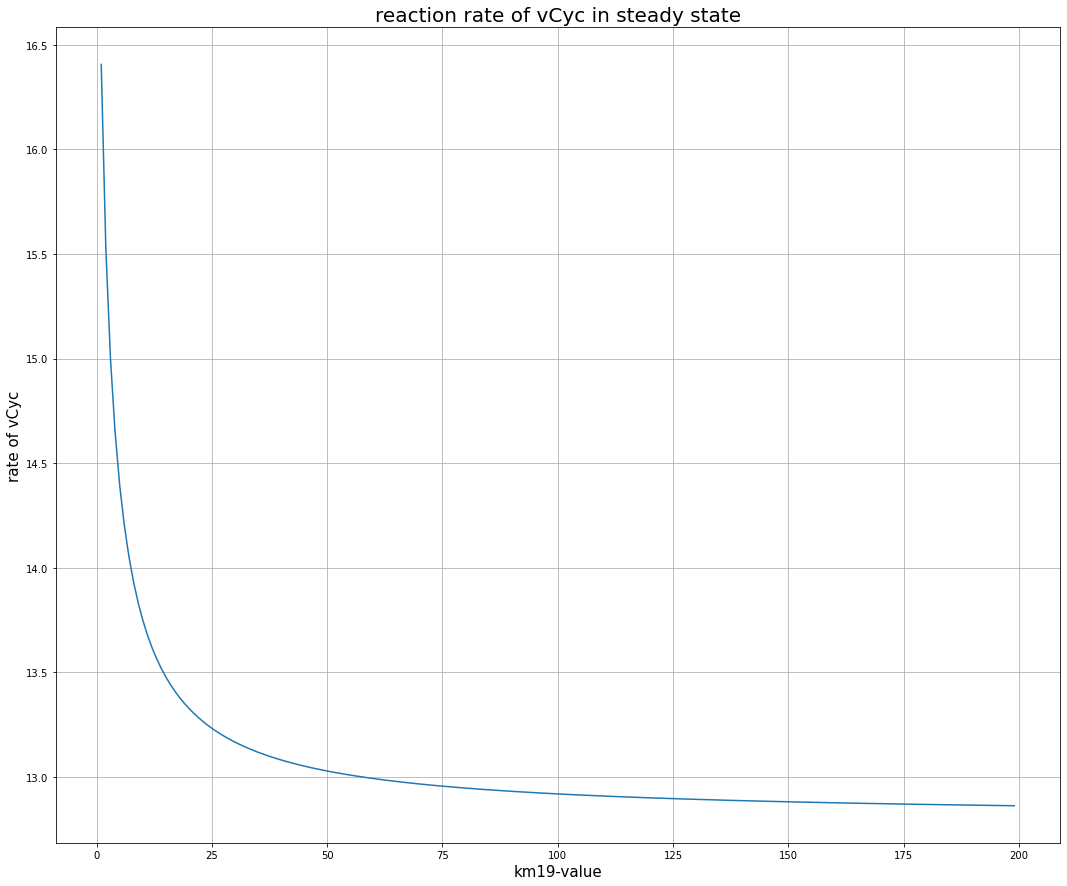

None


In [196]:
#(a) Cyclic electron flow
print(steady_rates_k('vCyc',klist))

[array([42.43409841]), array([42.82515445]), array([43.05472366]), array([43.20682893]), array([43.31534931]), array([43.3967934]), array([43.46022343]), array([43.51104607]), array([43.55269342]), array([43.58745174]), array([43.61690398]), array([43.6421816]), array([43.66411503]), array([43.68332795]), array([43.70029754]), array([43.71539563]), array([43.72891596]), array([43.74109378]), array([43.75211983]), array([43.76215025]), array([43.77131414]), array([43.77971932]), array([43.78745622]), array([43.79460159]), array([43.80122078]), array([43.80736999]), array([43.81309739]), array([43.81844512]), array([43.82344968]), array([43.82814306]), array([43.83255336]), array([43.83670576]), array([43.84062183]), array([43.84432152]), array([43.84782214]), array([43.85113931]), array([43.85428709]), array([43.85727827]), array([43.86012413]), array([43.86283506]), array([43.8654204]), array([43.86788868]), array([43.87024773]), array([43.87250464]), array([43.87466581]), array([43.87

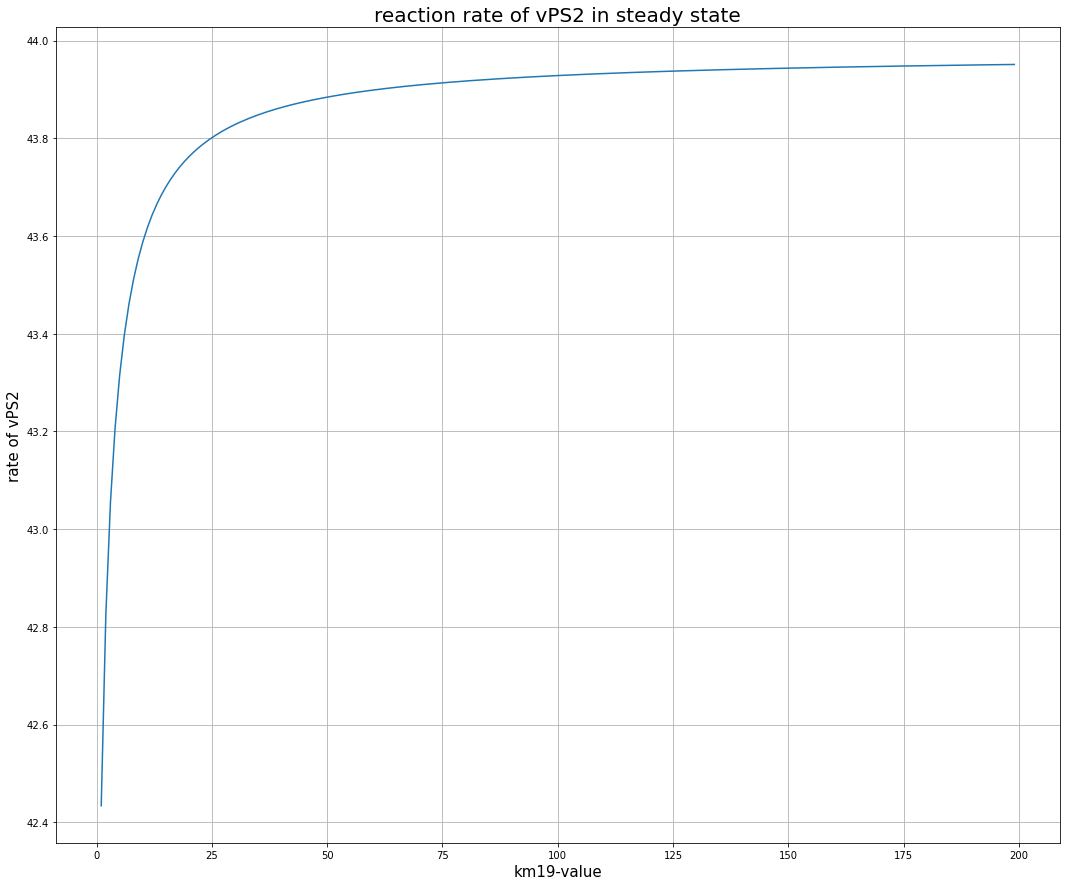

None


In [197]:
#(b) Electron flow through PSII
limly=30
limy=44
limlx=0
limx=200

print(steady_rates_k('vPS2', klist))